<a href="https://colab.research.google.com/github/AndreiAf02/Data-Balancing-in-ML-DNN/blob/main/Bank_Marketing_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Bank Marketing Dataset - ML Classification with Random Under/Oversampling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Data taken from the UCI Machine Learning repository [here](https://doi.org/10.24432/C5K306):

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# metadata
print(bank_marketing.metadata)

# variable information
print(bank_marketing.variables)



{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

In [ ]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,NaN
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,NaN
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,NaN


In [ ]:
y

,y
0,no
1,no
2,no
3,no
4,no
...,...
45206,yes
45207,yes
45208,yes
45209,no


In [ ]:
for i in range(len(X.columns)):
  print(X.columns[i])
  print(X.iloc[:, i].unique())
  print('------------------')

age
[58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]
------------------
job
['management' 'technician' 'entrepreneur' 'blue-collar' nan 'retired'
 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid' 'student']
------------------
marital
['married' 'single' 'divorced']
------------------
education
['tertiary' 'secondary' nan 'primary']
------------------
default
['no' 'yes']
------------------
balance
[ 2143    29     2 ...  8205 14204 16353]
------------------
housing
['yes' 'no']
------------------
loan
['no' 'yes']
------------------
contact
[nan 'cellular' 'telephone']
------------------
day_of_week
[ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
------------------
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

In [ ]:
X_numeric = pd.DataFrame()

## Age:
X_numeric['age'] = X['age']

## Working class:
X_numeric['job'] = X['job']
X_numeric['job'].replace(['management', 'technician', 'entrepreneur', 'blue-collar', 'retired',
 'admin.', 'services', 'self-employed', 'unemployed', 'housemaid', 'student'],
                                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], inplace=True)


## Marital:
X_numeric['marital'] = X['marital']
X_numeric['marital'].replace(['single', 'married', 'divorced'],
                                    [0, 1, 2], inplace=True)

## Education:
X_numeric['education'] = X['education']
X_numeric['education'].replace(['primary', 'secondary', 'tertiary'],
                                    [0, 1, 2], inplace=True)


## Credit Default:
X_numeric['default'] = X['default']
X_numeric['default'].replace(['no', 'yes'],
                                    [0, 1], inplace=True)



## Balance:
X_numeric['balance'] = X['balance']


## Housing:
X_numeric['housing'] = X['housing']
X_numeric['housing'].replace(['no', 'yes'],
                                    [0, 1], inplace=True)


## Loan:
X_numeric['loan'] = X['loan']
X_numeric['loan'].replace(['no', 'yes'],
                                    [0, 1], inplace=True)



## Contact:
X_numeric['contact'] = X['contact']
X_numeric['contact'].replace([np.nan, 'cellular', 'telephone'],
                                    [0, 1, 2], inplace=True)


## Day of week:
X_numeric['day_of_week'] = X['day_of_week']


## Month:
X_numeric['month'] = X['month']
X_numeric['month'].replace(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], inplace=True)


## Duration:
X_numeric['duration'] = X['duration']

## Campaign:
X_numeric['campaign'] = X['campaign']


## Pdays:
X_numeric['pdays'] = X['pdays']
# X_numeric['pdays'].replace([-1], [np.nan], inplace=True)

## Previous:
X_numeric['previous'] = X['previous']

## Poutcome:
X_numeric['poutcome'] = X['poutcome']
X_numeric['poutcome'].replace([np.nan, 'failure', 'success', 'other'],
                                    [0, 1, 2, 3], inplace=True)





## ---------------------- Response variable y: --------------------

## Income:
y_numeric = pd.DataFrame()
y_numeric['Y'] = y['y']
y_numeric['Y'].replace(['no', 'yes'],
                          [0, 1], inplace=True)

X_numeric


/tmp/ipython-input-3642445949.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_numeric['job'].replace(['management', 'technician', 'entrepreneur', 'blue-collar', 'retired',
/tmp/ipython-input-3642445949.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_numeric['job'].replace(['management', 

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,0.0,1,2.0,0,2143,1,0,0,5,4,261,1,-1,0,0
1,44,1.0,0,1.0,0,29,1,0,0,5,4,151,1,-1,0,0
2,33,2.0,1,1.0,0,2,1,1,0,5,4,76,1,-1,0,0
3,47,3.0,1,NaN,0,1506,1,0,0,5,4,92,1,-1,0,0
4,33,NaN,0,NaN,0,1,0,0,0,5,4,198,1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,1.0,1,2.0,0,825,0,0,1,17,10,977,3,-1,0,0
45207,71,4.0,2,0.0,0,1729,0,0,1,17,10,456,2,-1,0,0
45208,72,4.0,1,1.0,0,5715,0,0,1,17,10,1127,5,184,3,2
45209,57,3.0,1,1.0,0,668,0,0,2,17,10,508,4,-1,0,0


In [ ]:
# data2 = pd.concat([X_scaled, y], axis=1)
data2 = pd.concat([X_numeric, y_numeric], axis=1)
data2 = data2.dropna().reset_index(drop=True)
data2

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,Y
0,58,0.0,1,2.0,0,2143,1,0,0,5,4,261,1,-1,0,0,0
1,44,1.0,0,1.0,0,29,1,0,0,5,4,151,1,-1,0,0,0
2,33,2.0,1,1.0,0,2,1,1,0,5,4,76,1,-1,0,0,0
3,35,0.0,1,2.0,0,231,1,0,0,5,4,139,1,-1,0,0,0
4,28,0.0,0,2.0,0,447,1,1,0,5,4,217,1,-1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43188,51,1.0,1,2.0,0,825,0,0,1,17,10,977,3,-1,0,0,1
43189,71,4.0,2,0.0,0,1729,0,0,1,17,10,456,2,-1,0,0,1
43190,72,4.0,1,1.0,0,5715,0,0,1,17,10,1127,5,184,3,2,1
43191,57,3.0,1,1.0,0,668,0,0,2,17,10,508,4,-1,0,0,0


In [ ]:
data2['Y'].value_counts()

,count
Y,
0,38172
1,5021


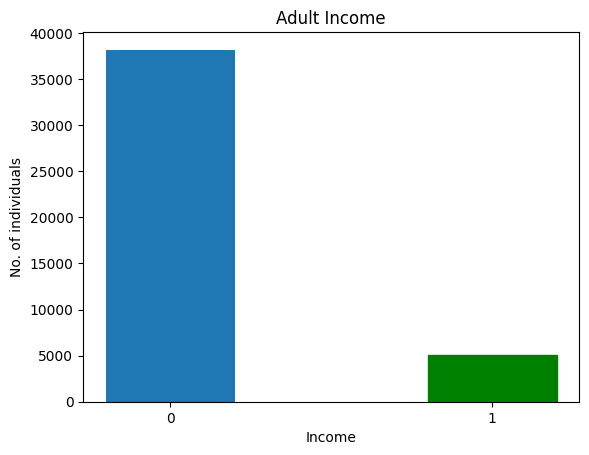

In [ ]:
barlist = plt.bar([str(0),str(1)], data2['Y'].value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Income")
plt.ylabel("No. of individuals")
plt.title("Adult Income")
plt.show()

# Full Dataset:

## DNN Classification Algorithm:

In [ ]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  return model



def train_and_evaluate_ml(model, X_train, X_test, y_train, y_test, domain):

    # time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)

    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tnr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tpr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)

    # conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # ## To deactivate after!!! ----------------------------------------
    # ##### Plot ROC curve and Confusion Matrix side by side
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # # ROC Curve
    # ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    # ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    # ax1.set_xlabel('False Positive Rate')
    # ax1.set_ylabel('True Positive Rate')
    # ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    # ax1.legend(loc='lower right')
    # ax1.grid()

    # # Confusion Matrix
    # conf_disp.plot(ax=ax2, cmap='Blues')
    # ax2.set_title('Confusion Matrix')
    # plt.tight_layout()
    # plt.show()
    ## To deactivate after!!! ----------------------------------------

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    return fpr, tnr, fnr, tpr


In [ ]:
X_cleaned = data2.iloc[:, :-1]
y_cleaned = data2.iloc[:, -1]

scaler = MinMaxScaler()
scaler.fit(X_cleaned)
X_scaled = scaler.transform(X_cleaned)
X_scaled = pd.DataFrame(X_scaled)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cleaned, test_size=0.20, random_state=0)
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

In [ ]:
print('X_train:',np.shape(X_train))
print('y_train:',np.shape(y_train))
print('X_test:',np.shape(X_test))
print('y_test:',np.shape(y_test))

X_train: (34554, 16)
y_train: (34554,)
X_test: (8639, 16)
y_test: (8639,)


In [ ]:
## Establishing the Under/Oversampling values and imbalance ratio:

undersample_size = min(data_train.iloc[:,-1].value_counts())
oversample_size = max(data_train.iloc[:,-1].value_counts())


data_majority = data_train[data_train.iloc[:,-1]==0]
data_minority = data_train[data_train.iloc[:,-1]==1]

print(undersample_size)
print(oversample_size)

4033
30521


## Imbalanced (Original) data:

In [ ]:
times = 50

FPR = []
TPR = []
FNR = []
TNR = []


for i in range(times):
    model_source = create_dnn_model(X_train.shape[1])
    result_imbalanced = train_and_evaluate_ml(model_source, X_train, X_test, y_train, y_test, "Source")
    # result_TL_imbalanced = Transductive_TL(model_source, X_T_full, y_T_full, "Target")

    FPR.append(result_imbalanced[0])
    TNR.append(result_imbalanced[1])
    FNR.append(result_imbalanced[2])
    TPR.append(result_imbalanced[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']
# print(ParamFit)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.6828 - loss: 0.3494 - val_AUC: 0.8724 - val_loss: 0.2667
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8759 - loss: 0.2559 - val_AUC: 0.8823 - val_loss: 0.2500
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8897 - loss: 0.2399 - val_AUC: 0.8831 - val_loss: 0.2506
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8844 - loss: 0.2415 - val_AUC: 0.8888 - val_loss: 0.2439
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8897 - loss: 0.2408 - val_AUC: 0.8899 - val_loss: 0.2433
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8951 - loss: 0.2298 - val_AUC: 0.8932 - val_loss: 0.2438
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8979 - loss: 0.2318 - val_AUC: 0.8943 - val_loss: 0.2398
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8934 - loss: 0.2341 - val_AUC: 0.8950 - val_loss: 0.2587
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9031 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6783 - loss: 0.3622 - val_AUC: 0.8657 - val_loss: 0.2649
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8715 - loss: 0.2534 - val_AUC: 0.8793 - val_loss: 0.2548
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8871 - loss: 0.2486 - val_AUC: 0.8817 - val_loss: 0.2500
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8827 - loss: 0.2428 - val_AUC: 0.8867 - val_loss: 0.2490
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8891 - loss: 0.2407 - val_AUC: 0.8854 - val_loss: 0.2480
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8916 - loss: 0.2394 - val_AUC: 0.8876 - val_loss: 0.2463
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8948 - loss: 0.2356 - val_AUC: 0.8911 - val_loss: 0.2405
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8957 - loss: 0.2351 - val_AUC: 0.8885 - val_loss: 0.2468
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8989 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6650 - loss: 0.3583 - val_AUC: 0.8758 - val_loss: 0.2593
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8727 - loss: 0.2545 - val_AUC: 0.8823 - val_loss: 0.2554
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8843 - loss: 0.2412 - val_AUC: 0.8846 - val_loss: 0.2490
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8833 - loss: 0.2451 - val_AUC: 0.8861 - val_loss: 0.2462
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8847 - loss: 0.2415 - val_AUC: 0.8883 - val_loss: 0.2437
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8910 - loss: 0.2343 - val_AUC: 0.8901 - val_loss: 0.2415
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8955 - loss: 0.2351 - val_AUC: 0.8884 - val_loss: 0.2423
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8989 - loss: 0.2322 - val_AUC: 0.8896 - val_loss: 0.2413
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8998 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.6947 - loss: 0.3469 - val_AUC: 0.8706 - val_loss: 0.2635
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8743 - loss: 0.2540 - val_AUC: 0.8807 - val_loss: 0.2521
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8876 - loss: 0.2401 - val_AUC: 0.8858 - val_loss: 0.2458
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8889 - loss: 0.2417 - val_AUC: 0.8898 - val_loss: 0.2429
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8978 - loss: 0.2323 - val_AUC: 0.8899 - val_loss: 0.2432
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8978 - loss: 0.2296 - val_AUC: 0.8921 - val_loss: 0.2407
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8964 - loss: 0.2366 - val_AUC: 0.8943 - val_loss: 0.2383
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8982 - loss: 0.2311 - val_AUC: 0.8945 - val_loss: 0.2402
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9022 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6415 - loss: 0.3950 - val_AUC: 0.8602 - val_loss: 0.2712
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8701 - loss: 0.2585 - val_AUC: 0.8811 - val_loss: 0.2529
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8814 - loss: 0.2456 - val_AUC: 0.8861 - val_loss: 0.2479
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8874 - loss: 0.2419 - val_AUC: 0.8860 - val_loss: 0.2493
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8929 - loss: 0.2354 - val_AUC: 0.8894 - val_loss: 0.2424
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8935 - loss: 0.2367 - val_AUC: 0.8907 - val_loss: 0.2421
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9001 - loss: 0.2252 - val_AUC: 0.8930 - val_loss: 0.2390
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8963 - loss: 0.2355 - val_AUC: 0.8946 - val_loss: 0.2409
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8990 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6738 - loss: 0.3601 - val_AUC: 0.8733 - val_loss: 0.2668
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8755 - loss: 0.2483 - val_AUC: 0.8853 - val_loss: 0.2486
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8871 - loss: 0.2391 - val_AUC: 0.8850 - val_loss: 0.2465
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8902 - loss: 0.2382 - val_AUC: 0.8870 - val_loss: 0.2451
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8873 - loss: 0.2409 - val_AUC: 0.8906 - val_loss: 0.2441
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8962 - loss: 0.2323 - val_AUC: 0.8908 - val_loss: 0.2415
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8993 - loss: 0.2308 - val_AUC: 0.8941 - val_loss: 0.2435
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8998 - loss: 0.2319 - val_AUC: 0.8927 - val_loss: 0.2530
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8996 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.6562 - loss: 0.3690 - val_AUC: 0.8667 - val_loss: 0.2657
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8784 - loss: 0.2542 - val_AUC: 0.8822 - val_loss: 0.2508
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8826 - loss: 0.2496 - val_AUC: 0.8850 - val_loss: 0.2480
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8831 - loss: 0.2410 - val_AUC: 0.8880 - val_loss: 0.2447
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8943 - loss: 0.2351 - val_AUC: 0.8901 - val_loss: 0.2461
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8947 - loss: 0.2325 - val_AUC: 0.8937 - val_loss: 0.2397
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8987 - loss: 0.2299 - val_AUC: 0.8953 - val_loss: 0.2400
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8997 - loss: 0.2307 - val_AUC: 0.8956 - val_loss: 0.2374
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9007 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6689 - loss: 0.3535 - val_AUC: 0.8737 - val_loss: 0.2611
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8770 - loss: 0.2524 - val_AUC: 0.8860 - val_loss: 0.2480
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8890 - loss: 0.2403 - val_AUC: 0.8835 - val_loss: 0.2482
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8895 - loss: 0.2356 - val_AUC: 0.8883 - val_loss: 0.2439
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8953 - loss: 0.2343 - val_AUC: 0.8891 - val_loss: 0.2446
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8934 - loss: 0.2350 - val_AUC: 0.8894 - val_loss: 0.2431
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8939 - loss: 0.2332 - val_AUC: 0.8920 - val_loss: 0.2433
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8938 - loss: 0.2294 - val_AUC: 0.8934 - val_loss: 0.2388
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9004 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6666 - loss: 0.3589 - val_AUC: 0.8734 - val_loss: 0.2692
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8792 - loss: 0.2531 - val_AUC: 0.8842 - val_loss: 0.2491
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8851 - loss: 0.2468 - val_AUC: 0.8849 - val_loss: 0.2507
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8886 - loss: 0.2408 - val_AUC: 0.8877 - val_loss: 0.2435
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8884 - loss: 0.2373 - val_AUC: 0.8880 - val_loss: 0.2431
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8981 - loss: 0.2303 - val_AUC: 0.8902 - val_loss: 0.2417
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8972 - loss: 0.2298 - val_AUC: 0.8919 - val_loss: 0.2450
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9007 - loss: 0.2263 - val_AUC: 0.8960 - val_loss: 0.2404
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9047 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6745 - loss: 0.3636 - val_AUC: 0.8706 - val_loss: 0.2612
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8790 - loss: 0.2530 - val_AUC: 0.8819 - val_loss: 0.2524
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8875 - loss: 0.2436 - val_AUC: 0.8860 - val_loss: 0.2516
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8824 - loss: 0.2438 - val_AUC: 0.8880 - val_loss: 0.2446
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8910 - loss: 0.2416 - val_AUC: 0.8867 - val_loss: 0.2463
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8928 - loss: 0.2365 - val_AUC: 0.8885 - val_loss: 0.2452
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8910 - loss: 0.2375 - val_AUC: 0.8923 - val_loss: 0.2478
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8912 - loss: 0.2381 - val_AUC: 0.8913 - val_loss: 0.2419
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8932 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.6811 - loss: 0.3513 - val_AUC: 0.8727 - val_loss: 0.2598
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8808 - loss: 0.2454 - val_AUC: 0.8834 - val_loss: 0.2484
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8836 - loss: 0.2432 - val_AUC: 0.8840 - val_loss: 0.2469
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8904 - loss: 0.2370 - val_AUC: 0.8863 - val_loss: 0.2469
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8957 - loss: 0.2323 - val_AUC: 0.8898 - val_loss: 0.2427
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8939 - loss: 0.2371 - val_AUC: 0.8917 - val_loss: 0.2418
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8972 - loss: 0.2366 - val_AUC: 0.8948 - val_loss: 0.2380
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8965 - loss: 0.2313 - val_AUC: 0.8959 - val_loss: 0.2396
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9025 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6600 - loss: 0.3609 - val_AUC: 0.8785 - val_loss: 0.2654
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8766 - loss: 0.2530 - val_AUC: 0.8812 - val_loss: 0.2500
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8901 - loss: 0.2406 - val_AUC: 0.8857 - val_loss: 0.2461
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8879 - loss: 0.2419 - val_AUC: 0.8886 - val_loss: 0.2460
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8956 - loss: 0.2365 - val_AUC: 0.8893 - val_loss: 0.2462
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8973 - loss: 0.2317 - val_AUC: 0.8901 - val_loss: 0.2450
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8950 - loss: 0.2343 - val_AUC: 0.8949 - val_loss: 0.2377
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9054 - loss: 0.2257 - val_AUC: 0.8940 - val_loss: 0.2387
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9071 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6562 - loss: 0.3540 - val_AUC: 0.8724 - val_loss: 0.2600
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8777 - loss: 0.2531 - val_AUC: 0.8832 - val_loss: 0.2504
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8845 - loss: 0.2481 - val_AUC: 0.8834 - val_loss: 0.2525
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8890 - loss: 0.2408 - val_AUC: 0.8834 - val_loss: 0.2470
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8864 - loss: 0.2416 - val_AUC: 0.8884 - val_loss: 0.2436
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8914 - loss: 0.2372 - val_AUC: 0.8875 - val_loss: 0.2508
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8930 - loss: 0.2368 - val_AUC: 0.8912 - val_loss: 0.2410
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8943 - loss: 0.2360 - val_AUC: 0.8893 - val_loss: 0.2446
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8941 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7006 - loss: 0.3355 - val_AUC: 0.8759 - val_loss: 0.2587
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8798 - loss: 0.2490 - val_AUC: 0.8821 - val_loss: 0.2525
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8789 - loss: 0.2471 - val_AUC: 0.8839 - val_loss: 0.2479
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8795 - loss: 0.2496 - val_AUC: 0.8857 - val_loss: 0.2473
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8913 - loss: 0.2381 - val_AUC: 0.8875 - val_loss: 0.2450
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8935 - loss: 0.2382 - val_AUC: 0.8901 - val_loss: 0.2423
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8899 - loss: 0.2375 - val_AUC: 0.8885 - val_loss: 0.2436
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8992 - loss: 0.2314 - val_AUC: 0.8912 - val_loss: 0.2470
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9009 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6719 - loss: 0.3598 - val_AUC: 0.8704 - val_loss: 0.2670
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8764 - loss: 0.2484 - val_AUC: 0.8815 - val_loss: 0.2562
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8779 - loss: 0.2478 - val_AUC: 0.8862 - val_loss: 0.2461
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8851 - loss: 0.2408 - val_AUC: 0.8879 - val_loss: 0.2462
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8940 - loss: 0.2363 - val_AUC: 0.8906 - val_loss: 0.2423
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8933 - loss: 0.2408 - val_AUC: 0.8905 - val_loss: 0.2419
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8983 - loss: 0.2352 - val_AUC: 0.8920 - val_loss: 0.2407
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8982 - loss: 0.2308 - val_AUC: 0.8951 - val_loss: 0.2392
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.9007 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6717 - loss: 0.3687 - val_AUC: 0.8682 - val_loss: 0.2652
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8794 - loss: 0.2516 - val_AUC: 0.8824 - val_loss: 0.2578
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8874 - loss: 0.2382 - val_AUC: 0.8837 - val_loss: 0.2495
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8920 - loss: 0.2408 - val_AUC: 0.8892 - val_loss: 0.2449
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8878 - loss: 0.2421 - val_AUC: 0.8875 - val_loss: 0.2443
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8891 - loss: 0.2369 - val_AUC: 0.8916 - val_loss: 0.2410
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8978 - loss: 0.2318 - val_AUC: 0.8946 - val_loss: 0.2396
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9026 - loss: 0.2268 - val_AUC: 0.8950 - val_loss: 0.2378
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9016 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6640 - loss: 0.3670 - val_AUC: 0.8676 - val_loss: 0.2671
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8811 - loss: 0.2520 - val_AUC: 0.8828 - val_loss: 0.2508
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8858 - loss: 0.2400 - val_AUC: 0.8857 - val_loss: 0.2462
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8870 - loss: 0.2401 - val_AUC: 0.8883 - val_loss: 0.2466
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8910 - loss: 0.2361 - val_AUC: 0.8890 - val_loss: 0.2457
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8936 - loss: 0.2332 - val_AUC: 0.8897 - val_loss: 0.2421
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8970 - loss: 0.2331 - val_AUC: 0.8918 - val_loss: 0.2445
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8979 - loss: 0.2366 - val_AUC: 0.8929 - val_loss: 0.2444
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8984 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.6690 - loss: 0.3548 - val_AUC: 0.8728 - val_loss: 0.2655
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8798 - loss: 0.2514 - val_AUC: 0.8794 - val_loss: 0.2529
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8815 - loss: 0.2431 - val_AUC: 0.8824 - val_loss: 0.2580
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8913 - loss: 0.2395 - val_AUC: 0.8864 - val_loss: 0.2456
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8884 - loss: 0.2396 - val_AUC: 0.8849 - val_loss: 0.2463
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8896 - loss: 0.2430 - val_AUC: 0.8868 - val_loss: 0.2452
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8937 - loss: 0.2360 - val_AUC: 0.8885 - val_loss: 0.2428
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8895 - loss: 0.2326 - val_AUC: 0.8895 - val_loss: 0.2421
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8992 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6686 - loss: 0.3482 - val_AUC: 0.8735 - val_loss: 0.2630
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8787 - loss: 0.2557 - val_AUC: 0.8803 - val_loss: 0.2564
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8868 - loss: 0.2453 - val_AUC: 0.8858 - val_loss: 0.2472
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8911 - loss: 0.2404 - val_AUC: 0.8867 - val_loss: 0.2471
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8930 - loss: 0.2356 - val_AUC: 0.8878 - val_loss: 0.2450
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8944 - loss: 0.2333 - val_AUC: 0.8895 - val_loss: 0.2431
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8948 - loss: 0.2357 - val_AUC: 0.8896 - val_loss: 0.2429
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.9032 - loss: 0.2266 - val_AUC: 0.8925 - val_loss: 0.2471
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8998 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.6694 - loss: 0.3517 - val_AUC: 0.8731 - val_loss: 0.2667
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8774 - loss: 0.2529 - val_AUC: 0.8806 - val_loss: 0.2513
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8872 - loss: 0.2433 - val_AUC: 0.8847 - val_loss: 0.2512
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8841 - loss: 0.2435 - val_AUC: 0.8881 - val_loss: 0.2448
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8912 - loss: 0.2433 - val_AUC: 0.8865 - val_loss: 0.2452
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8901 - loss: 0.2390 - val_AUC: 0.8910 - val_loss: 0.2429
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8935 - loss: 0.2381 - val_AUC: 0.8905 - val_loss: 0.2415
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8947 - loss: 0.2354 - val_AUC: 0.8917 - val_loss: 0.2409
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9017 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6832 - loss: 0.3516 - val_AUC: 0.8737 - val_loss: 0.2611
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8747 - loss: 0.2570 - val_AUC: 0.8852 - val_loss: 0.2514
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8874 - loss: 0.2437 - val_AUC: 0.8858 - val_loss: 0.2477
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8935 - loss: 0.2396 - val_AUC: 0.8852 - val_loss: 0.2568
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8907 - loss: 0.2377 - val_AUC: 0.8887 - val_loss: 0.2431
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8987 - loss: 0.2311 - val_AUC: 0.8891 - val_loss: 0.2419
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8986 - loss: 0.2291 - val_AUC: 0.8940 - val_loss: 0.2443
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8985 - loss: 0.2328 - val_AUC: 0.8962 - val_loss: 0.2424
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9029 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6781 - loss: 0.3578 - val_AUC: 0.8728 - val_loss: 0.2672
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8769 - loss: 0.2554 - val_AUC: 0.8811 - val_loss: 0.2546
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8798 - loss: 0.2496 - val_AUC: 0.8829 - val_loss: 0.2494
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8850 - loss: 0.2422 - val_AUC: 0.8861 - val_loss: 0.2462
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8901 - loss: 0.2395 - val_AUC: 0.8891 - val_loss: 0.2425
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8980 - loss: 0.2297 - val_AUC: 0.8863 - val_loss: 0.2445
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8898 - loss: 0.2380 - val_AUC: 0.8912 - val_loss: 0.2413
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8954 - loss: 0.2318 - val_AUC: 0.8915 - val_loss: 0.2414
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8958 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6557 - loss: 0.3692 - val_AUC: 0.8695 - val_loss: 0.2624
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8791 - loss: 0.2493 - val_AUC: 0.8821 - val_loss: 0.2527
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8827 - loss: 0.2448 - val_AUC: 0.8824 - val_loss: 0.2488
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8903 - loss: 0.2437 - val_AUC: 0.8861 - val_loss: 0.2475
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8959 - loss: 0.2321 - val_AUC: 0.8862 - val_loss: 0.2448
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8916 - loss: 0.2328 - val_AUC: 0.8886 - val_loss: 0.2541
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8879 - loss: 0.2356 - val_AUC: 0.8890 - val_loss: 0.2427
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8948 - loss: 0.2285 - val_AUC: 0.8909 - val_loss: 0.2431
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8954 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6449 - loss: 0.3851 - val_AUC: 0.8731 - val_loss: 0.2607
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8731 - loss: 0.2526 - val_AUC: 0.8828 - val_loss: 0.2531
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8877 - loss: 0.2390 - val_AUC: 0.8851 - val_loss: 0.2465
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8914 - loss: 0.2375 - val_AUC: 0.8844 - val_loss: 0.2517
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8901 - loss: 0.2415 - val_AUC: 0.8889 - val_loss: 0.2440
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8937 - loss: 0.2352 - val_AUC: 0.8873 - val_loss: 0.2436
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8946 - loss: 0.2347 - val_AUC: 0.8892 - val_loss: 0.2472
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.9003 - loss: 0.2278 - val_AUC: 0.8919 - val_loss: 0.2497
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9008 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6660 - loss: 0.3651 - val_AUC: 0.8722 - val_loss: 0.2687
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8768 - loss: 0.2487 - val_AUC: 0.8798 - val_loss: 0.2528
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8871 - loss: 0.2448 - val_AUC: 0.8842 - val_loss: 0.2502
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8861 - loss: 0.2404 - val_AUC: 0.8884 - val_loss: 0.2434
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8950 - loss: 0.2358 - val_AUC: 0.8922 - val_loss: 0.2417
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8978 - loss: 0.2306 - val_AUC: 0.8938 - val_loss: 0.2388
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.9007 - loss: 0.2265 - val_AUC: 0.8960 - val_loss: 0.2378
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9033 - loss: 0.2241 - val_AUC: 0.8939 - val_loss: 0.2435
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9027 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.6545 - loss: 0.3676 - val_AUC: 0.8695 - val_loss: 0.2671
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8745 - loss: 0.2546 - val_AUC: 0.8826 - val_loss: 0.2515
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8864 - loss: 0.2422 - val_AUC: 0.8842 - val_loss: 0.2479
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8897 - loss: 0.2351 - val_AUC: 0.8862 - val_loss: 0.2479
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8911 - loss: 0.2389 - val_AUC: 0.8858 - val_loss: 0.2460
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8916 - loss: 0.2379 - val_AUC: 0.8858 - val_loss: 0.2524
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8919 - loss: 0.2379 - val_AUC: 0.8907 - val_loss: 0.2457
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8981 - loss: 0.2312 - val_AUC: 0.8890 - val_loss: 0.2484
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8932 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6739 - loss: 0.3622 - val_AUC: 0.8802 - val_loss: 0.2578
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8760 - loss: 0.2513 - val_AUC: 0.8841 - val_loss: 0.2517
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8845 - loss: 0.2421 - val_AUC: 0.8847 - val_loss: 0.2655
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8892 - loss: 0.2389 - val_AUC: 0.8886 - val_loss: 0.2469
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8936 - loss: 0.2385 - val_AUC: 0.8881 - val_loss: 0.2431
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8940 - loss: 0.2327 - val_AUC: 0.8911 - val_loss: 0.2422
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8968 - loss: 0.2326 - val_AUC: 0.8936 - val_loss: 0.2393
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8963 - loss: 0.2356 - val_AUC: 0.8930 - val_loss: 0.2397
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8964 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6706 - loss: 0.3759 - val_AUC: 0.8734 - val_loss: 0.2645
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8744 - loss: 0.2561 - val_AUC: 0.8801 - val_loss: 0.2515
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8885 - loss: 0.2421 - val_AUC: 0.8858 - val_loss: 0.2473
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8914 - loss: 0.2394 - val_AUC: 0.8869 - val_loss: 0.2460
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8897 - loss: 0.2397 - val_AUC: 0.8879 - val_loss: 0.2441
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8933 - loss: 0.2331 - val_AUC: 0.8888 - val_loss: 0.2453
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8972 - loss: 0.2363 - val_AUC: 0.8934 - val_loss: 0.2395
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8966 - loss: 0.2320 - val_AUC: 0.8931 - val_loss: 0.2400
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9023 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6546 - loss: 0.3695 - val_AUC: 0.8726 - val_loss: 0.2658
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8724 - loss: 0.2575 - val_AUC: 0.8782 - val_loss: 0.2609
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8800 - loss: 0.2509 - val_AUC: 0.8820 - val_loss: 0.2500
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8867 - loss: 0.2418 - val_AUC: 0.8848 - val_loss: 0.2534
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8900 - loss: 0.2388 - val_AUC: 0.8890 - val_loss: 0.2466
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8905 - loss: 0.2378 - val_AUC: 0.8865 - val_loss: 0.2464
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8927 - loss: 0.2350 - val_AUC: 0.8880 - val_loss: 0.2439
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8985 - loss: 0.2312 - val_AUC: 0.8919 - val_loss: 0.2446
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9028 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6887 - loss: 0.3531 - val_AUC: 0.8687 - val_loss: 0.2663
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8802 - loss: 0.2537 - val_AUC: 0.8794 - val_loss: 0.2526
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8848 - loss: 0.2408 - val_AUC: 0.8870 - val_loss: 0.2460
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8899 - loss: 0.2408 - val_AUC: 0.8873 - val_loss: 0.2444
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8899 - loss: 0.2414 - val_AUC: 0.8869 - val_loss: 0.2491
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8947 - loss: 0.2317 - val_AUC: 0.8891 - val_loss: 0.2418
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8960 - loss: 0.2346 - val_AUC: 0.8914 - val_loss: 0.2407
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8964 - loss: 0.2352 - val_AUC: 0.8907 - val_loss: 0.2543
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9003 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6575 - loss: 0.3607 - val_AUC: 0.8722 - val_loss: 0.2627
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8712 - loss: 0.2592 - val_AUC: 0.8792 - val_loss: 0.2523
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8857 - loss: 0.2463 - val_AUC: 0.8817 - val_loss: 0.2503
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8894 - loss: 0.2384 - val_AUC: 0.8855 - val_loss: 0.2461
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8877 - loss: 0.2416 - val_AUC: 0.8865 - val_loss: 0.2461
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8970 - loss: 0.2285 - val_AUC: 0.8881 - val_loss: 0.2455
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8932 - loss: 0.2313 - val_AUC: 0.8895 - val_loss: 0.2425
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8938 - loss: 0.2375 - val_AUC: 0.8903 - val_loss: 0.2465
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8984 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6724 - loss: 0.3679 - val_AUC: 0.8719 - val_loss: 0.2608
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8773 - loss: 0.2546 - val_AUC: 0.8844 - val_loss: 0.2500
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8870 - loss: 0.2433 - val_AUC: 0.8825 - val_loss: 0.2491
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8922 - loss: 0.2379 - val_AUC: 0.8864 - val_loss: 0.2459
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8896 - loss: 0.2388 - val_AUC: 0.8864 - val_loss: 0.2602
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8910 - loss: 0.2385 - val_AUC: 0.8910 - val_loss: 0.2422
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8963 - loss: 0.2321 - val_AUC: 0.8916 - val_loss: 0.2461
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8992 - loss: 0.2263 - val_AUC: 0.8903 - val_loss: 0.2418
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8983 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6762 - loss: 0.3603 - val_AUC: 0.8749 - val_loss: 0.2616
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8741 - loss: 0.2535 - val_AUC: 0.8811 - val_loss: 0.2527
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8855 - loss: 0.2425 - val_AUC: 0.8836 - val_loss: 0.2487
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8862 - loss: 0.2432 - val_AUC: 0.8858 - val_loss: 0.2465
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8887 - loss: 0.2403 - val_AUC: 0.8859 - val_loss: 0.2465
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8962 - loss: 0.2309 - val_AUC: 0.8863 - val_loss: 0.2454
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8952 - loss: 0.2342 - val_AUC: 0.8880 - val_loss: 0.2458
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8958 - loss: 0.2329 - val_AUC: 0.8907 - val_loss: 0.2415
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8993 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6646 - loss: 0.3573 - val_AUC: 0.8624 - val_loss: 0.2656
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8739 - loss: 0.2500 - val_AUC: 0.8800 - val_loss: 0.2522
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8781 - loss: 0.2435 - val_AUC: 0.8824 - val_loss: 0.2515
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8830 - loss: 0.2413 - val_AUC: 0.8842 - val_loss: 0.2525
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8892 - loss: 0.2431 - val_AUC: 0.8869 - val_loss: 0.2446
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8877 - loss: 0.2416 - val_AUC: 0.8895 - val_loss: 0.2432
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8922 - loss: 0.2390 - val_AUC: 0.8901 - val_loss: 0.2477
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8930 - loss: 0.2347 - val_AUC: 0.8887 - val_loss: 0.2531
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8991 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6952 - loss: 0.3326 - val_AUC: 0.8740 - val_loss: 0.2599
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8766 - loss: 0.2565 - val_AUC: 0.8791 - val_loss: 0.2540
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8836 - loss: 0.2466 - val_AUC: 0.8825 - val_loss: 0.2489
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8945 - loss: 0.2344 - val_AUC: 0.8872 - val_loss: 0.2505
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8890 - loss: 0.2444 - val_AUC: 0.8874 - val_loss: 0.2444
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8991 - loss: 0.2296 - val_AUC: 0.8894 - val_loss: 0.2439
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8947 - loss: 0.2340 - val_AUC: 0.8899 - val_loss: 0.2429
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8960 - loss: 0.2333 - val_AUC: 0.8896 - val_loss: 0.2427
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9007 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6489 - loss: 0.3604 - val_AUC: 0.8670 - val_loss: 0.2764
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8771 - loss: 0.2529 - val_AUC: 0.8833 - val_loss: 0.2496
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8899 - loss: 0.2414 - val_AUC: 0.8852 - val_loss: 0.2529
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8898 - loss: 0.2393 - val_AUC: 0.8841 - val_loss: 0.2563
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8930 - loss: 0.2337 - val_AUC: 0.8895 - val_loss: 0.2428
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8925 - loss: 0.2388 - val_AUC: 0.8883 - val_loss: 0.2437
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8976 - loss: 0.2323 - val_AUC: 0.8885 - val_loss: 0.2430
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8982 - loss: 0.2351 - val_AUC: 0.8885 - val_loss: 0.2467
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9002 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6564 - loss: 0.3528 - val_AUC: 0.8701 - val_loss: 0.2629
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8820 - loss: 0.2465 - val_AUC: 0.8818 - val_loss: 0.2512
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8873 - loss: 0.2400 - val_AUC: 0.8840 - val_loss: 0.2591
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8831 - loss: 0.2418 - val_AUC: 0.8856 - val_loss: 0.2488
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8935 - loss: 0.2369 - val_AUC: 0.8859 - val_loss: 0.2498
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8907 - loss: 0.2388 - val_AUC: 0.8876 - val_loss: 0.2447
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8953 - loss: 0.2380 - val_AUC: 0.8893 - val_loss: 0.2428
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8986 - loss: 0.2317 - val_AUC: 0.8920 - val_loss: 0.2404
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8972 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.6314 - loss: 0.3767 - val_AUC: 0.8604 - val_loss: 0.2747
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8728 - loss: 0.2663 - val_AUC: 0.8809 - val_loss: 0.2605
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8887 - loss: 0.2419 - val_AUC: 0.8847 - val_loss: 0.2503
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8897 - loss: 0.2401 - val_AUC: 0.8861 - val_loss: 0.2530
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8913 - loss: 0.2407 - val_AUC: 0.8888 - val_loss: 0.2453
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8948 - loss: 0.2346 - val_AUC: 0.8897 - val_loss: 0.2425
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8913 - loss: 0.2382 - val_AUC: 0.8905 - val_loss: 0.2424
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8979 - loss: 0.2340 - val_AUC: 0.8909 - val_loss: 0.2427
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8939 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6650 - loss: 0.3536 - val_AUC: 0.8754 - val_loss: 0.2626
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8735 - loss: 0.2603 - val_AUC: 0.8838 - val_loss: 0.2508
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8886 - loss: 0.2383 - val_AUC: 0.8834 - val_loss: 0.2492
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8887 - loss: 0.2422 - val_AUC: 0.8881 - val_loss: 0.2479
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8854 - loss: 0.2417 - val_AUC: 0.8873 - val_loss: 0.2511
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8913 - loss: 0.2376 - val_AUC: 0.8861 - val_loss: 0.2454
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8953 - loss: 0.2345 - val_AUC: 0.8919 - val_loss: 0.2403
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8997 - loss: 0.2313 - val_AUC: 0.8935 - val_loss: 0.2387
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9024 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6859 - loss: 0.3638 - val_AUC: 0.8744 - val_loss: 0.2588
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8809 - loss: 0.2522 - val_AUC: 0.8820 - val_loss: 0.2505
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8852 - loss: 0.2409 - val_AUC: 0.8850 - val_loss: 0.2485
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8926 - loss: 0.2363 - val_AUC: 0.8877 - val_loss: 0.2466
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8902 - loss: 0.2430 - val_AUC: 0.8882 - val_loss: 0.2451
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8978 - loss: 0.2316 - val_AUC: 0.8894 - val_loss: 0.2499
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9004 - loss: 0.2293 - val_AUC: 0.8900 - val_loss: 0.2427
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8975 - loss: 0.2312 - val_AUC: 0.8911 - val_loss: 0.2410
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9016 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6682 - loss: 0.3575 - val_AUC: 0.8742 - val_loss: 0.2611
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8743 - loss: 0.2544 - val_AUC: 0.8792 - val_loss: 0.2514
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8863 - loss: 0.2349 - val_AUC: 0.8833 - val_loss: 0.2523
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8899 - loss: 0.2391 - val_AUC: 0.8857 - val_loss: 0.2457
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8910 - loss: 0.2365 - val_AUC: 0.8868 - val_loss: 0.2457
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8936 - loss: 0.2373 - val_AUC: 0.8895 - val_loss: 0.2531
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8966 - loss: 0.2325 - val_AUC: 0.8917 - val_loss: 0.2412
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8994 - loss: 0.2350 - val_AUC: 0.8951 - val_loss: 0.2382
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8993 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6801 - loss: 0.3452 - val_AUC: 0.8712 - val_loss: 0.2626
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8780 - loss: 0.2523 - val_AUC: 0.8799 - val_loss: 0.2603
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8846 - loss: 0.2494 - val_AUC: 0.8852 - val_loss: 0.2469
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8851 - loss: 0.2423 - val_AUC: 0.8826 - val_loss: 0.2539
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8929 - loss: 0.2392 - val_AUC: 0.8877 - val_loss: 0.2477
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8971 - loss: 0.2375 - val_AUC: 0.8889 - val_loss: 0.2456
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8957 - loss: 0.2312 - val_AUC: 0.8909 - val_loss: 0.2417
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9000 - loss: 0.2283 - val_AUC: 0.8905 - val_loss: 0.2421
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8967 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.6803 - loss: 0.3536 - val_AUC: 0.8689 - val_loss: 0.2622
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8705 - loss: 0.2568 - val_AUC: 0.8821 - val_loss: 0.2541
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8836 - loss: 0.2455 - val_AUC: 0.8847 - val_loss: 0.2502
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8892 - loss: 0.2401 - val_AUC: 0.8866 - val_loss: 0.2548
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8916 - loss: 0.2327 - val_AUC: 0.8904 - val_loss: 0.2427
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8952 - loss: 0.2343 - val_AUC: 0.8920 - val_loss: 0.2436
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8978 - loss: 0.2347 - val_AUC: 0.8942 - val_loss: 0.2384
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8950 - loss: 0.2325 - val_AUC: 0.8970 - val_loss: 0.2365
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9029 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6731 - loss: 0.3611 - val_AUC: 0.8731 - val_loss: 0.2628
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8714 - loss: 0.2587 - val_AUC: 0.8828 - val_loss: 0.2510
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8881 - loss: 0.2426 - val_AUC: 0.8848 - val_loss: 0.2520
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8885 - loss: 0.2373 - val_AUC: 0.8873 - val_loss: 0.2449
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8895 - loss: 0.2401 - val_AUC: 0.8891 - val_loss: 0.2462
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8938 - loss: 0.2368 - val_AUC: 0.8901 - val_loss: 0.2415
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8986 - loss: 0.2292 - val_AUC: 0.8919 - val_loss: 0.2401
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8979 - loss: 0.2321 - val_AUC: 0.8939 - val_loss: 0.2394
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8995 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6393 - loss: 0.3896 - val_AUC: 0.8685 - val_loss: 0.2639
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8709 - loss: 0.2530 - val_AUC: 0.8786 - val_loss: 0.2541
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8843 - loss: 0.2398 - val_AUC: 0.8827 - val_loss: 0.2498
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8844 - loss: 0.2410 - val_AUC: 0.8823 - val_loss: 0.2516
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8891 - loss: 0.2471 - val_AUC: 0.8864 - val_loss: 0.2485
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8888 - loss: 0.2373 - val_AUC: 0.8879 - val_loss: 0.2441
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8965 - loss: 0.2314 - val_AUC: 0.8893 - val_loss: 0.2428
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8981 - loss: 0.2290 - val_AUC: 0.8890 - val_loss: 0.2422
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8996 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.6481 - loss: 0.3676 - val_AUC: 0.8660 - val_loss: 0.2649
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8788 - loss: 0.2515 - val_AUC: 0.8803 - val_loss: 0.2525
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8845 - loss: 0.2417 - val_AUC: 0.8867 - val_loss: 0.2454
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8900 - loss: 0.2442 - val_AUC: 0.8863 - val_loss: 0.2452
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8928 - loss: 0.2363 - val_AUC: 0.8888 - val_loss: 0.2453
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8928 - loss: 0.2391 - val_AUC: 0.8917 - val_loss: 0.2423
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8974 - loss: 0.2357 - val_AUC: 0.8922 - val_loss: 0.2405
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8990 - loss: 0.2296 - val_AUC: 0.8942 - val_loss: 0.2399
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9012 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6807 - loss: 0.3580 - val_AUC: 0.8723 - val_loss: 0.2611
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8676 - loss: 0.2569 - val_AUC: 0.8801 - val_loss: 0.2556
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8825 - loss: 0.2491 - val_AUC: 0.8834 - val_loss: 0.2478
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8861 - loss: 0.2398 - val_AUC: 0.8867 - val_loss: 0.2450
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8915 - loss: 0.2342 - val_AUC: 0.8876 - val_loss: 0.2443
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8900 - loss: 0.2359 - val_AUC: 0.8884 - val_loss: 0.2426
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8948 - loss: 0.2367 - val_AUC: 0.8890 - val_loss: 0.2431
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9000 - loss: 0.2289 - val_AUC: 0.8904 - val_loss: 0.2402
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9044 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6680 - loss: 0.3622 - val_AUC: 0.8731 - val_loss: 0.2624
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8701 - loss: 0.2540 - val_AUC: 0.8805 - val_loss: 0.2522
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8821 - loss: 0.2484 - val_AUC: 0.8852 - val_loss: 0.2569
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8911 - loss: 0.2355 - val_AUC: 0.8846 - val_loss: 0.2468
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8901 - loss: 0.2331 - val_AUC: 0.8884 - val_loss: 0.2450
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8953 - loss: 0.2353 - val_AUC: 0.8876 - val_loss: 0.2449
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8959 - loss: 0.2331 - val_AUC: 0.8882 - val_loss: 0.2460
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8951 - loss: 0.2317 - val_AUC: 0.8832 - val_loss: 0.2472
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8968 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6723 - loss: 0.3550 - val_AUC: 0.8654 - val_loss: 0.2743
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8706 - loss: 0.2560 - val_AUC: 0.8808 - val_loss: 0.2510
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8833 - loss: 0.2467 - val_AUC: 0.8823 - val_loss: 0.2494
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8896 - loss: 0.2371 - val_AUC: 0.8865 - val_loss: 0.2453
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8946 - loss: 0.2352 - val_AUC: 0.8850 - val_loss: 0.2529
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8960 - loss: 0.2327 - val_AUC: 0.8891 - val_loss: 0.2427
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8908 - loss: 0.2353 - val_AUC: 0.8902 - val_loss: 0.2413
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8936 - loss: 0.2299 - val_AUC: 0.8930 - val_loss: 0.2397
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8994 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6793 - loss: 0.3553 - val_AUC: 0.8735 - val_loss: 0.2612
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8749 - loss: 0.2528 - val_AUC: 0.8799 - val_loss: 0.2581
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8814 - loss: 0.2506 - val_AUC: 0.8834 - val_loss: 0.2532
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8877 - loss: 0.2446 - val_AUC: 0.8878 - val_loss: 0.2445
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8874 - loss: 0.2401 - val_AUC: 0.8889 - val_loss: 0.2440
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8948 - loss: 0.2323 - val_AUC: 0.8910 - val_loss: 0.2416
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8967 - loss: 0.2293 - val_AUC: 0.8913 - val_loss: 0.2412
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8973 - loss: 0.2322 - val_AUC: 0.8957 - val_loss: 0.2374
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9018 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('ML_Imbalanced.csv')

         FPR       TPR       FNR       TNR
0   0.033982  0.368421  0.631579  0.966018
1   0.034505  0.383603  0.616397  0.965495
2   0.036204  0.393725  0.606275  0.963796
3   0.033590  0.385628  0.614372  0.966410
4   0.042347  0.430162  0.569838  0.957653
5   0.041825  0.427126  0.572874  0.958175
6   0.033982  0.388664  0.611336  0.966018
7   0.017253  0.273279  0.726721  0.982747
8   0.024703  0.314777  0.685223  0.975297
9   0.038557  0.388664  0.611336  0.961443
10  0.033721  0.380567  0.619433  0.966279
11  0.045223  0.463563  0.536437  0.954777
12  0.028362  0.335020  0.664980  0.971638
13  0.060776  0.529352  0.470648  0.939224
14  0.039472  0.421053  0.578947  0.960528
15  0.031499  0.380567  0.619433  0.968501
16  0.039995  0.399798  0.600202  0.960005
17  0.031630  0.356275  0.643725  0.968370
18  0.038557  0.422065  0.577935  0.961443
19  0.032153  0.370445  0.629555  0.967847
20  0.037642  0.413968  0.586032  0.962358
21  0.018037  0.261134  0.738866  0.981963
22  0.03123

In [ ]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.627085020242915
StDev FNR: 0.05330814862732735


# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [ ]:
times = 50

FPR = []
TPR = []
FNR = []
TNR = []


for i in range(times):
    data_maj_rus = data_majority.sample(n=undersample_size, replace=False)
    data_SRS_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRS_train = data_SRS_RUS.iloc[:, :-1]
    y_SRS_train = data_SRS_RUS.iloc[:, -1]
    model_SRS = create_dnn_model(X_SRS_train.shape[1])
    result_SRS = train_and_evaluate_ml(model_SRS, X_SRS_train, X_test, y_SRS_train, y_test, "Source")

    FPR.append(result_SRS[0])
    TNR.append(result_SRS[1])
    FNR.append(result_SRS[2])
    TPR.append(result_SRS[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']
# print(ParamFit)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6734 - loss: 0.6240 - val_AUC: 0.0000e+00 - val_loss: 0.6039
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8189 - loss: 0.5129 - val_AUC: 0.0000e+00 - val_loss: 0.6751
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8741 - loss: 0.4414 - val_AUC: 0.0000e+00 - val_loss: 0.6714
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8878 - loss: 0.4173 - val_AUC: 0.0000e+00 - val_loss: 0.5236
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8843 - loss: 0.4219 - val_AUC: 0.0000e+00 - val_loss: 0.4499
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8896 - loss: 0.4119 - val_AUC: 0.0000e+00 - val_loss: 0.6831
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8971 - loss: 0.3975 - val_AUC: 0.0000e+00 - val_loss: 0.5243
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8993 - loss: 0.3938 - val_AUC: 0.0000e+00 - val_loss: 0.4672
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6065 - loss: 0.6435 - val_AUC: 0.0000e+00 - val_loss: 0.8404
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7943 - loss: 0.5290 - val_AUC: 0.0000e+00 - val_loss: 0.5227
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8680 - loss: 0.4451 - val_AUC: 0.0000e+00 - val_loss: 0.7465
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8762 - loss: 0.4346 - val_AUC: 0.0000e+00 - val_loss: 0.4850
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8850 - loss: 0.4183 - val_AUC: 0.0000e+00 - val_loss: 0.4913
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8897 - loss: 0.4083 - val_AUC: 0.0000e+00 - val_loss: 0.4847
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8899 - loss: 0.4085 - val_AUC: 0.0000e+00 - val_loss: 0.6088
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8904 - loss: 0.4048 - val_AUC: 0.0000e+00 - val_loss: 0.4774
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6683 - loss: 0.6241 - val_AUC: 0.0000e+00 - val_loss: 0.8335
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8174 - loss: 0.5101 - val_AUC: 0.0000e+00 - val_loss: 0.4801
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8745 - loss: 0.4415 - val_AUC: 0.0000e+00 - val_loss: 0.5980
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8857 - loss: 0.4194 - val_AUC: 0.0000e+00 - val_loss: 0.6018
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8889 - loss: 0.4073 - val_AUC: 0.0000e+00 - val_loss: 0.4854
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8914 - loss: 0.4046 - val_AUC: 0.0000e+00 - val_loss: 0.5869
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4081 - val_AUC: 0.0000e+00 - val_loss: 0.5843
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8916 - loss: 0.4038 - val_AUC: 0.0000e+00 - val_loss: 0.6150
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6594 - loss: 0.6226 - val_AUC: 0.0000e+00 - val_loss: 0.7687
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8119 - loss: 0.5126 - val_AUC: 0.0000e+00 - val_loss: 0.5668
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8686 - loss: 0.4459 - val_AUC: 0.0000e+00 - val_loss: 0.6545
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8810 - loss: 0.4207 - val_AUC: 0.0000e+00 - val_loss: 0.6019
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8872 - loss: 0.4104 - val_AUC: 0.0000e+00 - val_loss: 0.5785
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8844 - loss: 0.4126 - val_AUC: 0.0000e+00 - val_loss: 0.6523
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8900 - loss: 0.4054 - val_AUC: 0.0000e+00 - val_loss: 0.6656
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8988 - loss: 0.3859 - val_AUC: 0.0000e+00 - val_loss: 0.5265
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6390 - loss: 0.6379 - val_AUC: 0.0000e+00 - val_loss: 0.7869
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7957 - loss: 0.5361 - val_AUC: 0.0000e+00 - val_loss: 0.6726
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8766 - loss: 0.4378 - val_AUC: 0.0000e+00 - val_loss: 0.5737
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8857 - loss: 0.4169 - val_AUC: 0.0000e+00 - val_loss: 0.8052
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8813 - loss: 0.4187 - val_AUC: 0.0000e+00 - val_loss: 0.6443
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4047 - val_AUC: 0.0000e+00 - val_loss: 0.6161
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8887 - loss: 0.4071 - val_AUC: 0.0000e+00 - val_loss: 0.5457
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9003 - loss: 0.3850 - val_AUC: 0.0000e+00 - val_loss: 0.5601
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6503 - loss: 0.6250 - val_AUC: 0.0000e+00 - val_loss: 0.7670
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8138 - loss: 0.5199 - val_AUC: 0.0000e+00 - val_loss: 0.7505
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8697 - loss: 0.4508 - val_AUC: 0.0000e+00 - val_loss: 0.6777
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4166 - val_AUC: 0.0000e+00 - val_loss: 0.6089
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8899 - loss: 0.4070 - val_AUC: 0.0000e+00 - val_loss: 0.5970
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8939 - loss: 0.4019 - val_AUC: 0.0000e+00 - val_loss: 0.4616
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8933 - loss: 0.4027 - val_AUC: 0.0000e+00 - val_loss: 0.5286
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8938 - loss: 0.4034 - val_AUC: 0.0000e+00 - val_loss: 0.5831
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6562 - loss: 0.6279 - val_AUC: 0.0000e+00 - val_loss: 0.7751
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8163 - loss: 0.5119 - val_AUC: 0.0000e+00 - val_loss: 0.5339
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8715 - loss: 0.4458 - val_AUC: 0.0000e+00 - val_loss: 0.6870
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8864 - loss: 0.4132 - val_AUC: 0.0000e+00 - val_loss: 0.4282
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8857 - loss: 0.4127 - val_AUC: 0.0000e+00 - val_loss: 0.4980
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8857 - loss: 0.4150 - val_AUC: 0.0000e+00 - val_loss: 0.5615
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8867 - loss: 0.4129 - val_AUC: 0.0000e+00 - val_loss: 0.6871
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8914 - loss: 0.4032 - val_AUC: 0.0000e+00 - val_loss: 0.5438
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6575 - loss: 0.6275 - val_AUC: 0.0000e+00 - val_loss: 0.7416
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7932 - loss: 0.5355 - val_AUC: 0.0000e+00 - val_loss: 0.7698
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8671 - loss: 0.4538 - val_AUC: 0.0000e+00 - val_loss: 0.5859
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8764 - loss: 0.4314 - val_AUC: 0.0000e+00 - val_loss: 0.6009
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8786 - loss: 0.4237 - val_AUC: 0.0000e+00 - val_loss: 0.5836
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8902 - loss: 0.4081 - val_AUC: 0.0000e+00 - val_loss: 0.5657
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 - loss: 0.3986 - val_AUC: 0.0000e+00 - val_loss: 0.6130
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8915 - loss: 0.4034 - val_AUC: 0.0000e+00 - val_loss: 0.4286
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6537 - loss: 0.6342 - val_AUC: 0.0000e+00 - val_loss: 0.8229
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8102 - loss: 0.5199 - val_AUC: 0.0000e+00 - val_loss: 0.7335
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8688 - loss: 0.4476 - val_AUC: 0.0000e+00 - val_loss: 0.5090
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8815 - loss: 0.4222 - val_AUC: 0.0000e+00 - val_loss: 0.5945
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8868 - loss: 0.4127 - val_AUC: 0.0000e+00 - val_loss: 0.6443
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8860 - loss: 0.4149 - val_AUC: 0.0000e+00 - val_loss: 0.5950
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8817 - loss: 0.4195 - val_AUC: 0.0000e+00 - val_loss: 0.5445
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8875 - loss: 0.4088 - val_AUC: 0.0000e+00 - val_loss: 0.5878
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6358 - loss: 0.6339 - val_AUC: 0.0000e+00 - val_loss: 0.9678
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8045 - loss: 0.5256 - val_AUC: 0.0000e+00 - val_loss: 0.6982
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8834 - loss: 0.4312 - val_AUC: 0.0000e+00 - val_loss: 0.4273
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8916 - loss: 0.4144 - val_AUC: 0.0000e+00 - val_loss: 0.6007
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9001 - loss: 0.3936 - val_AUC: 0.0000e+00 - val_loss: 0.7428
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8993 - loss: 0.3928 - val_AUC: 0.0000e+00 - val_loss: 0.6371
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9043 - loss: 0.3822 - val_AUC: 0.0000e+00 - val_loss: 0.4235
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9057 - loss: 0.3798 - val_AUC: 0.0000e+00 - val_loss: 0.4968
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6280 - loss: 0.6369 - val_AUC: 0.0000e+00 - val_loss: 0.7024
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8039 - loss: 0.5280 - val_AUC: 0.0000e+00 - val_loss: 0.6077
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8659 - loss: 0.4528 - val_AUC: 0.0000e+00 - val_loss: 0.5053
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8777 - loss: 0.4324 - val_AUC: 0.0000e+00 - val_loss: 0.5287
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8836 - loss: 0.4216 - val_AUC: 0.0000e+00 - val_loss: 0.4857
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8894 - loss: 0.4080 - val_AUC: 0.0000e+00 - val_loss: 0.5280
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8849 - loss: 0.4148 - val_AUC: 0.0000e+00 - val_loss: 0.4776
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8926 - loss: 0.4007 - val_AUC: 0.0000e+00 - val_loss: 0.5389
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6853 - loss: 0.6125 - val_AUC: 0.0000e+00 - val_loss: 0.8049
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8166 - loss: 0.5133 - val_AUC: 0.0000e+00 - val_loss: 0.7726
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8714 - loss: 0.4420 - val_AUC: 0.0000e+00 - val_loss: 0.5184
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8831 - loss: 0.4179 - val_AUC: 0.0000e+00 - val_loss: 0.4938
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8848 - loss: 0.4200 - val_AUC: 0.0000e+00 - val_loss: 0.4935
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8877 - loss: 0.4084 - val_AUC: 0.0000e+00 - val_loss: 0.5661
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8982 - loss: 0.3921 - val_AUC: 0.0000e+00 - val_loss: 0.5806
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4074 - val_AUC: 0.0000e+00 - val_loss: 0.5555
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6579 - loss: 0.6294 - val_AUC: 0.0000e+00 - val_loss: 0.7248
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8054 - loss: 0.5257 - val_AUC: 0.0000e+00 - val_loss: 0.7284
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8689 - loss: 0.4504 - val_AUC: 0.0000e+00 - val_loss: 0.5566
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8819 - loss: 0.4255 - val_AUC: 0.0000e+00 - val_loss: 0.6009
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8834 - loss: 0.4191 - val_AUC: 0.0000e+00 - val_loss: 0.5721
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8937 - loss: 0.4008 - val_AUC: 0.0000e+00 - val_loss: 0.4775
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8946 - loss: 0.3963 - val_AUC: 0.0000e+00 - val_loss: 0.5494
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8985 - loss: 0.3906 - val_AUC: 0.0000e+00 - val_loss: 0.6575
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6445 - loss: 0.6368 - val_AUC: 0.0000e+00 - val_loss: 0.6135
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8136 - loss: 0.5142 - val_AUC: 0.0000e+00 - val_loss: 0.6121
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8700 - loss: 0.4468 - val_AUC: 0.0000e+00 - val_loss: 0.6506
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8885 - loss: 0.4131 - val_AUC: 0.0000e+00 - val_loss: 0.4534
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8934 - loss: 0.4118 - val_AUC: 0.0000e+00 - val_loss: 0.4244
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8894 - loss: 0.4115 - val_AUC: 0.0000e+00 - val_loss: 0.5750
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8923 - loss: 0.4033 - val_AUC: 0.0000e+00 - val_loss: 0.6741
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8930 - loss: 0.4034 - val_AUC: 0.0000e+00 - val_loss: 0.6017
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6174 - loss: 0.6399 - val_AUC: 0.0000e+00 - val_loss: 0.9143
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7880 - loss: 0.5313 - val_AUC: 0.0000e+00 - val_loss: 0.8196
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8777 - loss: 0.4375 - val_AUC: 0.0000e+00 - val_loss: 0.5117
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8822 - loss: 0.4249 - val_AUC: 0.0000e+00 - val_loss: 0.4303
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8955 - loss: 0.3973 - val_AUC: 0.0000e+00 - val_loss: 0.5128
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.4037 - val_AUC: 0.0000e+00 - val_loss: 0.4128
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8875 - loss: 0.4122 - val_AUC: 0.0000e+00 - val_loss: 0.6684
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8975 - loss: 0.3933 - val_AUC: 0.0000e+00 - val_loss: 0.5143
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6384 - loss: 0.6315 - val_AUC: 0.0000e+00 - val_loss: 0.7181
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8082 - loss: 0.5157 - val_AUC: 0.0000e+00 - val_loss: 0.6710
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8683 - loss: 0.4517 - val_AUC: 0.0000e+00 - val_loss: 0.6515
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8850 - loss: 0.4189 - val_AUC: 0.0000e+00 - val_loss: 0.5615
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8963 - loss: 0.3942 - val_AUC: 0.0000e+00 - val_loss: 0.5415
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8895 - loss: 0.4125 - val_AUC: 0.0000e+00 - val_loss: 0.5102
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4038 - val_AUC: 0.0000e+00 - val_loss: 0.4546
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8922 - loss: 0.4027 - val_AUC: 0.0000e+00 - val_loss: 0.5256
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6259 - loss: 0.6400 - val_AUC: 0.0000e+00 - val_loss: 0.7296
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7946 - loss: 0.5356 - val_AUC: 0.0000e+00 - val_loss: 0.8977
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8634 - loss: 0.4586 - val_AUC: 0.0000e+00 - val_loss: 0.5519
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8831 - loss: 0.4301 - val_AUC: 0.0000e+00 - val_loss: 0.5695
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8827 - loss: 0.4265 - val_AUC: 0.0000e+00 - val_loss: 0.6010
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8926 - loss: 0.4050 - val_AUC: 0.0000e+00 - val_loss: 0.5873
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8875 - loss: 0.4149 - val_AUC: 0.0000e+00 - val_loss: 0.4560
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8877 - loss: 0.4127 - val_AUC: 0.0000e+00 - val_loss: 0.5683
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6134 - loss: 0.6406 - val_AUC: 0.0000e+00 - val_loss: 0.9438
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8069 - loss: 0.5261 - val_AUC: 0.0000e+00 - val_loss: 0.5856
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8698 - loss: 0.4518 - val_AUC: 0.0000e+00 - val_loss: 0.4221
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4238 - val_AUC: 0.0000e+00 - val_loss: 0.5582
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8933 - loss: 0.4030 - val_AUC: 0.0000e+00 - val_loss: 0.3851
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8980 - loss: 0.3970 - val_AUC: 0.0000e+00 - val_loss: 0.6965
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8944 - loss: 0.3981 - val_AUC: 0.0000e+00 - val_loss: 0.5636
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8946 - loss: 0.3979 - val_AUC: 0.0000e+00 - val_loss: 0.5134
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6666 - loss: 0.6213 - val_AUC: 0.0000e+00 - val_loss: 0.8494
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7961 - loss: 0.5291 - val_AUC: 0.0000e+00 - val_loss: 0.7005
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8654 - loss: 0.4508 - val_AUC: 0.0000e+00 - val_loss: 0.6817
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4189 - val_AUC: 0.0000e+00 - val_loss: 0.5834
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8831 - loss: 0.4242 - val_AUC: 0.0000e+00 - val_loss: 0.5915
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8885 - loss: 0.4078 - val_AUC: 0.0000e+00 - val_loss: 0.5117
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8945 - loss: 0.4013 - val_AUC: 0.0000e+00 - val_loss: 0.5631
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8934 - loss: 0.3989 - val_AUC: 0.0000e+00 - val_loss: 0.5073
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6050 - loss: 0.6404 - val_AUC: 0.0000e+00 - val_loss: 0.8358
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8184 - loss: 0.5045 - val_AUC: 0.0000e+00 - val_loss: 0.5606
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8721 - loss: 0.4439 - val_AUC: 0.0000e+00 - val_loss: 0.8077
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8892 - loss: 0.4151 - val_AUC: 0.0000e+00 - val_loss: 0.5747
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8896 - loss: 0.4134 - val_AUC: 0.0000e+00 - val_loss: 0.6655
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8901 - loss: 0.4026 - val_AUC: 0.0000e+00 - val_loss: 0.6232
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8905 - loss: 0.4058 - val_AUC: 0.0000e+00 - val_loss: 0.6756
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8963 - loss: 0.3999 - val_AUC: 0.0000e+00 - val_loss: 0.6866
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6765 - loss: 0.6221 - val_AUC: 0.0000e+00 - val_loss: 0.7451
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7994 - loss: 0.5168 - val_AUC: 0.0000e+00 - val_loss: 0.6199
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8874 - loss: 0.4278 - val_AUC: 0.0000e+00 - val_loss: 0.5350
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8777 - loss: 0.4340 - val_AUC: 0.0000e+00 - val_loss: 0.5829
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.4051 - val_AUC: 0.0000e+00 - val_loss: 0.6020
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4069 - val_AUC: 0.0000e+00 - val_loss: 0.5375
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8962 - loss: 0.3989 - val_AUC: 0.0000e+00 - val_loss: 0.6573
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8958 - loss: 0.3986 - val_AUC: 0.0000e+00 - val_loss: 0.5157
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6374 - loss: 0.6337 - val_AUC: 0.0000e+00 - val_loss: 0.8840
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8074 - loss: 0.5178 - val_AUC: 0.0000e+00 - val_loss: 0.6958
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8704 - loss: 0.4468 - val_AUC: 0.0000e+00 - val_loss: 0.5524
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8918 - loss: 0.4089 - val_AUC: 0.0000e+00 - val_loss: 0.5745
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9018 - loss: 0.3886 - val_AUC: 0.0000e+00 - val_loss: 0.4902
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8963 - loss: 0.3980 - val_AUC: 0.0000e+00 - val_loss: 0.6660
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8856 - loss: 0.4169 - val_AUC: 0.0000e+00 - val_loss: 0.5472
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8990 - loss: 0.3919 - val_AUC: 0.0000e+00 - val_loss: 0.5843
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6380 - loss: 0.6332 - val_AUC: 0.0000e+00 - val_loss: 0.7809
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7825 - loss: 0.5361 - val_AUC: 0.0000e+00 - val_loss: 0.7094
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8655 - loss: 0.4543 - val_AUC: 0.0000e+00 - val_loss: 0.6814
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8855 - loss: 0.4194 - val_AUC: 0.0000e+00 - val_loss: 0.6092
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8927 - loss: 0.4084 - val_AUC: 0.0000e+00 - val_loss: 0.5332
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8937 - loss: 0.4015 - val_AUC: 0.0000e+00 - val_loss: 0.6674
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9016 - loss: 0.3867 - val_AUC: 0.0000e+00 - val_loss: 0.6122
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.4014 - val_AUC: 0.0000e+00 - val_loss: 0.5721
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6375 - loss: 0.6384 - val_AUC: 0.0000e+00 - val_loss: 0.6931
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7979 - loss: 0.5304 - val_AUC: 0.0000e+00 - val_loss: 0.7935
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8699 - loss: 0.4523 - val_AUC: 0.0000e+00 - val_loss: 0.6691
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8854 - loss: 0.4193 - val_AUC: 0.0000e+00 - val_loss: 0.7387
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8838 - loss: 0.4140 - val_AUC: 0.0000e+00 - val_loss: 0.5859
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8943 - loss: 0.4015 - val_AUC: 0.0000e+00 - val_loss: 0.5862
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.3995 - val_AUC: 0.0000e+00 - val_loss: 0.3950
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8976 - loss: 0.3917 - val_AUC: 0.0000e+00 - val_loss: 0.5309
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6498 - loss: 0.6329 - val_AUC: 0.0000e+00 - val_loss: 0.6782
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7941 - loss: 0.5308 - val_AUC: 0.0000e+00 - val_loss: 0.6121
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8693 - loss: 0.4508 - val_AUC: 0.0000e+00 - val_loss: 0.5332
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8901 - loss: 0.4205 - val_AUC: 0.0000e+00 - val_loss: 0.6835
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8881 - loss: 0.4139 - val_AUC: 0.0000e+00 - val_loss: 0.5760
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8922 - loss: 0.4049 - val_AUC: 0.0000e+00 - val_loss: 0.4766
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8837 - loss: 0.4214 - val_AUC: 0.0000e+00 - val_loss: 0.4890
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4071 - val_AUC: 0.0000e+00 - val_loss: 0.6382
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6530 - loss: 0.6264 - val_AUC: 0.0000e+00 - val_loss: 0.8057
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7944 - loss: 0.5307 - val_AUC: 0.0000e+00 - val_loss: 0.6544
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8651 - loss: 0.4541 - val_AUC: 0.0000e+00 - val_loss: 0.4885
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8823 - loss: 0.4256 - val_AUC: 0.0000e+00 - val_loss: 0.6113
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8951 - loss: 0.3949 - val_AUC: 0.0000e+00 - val_loss: 0.4524
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8864 - loss: 0.4171 - val_AUC: 0.0000e+00 - val_loss: 0.5632
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8926 - loss: 0.4029 - val_AUC: 0.0000e+00 - val_loss: 0.5456
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4064 - val_AUC: 0.0000e+00 - val_loss: 0.5289
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6279 - loss: 0.6340 - val_AUC: 0.0000e+00 - val_loss: 0.8478
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8103 - loss: 0.5212 - val_AUC: 0.0000e+00 - val_loss: 0.5608
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8769 - loss: 0.4373 - val_AUC: 0.0000e+00 - val_loss: 0.7857
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8786 - loss: 0.4262 - val_AUC: 0.0000e+00 - val_loss: 0.5652
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4183 - val_AUC: 0.0000e+00 - val_loss: 0.6358
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8859 - loss: 0.4128 - val_AUC: 0.0000e+00 - val_loss: 0.5571
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8935 - loss: 0.3990 - val_AUC: 0.0000e+00 - val_loss: 0.5599
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8944 - loss: 0.3985 - val_AUC: 0.0000e+00 - val_loss: 0.4766
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6401 - loss: 0.6351 - val_AUC: 0.0000e+00 - val_loss: 0.8478
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8119 - loss: 0.5159 - val_AUC: 0.0000e+00 - val_loss: 0.7827
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8618 - loss: 0.4579 - val_AUC: 0.0000e+00 - val_loss: 0.9381
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8814 - loss: 0.4207 - val_AUC: 0.0000e+00 - val_loss: 0.6261
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8913 - loss: 0.4042 - val_AUC: 0.0000e+00 - val_loss: 0.5049
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8916 - loss: 0.4044 - val_AUC: 0.0000e+00 - val_loss: 0.6328
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8830 - loss: 0.4171 - val_AUC: 0.0000e+00 - val_loss: 0.7169
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8963 - loss: 0.3940 - val_AUC: 0.0000e+00 - val_loss: 0.5370
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6632 - loss: 0.6161 - val_AUC: 0.0000e+00 - val_loss: 0.7972
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8048 - loss: 0.5222 - val_AUC: 0.0000e+00 - val_loss: 0.4673
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8689 - loss: 0.4451 - val_AUC: 0.0000e+00 - val_loss: 0.5072
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8887 - loss: 0.4103 - val_AUC: 0.0000e+00 - val_loss: 0.4591
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.4036 - val_AUC: 0.0000e+00 - val_loss: 0.7250
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8934 - loss: 0.3999 - val_AUC: 0.0000e+00 - val_loss: 0.4777
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8991 - loss: 0.3874 - val_AUC: 0.0000e+00 - val_loss: 0.7442
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8901 - loss: 0.4048 - val_AUC: 0.0000e+00 - val_loss: 0.5982
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6342 - loss: 0.6383 - val_AUC: 0.0000e+00 - val_loss: 0.6394
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8009 - loss: 0.5272 - val_AUC: 0.0000e+00 - val_loss: 0.7229
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8674 - loss: 0.4568 - val_AUC: 0.0000e+00 - val_loss: 0.4637
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8793 - loss: 0.4308 - val_AUC: 0.0000e+00 - val_loss: 0.6249
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8888 - loss: 0.4146 - val_AUC: 0.0000e+00 - val_loss: 0.5933
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8971 - loss: 0.4014 - val_AUC: 0.0000e+00 - val_loss: 0.5768
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8946 - loss: 0.4042 - val_AUC: 0.0000e+00 - val_loss: 0.6385
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8869 - loss: 0.4119 - val_AUC: 0.0000e+00 - val_loss: 0.5203
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6659 - loss: 0.6269 - val_AUC: 0.0000e+00 - val_loss: 0.7164
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8082 - loss: 0.5264 - val_AUC: 0.0000e+00 - val_loss: 0.6531
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8780 - loss: 0.4398 - val_AUC: 0.0000e+00 - val_loss: 0.5658
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8746 - loss: 0.4367 - val_AUC: 0.0000e+00 - val_loss: 0.4830
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4123 - val_AUC: 0.0000e+00 - val_loss: 0.5605
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4091 - val_AUC: 0.0000e+00 - val_loss: 0.4118
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4074 - val_AUC: 0.0000e+00 - val_loss: 0.5702
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8849 - loss: 0.4177 - val_AUC: 0.0000e+00 - val_loss: 0.5199
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6484 - loss: 0.6307 - val_AUC: 0.0000e+00 - val_loss: 1.0007
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7924 - loss: 0.5382 - val_AUC: 0.0000e+00 - val_loss: 0.7171
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8612 - loss: 0.4637 - val_AUC: 0.0000e+00 - val_loss: 0.7851
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8787 - loss: 0.4270 - val_AUC: 0.0000e+00 - val_loss: 0.6101
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8836 - loss: 0.4189 - val_AUC: 0.0000e+00 - val_loss: 0.6370
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4078 - val_AUC: 0.0000e+00 - val_loss: 0.4953
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8872 - loss: 0.4124 - val_AUC: 0.0000e+00 - val_loss: 0.5605
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8973 - loss: 0.3938 - val_AUC: 0.0000e+00 - val_loss: 0.5866
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6661 - loss: 0.6210 - val_AUC: 0.0000e+00 - val_loss: 0.7220
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8114 - loss: 0.5173 - val_AUC: 0.0000e+00 - val_loss: 0.8132
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8746 - loss: 0.4410 - val_AUC: 0.0000e+00 - val_loss: 0.6506
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8749 - loss: 0.4332 - val_AUC: 0.0000e+00 - val_loss: 0.4826
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8866 - loss: 0.4123 - val_AUC: 0.0000e+00 - val_loss: 0.7083
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8920 - loss: 0.4031 - val_AUC: 0.0000e+00 - val_loss: 0.4299
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8920 - loss: 0.4044 - val_AUC: 0.0000e+00 - val_loss: 0.6901
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9005 - loss: 0.3862 - val_AUC: 0.0000e+00 - val_loss: 0.7560
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6669 - loss: 0.6229 - val_AUC: 0.0000e+00 - val_loss: 0.8664
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8132 - loss: 0.5157 - val_AUC: 0.0000e+00 - val_loss: 0.7339
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8742 - loss: 0.4396 - val_AUC: 0.0000e+00 - val_loss: 0.6465
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4131 - val_AUC: 0.0000e+00 - val_loss: 0.8018
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 - loss: 0.4043 - val_AUC: 0.0000e+00 - val_loss: 0.5823
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8928 - loss: 0.4031 - val_AUC: 0.0000e+00 - val_loss: 0.4815
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8976 - loss: 0.3910 - val_AUC: 0.0000e+00 - val_loss: 0.5921
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8990 - loss: 0.3907 - val_AUC: 0.0000e+00 - val_loss: 0.3987
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6146 - loss: 0.6377 - val_AUC: 0.0000e+00 - val_loss: 0.6165
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8106 - loss: 0.5206 - val_AUC: 0.0000e+00 - val_loss: 0.8365
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8646 - loss: 0.4548 - val_AUC: 0.0000e+00 - val_loss: 0.4557
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8889 - loss: 0.4106 - val_AUC: 0.0000e+00 - val_loss: 0.6898
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8918 - loss: 0.4052 - val_AUC: 0.0000e+00 - val_loss: 0.5123
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8930 - loss: 0.3997 - val_AUC: 0.0000e+00 - val_loss: 0.6234
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8944 - loss: 0.3981 - val_AUC: 0.0000e+00 - val_loss: 0.4399
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8912 - loss: 0.4026 - val_AUC: 0.0000e+00 - val_loss: 0.4885
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6454 - loss: 0.6372 - val_AUC: 0.0000e+00 - val_loss: 0.8145
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7947 - loss: 0.5308 - val_AUC: 0.0000e+00 - val_loss: 0.6560
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8793 - loss: 0.4357 - val_AUC: 0.0000e+00 - val_loss: 0.5408
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4144 - val_AUC: 0.0000e+00 - val_loss: 0.4444
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8839 - loss: 0.4203 - val_AUC: 0.0000e+00 - val_loss: 0.5512
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8897 - loss: 0.4093 - val_AUC: 0.0000e+00 - val_loss: 0.5275
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8951 - loss: 0.4012 - val_AUC: 0.0000e+00 - val_loss: 0.5235
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8889 - loss: 0.4070 - val_AUC: 0.0000e+00 - val_loss: 0.6713
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6687 - loss: 0.6213 - val_AUC: 0.0000e+00 - val_loss: 0.7886
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8111 - loss: 0.5180 - val_AUC: 0.0000e+00 - val_loss: 0.7376
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8702 - loss: 0.4471 - val_AUC: 0.0000e+00 - val_loss: 0.5214
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8854 - loss: 0.4192 - val_AUC: 0.0000e+00 - val_loss: 0.5627
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8822 - loss: 0.4222 - val_AUC: 0.0000e+00 - val_loss: 0.5426
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8787 - loss: 0.4276 - val_AUC: 0.0000e+00 - val_loss: 0.6862
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8887 - loss: 0.4091 - val_AUC: 0.0000e+00 - val_loss: 0.6324
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8864 - loss: 0.4128 - val_AUC: 0.0000e+00 - val_loss: 0.5150
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6526 - loss: 0.6302 - val_AUC: 0.0000e+00 - val_loss: 0.8207
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8041 - loss: 0.5274 - val_AUC: 0.0000e+00 - val_loss: 0.7593
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8725 - loss: 0.4445 - val_AUC: 0.0000e+00 - val_loss: 0.5490
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8821 - loss: 0.4301 - val_AUC: 0.0000e+00 - val_loss: 0.5464
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8844 - loss: 0.4183 - val_AUC: 0.0000e+00 - val_loss: 0.6948
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8877 - loss: 0.4172 - val_AUC: 0.0000e+00 - val_loss: 0.6214
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8904 - loss: 0.4074 - val_AUC: 0.0000e+00 - val_loss: 0.5338
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8912 - loss: 0.4069 - val_AUC: 0.0000e+00 - val_loss: 0.7187
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6475 - loss: 0.6289 - val_AUC: 0.0000e+00 - val_loss: 0.7472
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8163 - loss: 0.5099 - val_AUC: 0.0000e+00 - val_loss: 0.5367
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8813 - loss: 0.4334 - val_AUC: 0.0000e+00 - val_loss: 0.5643
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8833 - loss: 0.4238 - val_AUC: 0.0000e+00 - val_loss: 0.4241
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8798 - loss: 0.4241 - val_AUC: 0.0000e+00 - val_loss: 0.4886
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8942 - loss: 0.4029 - val_AUC: 0.0000e+00 - val_loss: 0.5526
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9006 - loss: 0.3871 - val_AUC: 0.0000e+00 - val_loss: 0.7320
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8977 - loss: 0.3938 - val_AUC: 0.0000e+00 - val_loss: 0.7711
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6535 - loss: 0.6316 - val_AUC: 0.0000e+00 - val_loss: 0.8185
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7960 - loss: 0.5325 - val_AUC: 0.0000e+00 - val_loss: 0.9107
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8641 - loss: 0.4598 - val_AUC: 0.0000e+00 - val_loss: 0.6837
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8814 - loss: 0.4215 - val_AUC: 0.0000e+00 - val_loss: 0.5179
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8827 - loss: 0.4198 - val_AUC: 0.0000e+00 - val_loss: 0.5944
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8847 - loss: 0.4162 - val_AUC: 0.0000e+00 - val_loss: 0.6252
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8830 - loss: 0.4197 - val_AUC: 0.0000e+00 - val_loss: 0.5456
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8869 - loss: 0.4084 - val_AUC: 0.0000e+00 - val_loss: 0.4922
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6558 - loss: 0.6268 - val_AUC: 0.0000e+00 - val_loss: 0.8092
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7996 - loss: 0.5282 - val_AUC: 0.0000e+00 - val_loss: 0.8636
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8761 - loss: 0.4406 - val_AUC: 0.0000e+00 - val_loss: 0.5871
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8822 - loss: 0.4215 - val_AUC: 0.0000e+00 - val_loss: 0.4862
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8790 - loss: 0.4289 - val_AUC: 0.0000e+00 - val_loss: 0.5946
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8898 - loss: 0.4070 - val_AUC: 0.0000e+00 - val_loss: 0.5658
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8949 - loss: 0.3994 - val_AUC: 0.0000e+00 - val_loss: 0.5956
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8888 - loss: 0.4075 - val_AUC: 0.0000e+00 - val_loss: 0.6131
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6337 - loss: 0.6450 - val_AUC: 0.0000e+00 - val_loss: 0.8768
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8012 - loss: 0.5263 - val_AUC: 0.0000e+00 - val_loss: 0.6475
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8764 - loss: 0.4403 - val_AUC: 0.0000e+00 - val_loss: 0.6188
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8867 - loss: 0.4201 - val_AUC: 0.0000e+00 - val_loss: 0.7431
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4128 - val_AUC: 0.0000e+00 - val_loss: 0.5726
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8959 - loss: 0.4024 - val_AUC: 0.0000e+00 - val_loss: 0.5442
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9016 - loss: 0.3859 - val_AUC: 0.0000e+00 - val_loss: 0.4642
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8960 - loss: 0.3978 - val_AUC: 0.0000e+00 - val_loss: 0.4837
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6068 - loss: 0.6435 - val_AUC: 0.0000e+00 - val_loss: 0.8282
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8100 - loss: 0.5151 - val_AUC: 0.0000e+00 - val_loss: 0.7989
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8772 - loss: 0.4402 - val_AUC: 0.0000e+00 - val_loss: 0.8064
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8818 - loss: 0.4258 - val_AUC: 0.0000e+00 - val_loss: 0.5670
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8913 - loss: 0.4080 - val_AUC: 0.0000e+00 - val_loss: 0.6183
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8860 - loss: 0.4139 - val_AUC: 0.0000e+00 - val_loss: 0.5878
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9004 - loss: 0.3893 - val_AUC: 0.0000e+00 - val_loss: 0.5644
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8952 - loss: 0.3963 - val_AUC: 0.0000e+00 - val_loss: 0.5356
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6460 - loss: 0.6351 - val_AUC: 0.0000e+00 - val_loss: 0.9757
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8096 - loss: 0.5192 - val_AUC: 0.0000e+00 - val_loss: 0.7450
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8729 - loss: 0.4447 - val_AUC: 0.0000e+00 - val_loss: 0.6696
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8801 - loss: 0.4271 - val_AUC: 0.0000e+00 - val_loss: 0.4863
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8883 - loss: 0.4078 - val_AUC: 0.0000e+00 - val_loss: 0.5985
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8872 - loss: 0.4105 - val_AUC: 0.0000e+00 - val_loss: 0.6266
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4048 - val_AUC: 0.0000e+00 - val_loss: 0.5595
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8836 - loss: 0.4159 - val_AUC: 0.0000e+00 - val_loss: 0.4932
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6271 - loss: 0.6306 - val_AUC: 0.0000e+00 - val_loss: 0.8199
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8159 - loss: 0.5172 - val_AUC: 0.0000e+00 - val_loss: 0.5453
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8696 - loss: 0.4469 - val_AUC: 0.0000e+00 - val_loss: 0.5457
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8770 - loss: 0.4274 - val_AUC: 0.0000e+00 - val_loss: 0.4331
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8924 - loss: 0.4020 - val_AUC: 0.0000e+00 - val_loss: 0.4993
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.4006 - val_AUC: 0.0000e+00 - val_loss: 0.6422
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.4017 - val_AUC: 0.0000e+00 - val_loss: 0.6588
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8940 - loss: 0.3975 - val_AUC: 0.0000e+00 - val_loss: 0.6276
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6747 - loss: 0.6187 - val_AUC: 0.0000e+00 - val_loss: 0.8042
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8128 - loss: 0.5138 - val_AUC: 0.0000e+00 - val_loss: 0.5872
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8694 - loss: 0.4459 - val_AUC: 0.0000e+00 - val_loss: 0.6529
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8809 - loss: 0.4268 - val_AUC: 0.0000e+00 - val_loss: 0.4924
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8822 - loss: 0.4214 - val_AUC: 0.0000e+00 - val_loss: 0.6220
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8866 - loss: 0.4106 - val_AUC: 0.0000e+00 - val_loss: 0.5815
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8843 - loss: 0.4124 - val_AUC: 0.0000e+00 - val_loss: 0.5855
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8864 - loss: 0.4105 - val_AUC: 0.0000e+00 - val_loss: 0.5620
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6792 - loss: 0.6239 - val_AUC: 0.0000e+00 - val_loss: 0.8694
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7992 - loss: 0.5263 - val_AUC: 0.0000e+00 - val_loss: 0.7286
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8692 - loss: 0.4464 - val_AUC: 0.0000e+00 - val_loss: 0.5572
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8826 - loss: 0.4190 - val_AUC: 0.0000e+00 - val_loss: 0.5209
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8836 - loss: 0.4173 - val_AUC: 0.0000e+00 - val_loss: 0.4472
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.3990 - val_AUC: 0.0000e+00 - val_loss: 0.5755
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8988 - loss: 0.3877 - val_AUC: 0.0000e+00 - val_loss: 0.5267
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 - loss: 0.3991 - val_AUC: 0.0000e+00 - val_loss: 0.6456
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6770 - loss: 0.6230 - val_AUC: 0.0000e+00 - val_loss: 0.8714
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8118 - loss: 0.5140 - val_AUC: 0.0000e+00 - val_loss: 0.7075
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8711 - loss: 0.4456 - val_AUC: 0.0000e+00 - val_loss: 0.5898
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8857 - loss: 0.4174 - val_AUC: 0.0000e+00 - val_loss: 0.4942
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8854 - loss: 0.4180 - val_AUC: 0.0000e+00 - val_loss: 0.5144
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8873 - loss: 0.4129 - val_AUC: 0.0000e+00 - val_loss: 0.4604
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8922 - loss: 0.4013 - val_AUC: 0.0000e+00 - val_loss: 0.6551
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8929 - loss: 0.4009 - val_AUC: 0.0000e+00 - val_loss: 0.7392
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - AUC: 0.6282 - loss: 0.6370 - val_AUC: 0.0000e+00 - val_loss: 0.9201
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7996 - loss: 0.5232 - val_AUC: 0.0000e+00 - val_loss: 0.5975
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8629 - loss: 0.4558 - val_AUC: 0.0000e+00 - val_loss: 0.6364
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8882 - loss: 0.4152 - val_AUC: 0.0000e+00 - val_loss: 0.6209
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8845 - loss: 0.4186 - val_AUC: 0.0000e+00 - val_loss: 0.5418
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8873 - loss: 0.4116 - val_AUC: 0.0000e+00 - val_loss: 0.6370
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8836 - loss: 0.4195 - val_AUC: 0.0000e+00 - val_loss: 0.6314
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.4012 - val_AUC: 0.0000e+00 - val_loss: 0.4299
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6525 - loss: 0.6303 - val_AUC: 0.0000e+00 - val_loss: 0.7292
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7850 - loss: 0.5401 - val_AUC: 0.0000e+00 - val_loss: 0.6070
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8609 - loss: 0.4571 - val_AUC: 0.0000e+00 - val_loss: 0.7004
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8807 - loss: 0.4269 - val_AUC: 0.0000e+00 - val_loss: 0.5672
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8852 - loss: 0.4202 - val_AUC: 0.0000e+00 - val_loss: 0.5751
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8869 - loss: 0.4120 - val_AUC: 0.0000e+00 - val_loss: 0.5606
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8825 - loss: 0.4200 - val_AUC: 0.0000e+00 - val_loss: 0.5452
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8877 - loss: 0.4076 - val_AUC: 0.0000e+00 - val_loss: 0.5667
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('ML_SRS_RUS.csv')

         FPR       TPR       FNR       TNR
0   0.133185  0.733806  0.266194  0.866815
1   0.138413  0.735830  0.264170  0.861587
2   0.153575  0.766194  0.233806  0.846425
3   0.190955  0.832996  0.167004  0.809045
4   0.128349  0.732794  0.267206  0.871651
5   0.134100  0.726721  0.273279  0.865900
6   0.172265  0.803644  0.196356  0.827735
7   0.205986  0.847166  0.152834  0.794014
8   0.104561  0.670040  0.329960  0.895439
9   0.153705  0.777328  0.222672  0.846295
10  0.129918  0.715587  0.284413  0.870082
11  0.140635  0.756073  0.243927  0.859365
12  0.189387  0.828947  0.171053  0.810613
13  0.142726  0.751012  0.248988  0.857274
14  0.121683  0.720648  0.279352  0.878317
15  0.145863  0.769231  0.230769  0.854137
16  0.096458  0.639676  0.360324  0.903542
17  0.124690  0.715587  0.284413  0.875310
18  0.183375  0.820850  0.179150  0.816625
19  0.162462  0.790486  0.209514  0.837538
20  0.141812  0.753036  0.246964  0.858188
21  0.156712  0.779352  0.220648  0.843288
22  0.15631

In [ ]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.24888663967611335
StDev FNR: 0.04821983525262882


## Simple Random Sampling with Replacement:

In [ ]:
times = 50

FPR = []
TPR = []
FNR = []
TNR = []


for i in range(times):
    data_maj_rus = data_majority.sample(n=undersample_size, replace=True)
    data_SRSwR_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRSwR_train = data_SRSwR_RUS.iloc[:, :-1]
    y_SRSwR_train = data_SRSwR_RUS.iloc[:, -1]
    model_SRSwR = create_dnn_model(X_SRSwR_train.shape[1])
    result_SRSwR = train_and_evaluate_ml(model_SRSwR, X_SRSwR_train, X_test, y_SRSwR_train, y_test, "Source")

    FPR.append(result_SRSwR[0])
    TNR.append(result_SRSwR[1])
    FNR.append(result_SRSwR[2])
    TPR.append(result_SRSwR[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6530 - loss: 0.6302 - val_AUC: 0.0000e+00 - val_loss: 0.7619
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8030 - loss: 0.5291 - val_AUC: 0.0000e+00 - val_loss: 0.8636
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8585 - loss: 0.4626 - val_AUC: 0.0000e+00 - val_loss: 0.4248
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8769 - loss: 0.4323 - val_AUC: 0.0000e+00 - val_loss: 0.6201
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4152 - val_AUC: 0.0000e+00 - val_loss: 0.5373
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8846 - loss: 0.4197 - val_AUC: 0.0000e+00 - val_loss: 0.6716
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8915 - loss: 0.4033 - val_AUC: 0.0000e+00 - val_loss: 0.5664
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.4004 - val_AUC: 0.0000e+00 - val_loss: 0.6853
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.6062 - loss: 0.6429 - val_AUC: 0.0000e+00 - val_loss: 0.8271
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8140 - loss: 0.5178 - val_AUC: 0.0000e+00 - val_loss: 0.7724
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8668 - loss: 0.4502 - val_AUC: 0.0000e+00 - val_loss: 0.6217
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4173 - val_AUC: 0.0000e+00 - val_loss: 0.4670
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8861 - loss: 0.4206 - val_AUC: 0.0000e+00 - val_loss: 0.5814
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8925 - loss: 0.4076 - val_AUC: 0.0000e+00 - val_loss: 0.6234
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8918 - loss: 0.4087 - val_AUC: 0.0000e+00 - val_loss: 0.5376
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8960 - loss: 0.3996 - val_AUC: 0.0000e+00 - val_loss: 0.5713
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6865 - loss: 0.6196 - val_AUC: 0.0000e+00 - val_loss: 0.7055
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8150 - loss: 0.5124 - val_AUC: 0.0000e+00 - val_loss: 0.6847
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8712 - loss: 0.4487 - val_AUC: 0.0000e+00 - val_loss: 0.7072
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8746 - loss: 0.4329 - val_AUC: 0.0000e+00 - val_loss: 0.6659
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8871 - loss: 0.4161 - val_AUC: 0.0000e+00 - val_loss: 0.6633
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8901 - loss: 0.4071 - val_AUC: 0.0000e+00 - val_loss: 0.7232
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8940 - loss: 0.4012 - val_AUC: 0.0000e+00 - val_loss: 0.5735
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.3994 - val_AUC: 0.0000e+00 - val_loss: 0.5132
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6687 - loss: 0.6218 - val_AUC: 0.0000e+00 - val_loss: 0.7443
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8179 - loss: 0.5095 - val_AUC: 0.0000e+00 - val_loss: 0.6456
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8711 - loss: 0.4427 - val_AUC: 0.0000e+00 - val_loss: 0.6072
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8977 - loss: 0.3952 - val_AUC: 0.0000e+00 - val_loss: 0.6175
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8945 - loss: 0.3986 - val_AUC: 0.0000e+00 - val_loss: 0.6700
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.3999 - val_AUC: 0.0000e+00 - val_loss: 0.6128
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9011 - loss: 0.3874 - val_AUC: 0.0000e+00 - val_loss: 0.4719
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8985 - loss: 0.3899 - val_AUC: 0.0000e+00 - val_loss: 0.4739
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6118 - loss: 0.6392 - val_AUC: 0.0000e+00 - val_loss: 0.7940
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8006 - loss: 0.5306 - val_AUC: 0.0000e+00 - val_loss: 0.6938
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8673 - loss: 0.4465 - val_AUC: 0.0000e+00 - val_loss: 0.7797
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8784 - loss: 0.4332 - val_AUC: 0.0000e+00 - val_loss: 0.5760
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8866 - loss: 0.4137 - val_AUC: 0.0000e+00 - val_loss: 0.5338
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8876 - loss: 0.4143 - val_AUC: 0.0000e+00 - val_loss: 0.7166
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8822 - loss: 0.4200 - val_AUC: 0.0000e+00 - val_loss: 0.6126
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8843 - loss: 0.4173 - val_AUC: 0.0000e+00 - val_loss: 0.5012
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6463 - loss: 0.6300 - val_AUC: 0.0000e+00 - val_loss: 0.8975
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8064 - loss: 0.5189 - val_AUC: 0.0000e+00 - val_loss: 0.8020
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8770 - loss: 0.4377 - val_AUC: 0.0000e+00 - val_loss: 0.6526
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8778 - loss: 0.4308 - val_AUC: 0.0000e+00 - val_loss: 0.7688
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8822 - loss: 0.4233 - val_AUC: 0.0000e+00 - val_loss: 0.6631
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8932 - loss: 0.4044 - val_AUC: 0.0000e+00 - val_loss: 0.6472
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.6286
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8977 - loss: 0.3965 - val_AUC: 0.0000e+00 - val_loss: 0.7497
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.6371 - loss: 0.6403 - val_AUC: 0.0000e+00 - val_loss: 0.9147
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8023 - loss: 0.5246 - val_AUC: 0.0000e+00 - val_loss: 0.8676
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8550 - loss: 0.4706 - val_AUC: 0.0000e+00 - val_loss: 0.7067
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8710 - loss: 0.4416 - val_AUC: 0.0000e+00 - val_loss: 0.5405
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4224 - val_AUC: 0.0000e+00 - val_loss: 0.5546
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8827 - loss: 0.4190 - val_AUC: 0.0000e+00 - val_loss: 0.5276
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8815 - loss: 0.4194 - val_AUC: 0.0000e+00 - val_loss: 0.5910
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4023 - val_AUC: 0.0000e+00 - val_loss: 0.5993
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6054 - loss: 0.6413 - val_AUC: 0.0000e+00 - val_loss: 0.8014
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8067 - loss: 0.5184 - val_AUC: 0.0000e+00 - val_loss: 0.5852
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8721 - loss: 0.4461 - val_AUC: 0.0000e+00 - val_loss: 0.8212
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8787 - loss: 0.4297 - val_AUC: 0.0000e+00 - val_loss: 0.7855
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8790 - loss: 0.4273 - val_AUC: 0.0000e+00 - val_loss: 0.5720
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8932 - loss: 0.4054 - val_AUC: 0.0000e+00 - val_loss: 0.6944
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8852 - loss: 0.4168 - val_AUC: 0.0000e+00 - val_loss: 0.4047
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8859 - loss: 0.4147 - val_AUC: 0.0000e+00 - val_loss: 0.6127
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6369 - loss: 0.6382 - val_AUC: 0.0000e+00 - val_loss: 0.7116
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7942 - loss: 0.5265 - val_AUC: 0.0000e+00 - val_loss: 0.5427
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8768 - loss: 0.4429 - val_AUC: 0.0000e+00 - val_loss: 0.6670
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8785 - loss: 0.4344 - val_AUC: 0.0000e+00 - val_loss: 0.7800
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8847 - loss: 0.4239 - val_AUC: 0.0000e+00 - val_loss: 0.5231
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8904 - loss: 0.4119 - val_AUC: 0.0000e+00 - val_loss: 0.5308
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8867 - loss: 0.4133 - val_AUC: 0.0000e+00 - val_loss: 0.5970
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8943 - loss: 0.4027 - val_AUC: 0.0000e+00 - val_loss: 0.6431
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6614 - loss: 0.6242 - val_AUC: 0.0000e+00 - val_loss: 0.7857
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8062 - loss: 0.5245 - val_AUC: 0.0000e+00 - val_loss: 0.6655
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8698 - loss: 0.4491 - val_AUC: 0.0000e+00 - val_loss: 0.7559
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8847 - loss: 0.4239 - val_AUC: 0.0000e+00 - val_loss: 0.6878
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8867 - loss: 0.4169 - val_AUC: 0.0000e+00 - val_loss: 0.6425
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.4031 - val_AUC: 0.0000e+00 - val_loss: 0.4716
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8899 - loss: 0.4066 - val_AUC: 0.0000e+00 - val_loss: 0.7252
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8899 - loss: 0.4052 - val_AUC: 0.0000e+00 - val_loss: 0.5662
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6142 - loss: 0.6433 - val_AUC: 0.0000e+00 - val_loss: 0.8438
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8123 - loss: 0.5212 - val_AUC: 0.0000e+00 - val_loss: 0.5981
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8778 - loss: 0.4348 - val_AUC: 0.0000e+00 - val_loss: 0.5700
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 - loss: 0.4093 - val_AUC: 0.0000e+00 - val_loss: 0.6798
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8920 - loss: 0.4086 - val_AUC: 0.0000e+00 - val_loss: 0.7167
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8958 - loss: 0.3940 - val_AUC: 0.0000e+00 - val_loss: 0.5461
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8920 - loss: 0.4062 - val_AUC: 0.0000e+00 - val_loss: 0.6252
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.3974 - val_AUC: 0.0000e+00 - val_loss: 0.5336
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6952 - loss: 0.6112 - val_AUC: 0.0000e+00 - val_loss: 0.7746
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8284 - loss: 0.4961 - val_AUC: 0.0000e+00 - val_loss: 0.7791
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8776 - loss: 0.4290 - val_AUC: 0.0000e+00 - val_loss: 0.4714
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8956 - loss: 0.4012 - val_AUC: 0.0000e+00 - val_loss: 0.5265
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.4048 - val_AUC: 0.0000e+00 - val_loss: 0.5489
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8938 - loss: 0.3999 - val_AUC: 0.0000e+00 - val_loss: 0.5937
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9016 - loss: 0.3850 - val_AUC: 0.0000e+00 - val_loss: 0.5148
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8885 - loss: 0.4060 - val_AUC: 0.0000e+00 - val_loss: 0.5949
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6833 - loss: 0.6193 - val_AUC: 0.0000e+00 - val_loss: 0.7251
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8166 - loss: 0.5134 - val_AUC: 0.0000e+00 - val_loss: 0.6008
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8745 - loss: 0.4402 - val_AUC: 0.0000e+00 - val_loss: 0.4714
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8847 - loss: 0.4158 - val_AUC: 0.0000e+00 - val_loss: 0.4505
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8867 - loss: 0.4104 - val_AUC: 0.0000e+00 - val_loss: 0.6848
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8983 - loss: 0.3934 - val_AUC: 0.0000e+00 - val_loss: 0.6797
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8963 - loss: 0.3950 - val_AUC: 0.0000e+00 - val_loss: 0.5358
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8962 - loss: 0.3964 - val_AUC: 0.0000e+00 - val_loss: 0.5690
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6370 - loss: 0.6328 - val_AUC: 0.0000e+00 - val_loss: 0.7955
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8024 - loss: 0.5256 - val_AUC: 0.0000e+00 - val_loss: 0.6567
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8719 - loss: 0.4456 - val_AUC: 0.0000e+00 - val_loss: 0.6434
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8904 - loss: 0.4104 - val_AUC: 0.0000e+00 - val_loss: 0.6555
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8853 - loss: 0.4186 - val_AUC: 0.0000e+00 - val_loss: 0.6767
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8970 - loss: 0.3960 - val_AUC: 0.0000e+00 - val_loss: 0.4712
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.4036 - val_AUC: 0.0000e+00 - val_loss: 0.5255
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4037 - val_AUC: 0.0000e+00 - val_loss: 0.5414
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6927 - loss: 0.6176 - val_AUC: 0.0000e+00 - val_loss: 0.8460
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8161 - loss: 0.5100 - val_AUC: 0.0000e+00 - val_loss: 0.6874
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8703 - loss: 0.4477 - val_AUC: 0.0000e+00 - val_loss: 0.6925
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8830 - loss: 0.4255 - val_AUC: 0.0000e+00 - val_loss: 0.5319
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8826 - loss: 0.4202 - val_AUC: 0.0000e+00 - val_loss: 0.5909
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8851 - loss: 0.4188 - val_AUC: 0.0000e+00 - val_loss: 0.6386
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8924 - loss: 0.4042 - val_AUC: 0.0000e+00 - val_loss: 0.7667
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8868 - loss: 0.4139 - val_AUC: 0.0000e+00 - val_loss: 0.5457
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6232 - loss: 0.6422 - val_AUC: 0.0000e+00 - val_loss: 0.7999
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8025 - loss: 0.5282 - val_AUC: 0.0000e+00 - val_loss: 0.5408
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8638 - loss: 0.4568 - val_AUC: 0.0000e+00 - val_loss: 0.5991
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8797 - loss: 0.4315 - val_AUC: 0.0000e+00 - val_loss: 0.6387
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8876 - loss: 0.4161 - val_AUC: 0.0000e+00 - val_loss: 0.5227
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8919 - loss: 0.4095 - val_AUC: 0.0000e+00 - val_loss: 0.5738
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8977 - loss: 0.3961 - val_AUC: 0.0000e+00 - val_loss: 0.6353
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4106 - val_AUC: 0.0000e+00 - val_loss: 0.6223
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6739 - loss: 0.6250 - val_AUC: 0.0000e+00 - val_loss: 0.8821
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8084 - loss: 0.5157 - val_AUC: 0.0000e+00 - val_loss: 0.7020
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8675 - loss: 0.4464 - val_AUC: 0.0000e+00 - val_loss: 0.5006
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8852 - loss: 0.4225 - val_AUC: 0.0000e+00 - val_loss: 0.7388
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4116 - val_AUC: 0.0000e+00 - val_loss: 0.4832
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8901 - loss: 0.4053 - val_AUC: 0.0000e+00 - val_loss: 0.6094
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4039 - val_AUC: 0.0000e+00 - val_loss: 0.5398
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8901 - loss: 0.4055 - val_AUC: 0.0000e+00 - val_loss: 0.5479
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6341 - loss: 0.6332 - val_AUC: 0.0000e+00 - val_loss: 0.7829
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8061 - loss: 0.5231 - val_AUC: 0.0000e+00 - val_loss: 0.7349
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8702 - loss: 0.4398 - val_AUC: 0.0000e+00 - val_loss: 0.5624
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8834 - loss: 0.4146 - val_AUC: 0.0000e+00 - val_loss: 0.5685
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8873 - loss: 0.4116 - val_AUC: 0.0000e+00 - val_loss: 0.5762
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8906 - loss: 0.3993 - val_AUC: 0.0000e+00 - val_loss: 0.4226
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8915 - loss: 0.4026 - val_AUC: 0.0000e+00 - val_loss: 0.6286
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8976 - loss: 0.3911 - val_AUC: 0.0000e+00 - val_loss: 0.5089
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6565 - loss: 0.6319 - val_AUC: 0.0000e+00 - val_loss: 0.7336
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8030 - loss: 0.5217 - val_AUC: 0.0000e+00 - val_loss: 0.5498
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8761 - loss: 0.4452 - val_AUC: 0.0000e+00 - val_loss: 0.8140
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8751 - loss: 0.4380 - val_AUC: 0.0000e+00 - val_loss: 0.6001
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8769 - loss: 0.4293 - val_AUC: 0.0000e+00 - val_loss: 0.6800
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8848 - loss: 0.4165 - val_AUC: 0.0000e+00 - val_loss: 0.5194
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8848 - loss: 0.4126 - val_AUC: 0.0000e+00 - val_loss: 0.5595
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8877 - loss: 0.4078 - val_AUC: 0.0000e+00 - val_loss: 0.6539
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6721 - loss: 0.6173 - val_AUC: 0.0000e+00 - val_loss: 0.6536
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8138 - loss: 0.5139 - val_AUC: 0.0000e+00 - val_loss: 0.7249
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8660 - loss: 0.4526 - val_AUC: 0.0000e+00 - val_loss: 0.5177
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8879 - loss: 0.4156 - val_AUC: 0.0000e+00 - val_loss: 0.7643
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4118 - val_AUC: 0.0000e+00 - val_loss: 0.8052
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8919 - loss: 0.4058 - val_AUC: 0.0000e+00 - val_loss: 0.6279
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4126 - val_AUC: 0.0000e+00 - val_loss: 0.4825
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8915 - loss: 0.4036 - val_AUC: 0.0000e+00 - val_loss: 0.5290
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5974 - loss: 0.6518 - val_AUC: 0.0000e+00 - val_loss: 0.9003
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7866 - loss: 0.5410 - val_AUC: 0.0000e+00 - val_loss: 0.7996
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8633 - loss: 0.4565 - val_AUC: 0.0000e+00 - val_loss: 0.5039
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8798 - loss: 0.4305 - val_AUC: 0.0000e+00 - val_loss: 0.5427
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8889 - loss: 0.4143 - val_AUC: 0.0000e+00 - val_loss: 0.5988
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8879 - loss: 0.4113 - val_AUC: 0.0000e+00 - val_loss: 0.6409
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8887 - loss: 0.4120 - val_AUC: 0.0000e+00 - val_loss: 0.7765
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8862 - loss: 0.4106 - val_AUC: 0.0000e+00 - val_loss: 0.5881
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - AUC: 0.6199 - loss: 0.6385 - val_AUC: 0.0000e+00 - val_loss: 0.7494
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8093 - loss: 0.5156 - val_AUC: 0.0000e+00 - val_loss: 0.4841
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8648 - loss: 0.4487 - val_AUC: 0.0000e+00 - val_loss: 0.6345
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8816 - loss: 0.4272 - val_AUC: 0.0000e+00 - val_loss: 0.6167
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8934 - loss: 0.4039 - val_AUC: 0.0000e+00 - val_loss: 0.4446
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8955 - loss: 0.3985 - val_AUC: 0.0000e+00 - val_loss: 0.5266
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8898 - loss: 0.4084 - val_AUC: 0.0000e+00 - val_loss: 0.7353
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8874 - loss: 0.4093 - val_AUC: 0.0000e+00 - val_loss: 0.6055
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6739 - loss: 0.6236 - val_AUC: 0.0000e+00 - val_loss: 0.6500
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8172 - loss: 0.5132 - val_AUC: 0.0000e+00 - val_loss: 0.5622
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8767 - loss: 0.4350 - val_AUC: 0.0000e+00 - val_loss: 0.7310
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8860 - loss: 0.4213 - val_AUC: 0.0000e+00 - val_loss: 0.4835
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4160 - val_AUC: 0.0000e+00 - val_loss: 0.6126
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8890 - loss: 0.4115 - val_AUC: 0.0000e+00 - val_loss: 0.6437
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8985 - loss: 0.3950 - val_AUC: 0.0000e+00 - val_loss: 0.5788
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8965 - loss: 0.3952 - val_AUC: 0.0000e+00 - val_loss: 0.6165
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6271 - loss: 0.6380 - val_AUC: 0.0000e+00 - val_loss: 0.7985
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7938 - loss: 0.5332 - val_AUC: 0.0000e+00 - val_loss: 0.6795
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8764 - loss: 0.4429 - val_AUC: 0.0000e+00 - val_loss: 0.6640
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8857 - loss: 0.4191 - val_AUC: 0.0000e+00 - val_loss: 0.6217
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8820 - loss: 0.4211 - val_AUC: 0.0000e+00 - val_loss: 0.5935
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.3980 - val_AUC: 0.0000e+00 - val_loss: 0.6943
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8937 - loss: 0.3948 - val_AUC: 0.0000e+00 - val_loss: 0.5415
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.3989 - val_AUC: 0.0000e+00 - val_loss: 0.5111
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6323 - loss: 0.6474 - val_AUC: 0.0000e+00 - val_loss: 0.7280
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8110 - loss: 0.5132 - val_AUC: 0.0000e+00 - val_loss: 0.5705
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8712 - loss: 0.4509 - val_AUC: 0.0000e+00 - val_loss: 0.6561
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8852 - loss: 0.4216 - val_AUC: 0.0000e+00 - val_loss: 0.7442
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8929 - loss: 0.4070 - val_AUC: 0.0000e+00 - val_loss: 0.8919
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8872 - loss: 0.4130 - val_AUC: 0.0000e+00 - val_loss: 0.5566
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8905 - loss: 0.4070 - val_AUC: 0.0000e+00 - val_loss: 0.5245
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8985 - loss: 0.3951 - val_AUC: 0.0000e+00 - val_loss: 0.6668
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6640 - loss: 0.6245 - val_AUC: 0.0000e+00 - val_loss: 1.0303
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7968 - loss: 0.5273 - val_AUC: 0.0000e+00 - val_loss: 0.8526
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8681 - loss: 0.4495 - val_AUC: 0.0000e+00 - val_loss: 0.7549
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4149 - val_AUC: 0.0000e+00 - val_loss: 0.5885
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8866 - loss: 0.4157 - val_AUC: 0.0000e+00 - val_loss: 0.5324
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8874 - loss: 0.4126 - val_AUC: 0.0000e+00 - val_loss: 0.5147
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8895 - loss: 0.4069 - val_AUC: 0.0000e+00 - val_loss: 0.5115
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8939 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.6796
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6257 - loss: 0.6393 - val_AUC: 0.0000e+00 - val_loss: 0.7804
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7924 - loss: 0.5402 - val_AUC: 0.0000e+00 - val_loss: 0.7301
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8477 - loss: 0.4777 - val_AUC: 0.0000e+00 - val_loss: 0.4291
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8750 - loss: 0.4347 - val_AUC: 0.0000e+00 - val_loss: 0.7160
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8833 - loss: 0.4188 - val_AUC: 0.0000e+00 - val_loss: 0.6811
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8819 - loss: 0.4169 - val_AUC: 0.0000e+00 - val_loss: 0.6255
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8898 - loss: 0.4056 - val_AUC: 0.0000e+00 - val_loss: 0.5117
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8815 - loss: 0.4178 - val_AUC: 0.0000e+00 - val_loss: 0.5079
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6509 - loss: 0.6309 - val_AUC: 0.0000e+00 - val_loss: 0.8280
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8115 - loss: 0.5153 - val_AUC: 0.0000e+00 - val_loss: 0.5672
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8772 - loss: 0.4395 - val_AUC: 0.0000e+00 - val_loss: 0.4295
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8879 - loss: 0.4183 - val_AUC: 0.0000e+00 - val_loss: 0.5264
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8926 - loss: 0.4113 - val_AUC: 0.0000e+00 - val_loss: 0.4926
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8996 - loss: 0.3912 - val_AUC: 0.0000e+00 - val_loss: 0.5077
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8939 - loss: 0.4002 - val_AUC: 0.0000e+00 - val_loss: 0.5982
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8926 - loss: 0.4040 - val_AUC: 0.0000e+00 - val_loss: 0.5693
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.6334 - loss: 0.6383 - val_AUC: 0.0000e+00 - val_loss: 0.8222
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7912 - loss: 0.5380 - val_AUC: 0.0000e+00 - val_loss: 0.8110
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8613 - loss: 0.4621 - val_AUC: 0.0000e+00 - val_loss: 0.5357
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8881 - loss: 0.4192 - val_AUC: 0.0000e+00 - val_loss: 0.7056
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8889 - loss: 0.4120 - val_AUC: 0.0000e+00 - val_loss: 0.5611
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8862 - loss: 0.4178 - val_AUC: 0.0000e+00 - val_loss: 0.4362
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8890 - loss: 0.4094 - val_AUC: 0.0000e+00 - val_loss: 0.5526
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8971 - loss: 0.3945 - val_AUC: 0.0000e+00 - val_loss: 0.5500
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7012 - loss: 0.6171 - val_AUC: 0.0000e+00 - val_loss: 0.7621
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8091 - loss: 0.5193 - val_AUC: 0.0000e+00 - val_loss: 0.4578
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8681 - loss: 0.4525 - val_AUC: 0.0000e+00 - val_loss: 0.5343
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8768 - loss: 0.4302 - val_AUC: 0.0000e+00 - val_loss: 0.5733
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8855 - loss: 0.4168 - val_AUC: 0.0000e+00 - val_loss: 0.6649
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8881 - loss: 0.4141 - val_AUC: 0.0000e+00 - val_loss: 0.5406
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8939 - loss: 0.4022 - val_AUC: 0.0000e+00 - val_loss: 0.5601
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8825 - loss: 0.4194 - val_AUC: 0.0000e+00 - val_loss: 0.6140
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6608 - loss: 0.6210 - val_AUC: 0.0000e+00 - val_loss: 0.9167
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7908 - loss: 0.5368 - val_AUC: 0.0000e+00 - val_loss: 0.8073
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8732 - loss: 0.4391 - val_AUC: 0.0000e+00 - val_loss: 0.6834
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8865 - loss: 0.4153 - val_AUC: 0.0000e+00 - val_loss: 0.6099
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8831 - loss: 0.4179 - val_AUC: 0.0000e+00 - val_loss: 0.6446
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8842 - loss: 0.4084 - val_AUC: 0.0000e+00 - val_loss: 0.4777
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8873 - loss: 0.4072 - val_AUC: 0.0000e+00 - val_loss: 0.5618
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4063 - val_AUC: 0.0000e+00 - val_loss: 0.4960
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6604 - loss: 0.6253 - val_AUC: 0.0000e+00 - val_loss: 0.7472
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8001 - loss: 0.5249 - val_AUC: 0.0000e+00 - val_loss: 0.5617
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8694 - loss: 0.4490 - val_AUC: 0.0000e+00 - val_loss: 0.6524
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8863 - loss: 0.4170 - val_AUC: 0.0000e+00 - val_loss: 0.6334
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8789 - loss: 0.4277 - val_AUC: 0.0000e+00 - val_loss: 0.6184
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8813 - loss: 0.4235 - val_AUC: 0.0000e+00 - val_loss: 0.7012
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8849 - loss: 0.4155 - val_AUC: 0.0000e+00 - val_loss: 0.6445
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8898 - loss: 0.4025 - val_AUC: 0.0000e+00 - val_loss: 0.4154
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6475 - loss: 0.6327 - val_AUC: 0.0000e+00 - val_loss: 0.8360
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8089 - loss: 0.5185 - val_AUC: 0.0000e+00 - val_loss: 0.7085
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8643 - loss: 0.4543 - val_AUC: 0.0000e+00 - val_loss: 0.6090
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8863 - loss: 0.4145 - val_AUC: 0.0000e+00 - val_loss: 0.4710
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8872 - loss: 0.4147 - val_AUC: 0.0000e+00 - val_loss: 0.4994
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8888 - loss: 0.4119 - val_AUC: 0.0000e+00 - val_loss: 0.5380
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8940 - loss: 0.3998 - val_AUC: 0.0000e+00 - val_loss: 0.4920
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8972 - loss: 0.3929 - val_AUC: 0.0000e+00 - val_loss: 0.5754
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.6145 - loss: 0.6388 - val_AUC: 0.0000e+00 - val_loss: 0.9480
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7970 - loss: 0.5307 - val_AUC: 0.0000e+00 - val_loss: 0.6208
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8718 - loss: 0.4468 - val_AUC: 0.0000e+00 - val_loss: 0.4440
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8874 - loss: 0.4164 - val_AUC: 0.0000e+00 - val_loss: 0.4980
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8886 - loss: 0.4159 - val_AUC: 0.0000e+00 - val_loss: 0.6373
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4141 - val_AUC: 0.0000e+00 - val_loss: 0.6185
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8941 - loss: 0.3986 - val_AUC: 0.0000e+00 - val_loss: 0.4627
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.4036 - val_AUC: 0.0000e+00 - val_loss: 0.6367
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6239 - loss: 0.6406 - val_AUC: 0.0000e+00 - val_loss: 0.8635
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8121 - loss: 0.5190 - val_AUC: 0.0000e+00 - val_loss: 0.5940
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8714 - loss: 0.4487 - val_AUC: 0.0000e+00 - val_loss: 0.6033
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8789 - loss: 0.4318 - val_AUC: 0.0000e+00 - val_loss: 0.6873
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8966 - loss: 0.4003 - val_AUC: 0.0000e+00 - val_loss: 0.4606
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8923 - loss: 0.4054 - val_AUC: 0.0000e+00 - val_loss: 0.6793
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8946 - loss: 0.3973 - val_AUC: 0.0000e+00 - val_loss: 0.6499
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8989 - loss: 0.3926 - val_AUC: 0.0000e+00 - val_loss: 0.5008
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6140 - loss: 0.6396 - val_AUC: 0.0000e+00 - val_loss: 0.9425
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.7953 - loss: 0.5302 - val_AUC: 0.0000e+00 - val_loss: 0.5519
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8598 - loss: 0.4636 - val_AUC: 0.0000e+00 - val_loss: 0.5733
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8829 - loss: 0.4268 - val_AUC: 0.0000e+00 - val_loss: 0.7524
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8777 - loss: 0.4311 - val_AUC: 0.0000e+00 - val_loss: 0.6093
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8865 - loss: 0.4154 - val_AUC: 0.0000e+00 - val_loss: 0.6013
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8905 - loss: 0.4092 - val_AUC: 0.0000e+00 - val_loss: 0.6716
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8844 - loss: 0.4175 - val_AUC: 0.0000e+00 - val_loss: 0.5482
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6436 - loss: 0.6269 - val_AUC: 0.0000e+00 - val_loss: 0.8577
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7920 - loss: 0.5362 - val_AUC: 0.0000e+00 - val_loss: 0.6486
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8636 - loss: 0.4536 - val_AUC: 0.0000e+00 - val_loss: 0.6703
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8798 - loss: 0.4284 - val_AUC: 0.0000e+00 - val_loss: 0.5682
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8903 - loss: 0.4090 - val_AUC: 0.0000e+00 - val_loss: 0.7154
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4113 - val_AUC: 0.0000e+00 - val_loss: 0.8105
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8891 - loss: 0.4082 - val_AUC: 0.0000e+00 - val_loss: 0.6714
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 - loss: 0.3994 - val_AUC: 0.0000e+00 - val_loss: 0.5298
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6816 - loss: 0.6210 - val_AUC: 0.0000e+00 - val_loss: 0.7288
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8082 - loss: 0.5152 - val_AUC: 0.0000e+00 - val_loss: 0.5766
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8711 - loss: 0.4473 - val_AUC: 0.0000e+00 - val_loss: 0.7033
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8910 - loss: 0.4111 - val_AUC: 0.0000e+00 - val_loss: 0.5762
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8940 - loss: 0.4034 - val_AUC: 0.0000e+00 - val_loss: 0.5951
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8923 - loss: 0.4036 - val_AUC: 0.0000e+00 - val_loss: 0.5247
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8954 - loss: 0.3941 - val_AUC: 0.0000e+00 - val_loss: 0.5227
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8918 - loss: 0.4018 - val_AUC: 0.0000e+00 - val_loss: 0.5394
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6255 - loss: 0.6382 - val_AUC: 0.0000e+00 - val_loss: 0.7750
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7846 - loss: 0.5417 - val_AUC: 0.0000e+00 - val_loss: 0.6931
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8601 - loss: 0.4576 - val_AUC: 0.0000e+00 - val_loss: 0.5603
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8805 - loss: 0.4288 - val_AUC: 0.0000e+00 - val_loss: 0.5918
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8835 - loss: 0.4216 - val_AUC: 0.0000e+00 - val_loss: 0.6273
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8845 - loss: 0.4188 - val_AUC: 0.0000e+00 - val_loss: 0.4161
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8831 - loss: 0.4202 - val_AUC: 0.0000e+00 - val_loss: 0.5119
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8823 - loss: 0.4191 - val_AUC: 0.0000e+00 - val_loss: 0.5676
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6397 - loss: 0.6323 - val_AUC: 0.0000e+00 - val_loss: 0.8359
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8072 - loss: 0.5193 - val_AUC: 0.0000e+00 - val_loss: 0.7140
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8658 - loss: 0.4508 - val_AUC: 0.0000e+00 - val_loss: 0.6196
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8883 - loss: 0.4187 - val_AUC: 0.0000e+00 - val_loss: 0.6615
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8875 - loss: 0.4163 - val_AUC: 0.0000e+00 - val_loss: 0.6976
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8872 - loss: 0.4160 - val_AUC: 0.0000e+00 - val_loss: 0.4957
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8916 - loss: 0.4083 - val_AUC: 0.0000e+00 - val_loss: 0.5224
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8944 - loss: 0.4018 - val_AUC: 0.0000e+00 - val_loss: 0.6959
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6027 - loss: 0.6449 - val_AUC: 0.0000e+00 - val_loss: 0.7631
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8100 - loss: 0.5223 - val_AUC: 0.0000e+00 - val_loss: 0.7913
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8624 - loss: 0.4578 - val_AUC: 0.0000e+00 - val_loss: 0.7037
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8760 - loss: 0.4292 - val_AUC: 0.0000e+00 - val_loss: 0.6424
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8827 - loss: 0.4223 - val_AUC: 0.0000e+00 - val_loss: 0.6291
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8902 - loss: 0.4052 - val_AUC: 0.0000e+00 - val_loss: 0.5178
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8968 - loss: 0.3965 - val_AUC: 0.0000e+00 - val_loss: 0.7509
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8893 - loss: 0.4088 - val_AUC: 0.0000e+00 - val_loss: 0.6934
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.6558 - loss: 0.6256 - val_AUC: 0.0000e+00 - val_loss: 0.8520
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8019 - loss: 0.5251 - val_AUC: 0.0000e+00 - val_loss: 0.5908
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8724 - loss: 0.4445 - val_AUC: 0.0000e+00 - val_loss: 0.5100
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8805 - loss: 0.4291 - val_AUC: 0.0000e+00 - val_loss: 0.6440
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8850 - loss: 0.4153 - val_AUC: 0.0000e+00 - val_loss: 0.4578
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8876 - loss: 0.4182 - val_AUC: 0.0000e+00 - val_loss: 0.6113
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8887 - loss: 0.4088 - val_AUC: 0.0000e+00 - val_loss: 0.4925
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.4029 - val_AUC: 0.0000e+00 - val_loss: 0.6782
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.6184 - loss: 0.6405 - val_AUC: 0.0000e+00 - val_loss: 0.8518
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7803 - loss: 0.5430 - val_AUC: 0.0000e+00 - val_loss: 0.5790
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8571 - loss: 0.4652 - val_AUC: 0.0000e+00 - val_loss: 0.8486
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8838 - loss: 0.4273 - val_AUC: 0.0000e+00 - val_loss: 0.5852
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8868 - loss: 0.4169 - val_AUC: 0.0000e+00 - val_loss: 0.5346
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8945 - loss: 0.4040 - val_AUC: 0.0000e+00 - val_loss: 0.6272
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4069 - val_AUC: 0.0000e+00 - val_loss: 0.6913
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8934 - loss: 0.3994 - val_AUC: 0.0000e+00 - val_loss: 0.4365
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6612 - loss: 0.6241 - val_AUC: 0.0000e+00 - val_loss: 0.6467
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8368 - loss: 0.4902 - val_AUC: 0.0000e+00 - val_loss: 0.7215
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8849 - loss: 0.4240 - val_AUC: 0.0000e+00 - val_loss: 0.7021
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8817 - loss: 0.4241 - val_AUC: 0.0000e+00 - val_loss: 0.5093
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8867 - loss: 0.4107 - val_AUC: 0.0000e+00 - val_loss: 0.3606
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8963 - loss: 0.3993 - val_AUC: 0.0000e+00 - val_loss: 0.5320
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8969 - loss: 0.3943 - val_AUC: 0.0000e+00 - val_loss: 0.5268
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8999 - loss: 0.3889 - val_AUC: 0.0000e+00 - val_loss: 0.6530
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6572 - loss: 0.6291 - val_AUC: 0.0000e+00 - val_loss: 0.6692
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8086 - loss: 0.5226 - val_AUC: 0.0000e+00 - val_loss: 0.8067
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8737 - loss: 0.4368 - val_AUC: 0.0000e+00 - val_loss: 0.5881
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8849 - loss: 0.4249 - val_AUC: 0.0000e+00 - val_loss: 0.7550
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8870 - loss: 0.4124 - val_AUC: 0.0000e+00 - val_loss: 0.6645
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8873 - loss: 0.4145 - val_AUC: 0.0000e+00 - val_loss: 0.6613
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8986 - loss: 0.3902 - val_AUC: 0.0000e+00 - val_loss: 0.5315
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8900 - loss: 0.4090 - val_AUC: 0.0000e+00 - val_loss: 0.5400
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6016 - loss: 0.6460 - val_AUC: 0.0000e+00 - val_loss: 0.7555
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8063 - loss: 0.5236 - val_AUC: 0.0000e+00 - val_loss: 0.5876
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8763 - loss: 0.4379 - val_AUC: 0.0000e+00 - val_loss: 0.5869
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8940 - loss: 0.4055 - val_AUC: 0.0000e+00 - val_loss: 0.6270
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8939 - loss: 0.4058 - val_AUC: 0.0000e+00 - val_loss: 0.5897
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8967 - loss: 0.3977 - val_AUC: 0.0000e+00 - val_loss: 0.6367
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9058 - loss: 0.3811 - val_AUC: 0.0000e+00 - val_loss: 0.4929
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8996 - loss: 0.3897 - val_AUC: 0.0000e+00 - val_loss: 0.6745
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6437 - loss: 0.6327 - val_AUC: 0.0000e+00 - val_loss: 0.7958
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8043 - loss: 0.5220 - val_AUC: 0.0000e+00 - val_loss: 0.6887
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8679 - loss: 0.4495 - val_AUC: 0.0000e+00 - val_loss: 0.6502
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8830 - loss: 0.4225 - val_AUC: 0.0000e+00 - val_loss: 0.6432
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8788 - loss: 0.4283 - val_AUC: 0.0000e+00 - val_loss: 0.4596
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8939 - loss: 0.3987 - val_AUC: 0.0000e+00 - val_loss: 0.5324
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8959 - loss: 0.3960 - val_AUC: 0.0000e+00 - val_loss: 0.7309
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8978 - loss: 0.3930 - val_AUC: 0.0000e+00 - val_loss: 0.4753
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.7025 - loss: 0.6109 - val_AUC: 0.0000e+00 - val_loss: 0.8492
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8253 - loss: 0.5083 - val_AUC: 0.0000e+00 - val_loss: 0.7353
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8747 - loss: 0.4410 - val_AUC: 0.0000e+00 - val_loss: 0.5333
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8804 - loss: 0.4290 - val_AUC: 0.0000e+00 - val_loss: 0.7407
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8919 - loss: 0.4035 - val_AUC: 0.0000e+00 - val_loss: 0.6025
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8949 - loss: 0.4019 - val_AUC: 0.0000e+00 - val_loss: 0.6384
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8903 - loss: 0.4075 - val_AUC: 0.0000e+00 - val_loss: 0.6877
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8914 - loss: 0.4016 - val_AUC: 0.0000e+00 - val_loss: 0.6751
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6413 - loss: 0.6288 - val_AUC: 0.0000e+00 - val_loss: 0.8127
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7890 - loss: 0.5399 - val_AUC: 0.0000e+00 - val_loss: 0.7220
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8666 - loss: 0.4544 - val_AUC: 0.0000e+00 - val_loss: 0.6190
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8864 - loss: 0.4167 - val_AUC: 0.0000e+00 - val_loss: 0.4852
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8839 - loss: 0.4191 - val_AUC: 0.0000e+00 - val_loss: 0.4269
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8909 - loss: 0.4048 - val_AUC: 0.0000e+00 - val_loss: 0.6084
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8882 - loss: 0.4111 - val_AUC: 0.0000e+00 - val_loss: 0.4969
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8932 - loss: 0.3980 - val_AUC: 0.0000e+00 - val_loss: 0.5965
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6672 - loss: 0.6263 - val_AUC: 0.0000e+00 - val_loss: 0.8053
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8037 - loss: 0.5212 - val_AUC: 0.0000e+00 - val_loss: 0.6486
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8564 - loss: 0.4632 - val_AUC: 0.0000e+00 - val_loss: 0.6885
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8887 - loss: 0.4220 - val_AUC: 0.0000e+00 - val_loss: 0.6329
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4116 - val_AUC: 0.0000e+00 - val_loss: 0.6014
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4131 - val_AUC: 0.0000e+00 - val_loss: 0.7420
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8877 - loss: 0.4140 - val_AUC: 0.0000e+00 - val_loss: 0.4958
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8875 - loss: 0.4113 - val_AUC: 0.0000e+00 - val_loss: 0.7838
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('ML_SRSwR_RUS.csv')

         FPR       TPR       FNR       TNR
0   0.127565  0.730769  0.269231  0.872435
1   0.180238  0.808704  0.191296  0.819762
2   0.124951  0.701417  0.298583  0.875049
3   0.142465  0.760121  0.239879  0.857535
4   0.123513  0.714575  0.285425  0.876487
5   0.157104  0.789474  0.210526  0.842896
6   0.128219  0.717611  0.282389  0.871781
7   0.112796  0.665992  0.334008  0.887204
8   0.163900  0.801619  0.198381  0.836100
9   0.128480  0.735830  0.264170  0.871520
10  0.127565  0.729757  0.270243  0.872435
11  0.148869  0.767206  0.232794  0.851131
12  0.154882  0.770243  0.229757  0.845118
13  0.157757  0.780364  0.219636  0.842243
14  0.138413  0.743927  0.256073  0.861587
15  0.167560  0.793522  0.206478  0.832440
16  0.146255  0.760121  0.239879  0.853745
17  0.097373  0.633603  0.366397  0.902627
18  0.125866  0.718623  0.281377  0.874134
19  0.139590  0.735830  0.264170  0.860410
20  0.135146  0.735830  0.264170  0.864854
21  0.155535  0.775304  0.224696  0.844465
22  0.12560

In [ ]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.25036437246963567
StDev FNR: 0.0424474973779977


## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

In [ ]:
import random

times = 50


FPR = []
TPR = []
FNR = []
TNR = []


k = oversample_size/undersample_size
print(k)

# np.random.seed(123)

for i in range(times):
    start = random.randint(1, int(k))
    # print(start)

    Row = []

    for j in range(undersample_size):
      row = start+int(k*j)-1
      Row.append(row)

    # print(Row)

    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]

    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])
    X_Sy_train = data_Sy_RUS.iloc[:, :-1]
    y_Sy_train = data_Sy_RUS.iloc[:, -1]
    model_Sy = create_dnn_model(X_Sy_train.shape[1])
    result_Sy = train_and_evaluate_ml(model_Sy, X_Sy_train, X_test, y_Sy_train, y_test, "Source")

    FPR.append(result_Sy[0])
    TNR.append(result_Sy[1])
    FNR.append(result_Sy[2])
    TPR.append(result_Sy[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']



7.567815521943962
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - AUC: 0.6325 - loss: 0.6310 - val_AUC: 0.0000e+00 - val_loss: 0.7488
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7941 - loss: 0.5334 - val_AUC: 0.0000e+00 - val_loss: 0.7483
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8676 - loss: 0.4468 - val_AUC: 0.0000e+00 - val_loss: 0.4745
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8900 - loss: 0.4126 - val_AUC: 0.0000e+00 - val_loss: 0.7927
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8963 - loss: 0.4009 - val_AUC: 0.0000e+00 - val_loss: 0.5556
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9012 - loss: 0.3878 - val_AUC: 0.0000e+00 - val_loss: 0.7191
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8978 - loss: 0.3979 - val_AUC: 0.0000e+00 - val_loss: 0.6070
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 - loss: 0.3933 - val_AUC: 0.0000e+00 - val_loss: 0.5615
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6756 - loss: 0.6210 - val_AUC: 0.0000e+00 - val_loss: 0.6644
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7991 - loss: 0.5226 - val_AUC: 0.0000e+00 - val_loss: 0.6176
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8603 - loss: 0.4569 - val_AUC: 0.0000e+00 - val_loss: 0.6536
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8836 - loss: 0.4233 - val_AUC: 0.0000e+00 - val_loss: 0.5009
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8935 - loss: 0.4021 - val_AUC: 0.0000e+00 - val_loss: 0.5164
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8947 - loss: 0.3988 - val_AUC: 0.0000e+00 - val_loss: 0.6602
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8943 - loss: 0.3975 - val_AUC: 0.0000e+00 - val_loss: 0.5712
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8959 - loss: 0.3952 - val_AUC: 0.0000e+00 - val_loss: 0.5683
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6070 - loss: 0.6460 - val_AUC: 0.0000e+00 - val_loss: 0.8169
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7986 - loss: 0.5304 - val_AUC: 0.0000e+00 - val_loss: 0.8578
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8629 - loss: 0.4578 - val_AUC: 0.0000e+00 - val_loss: 0.4959
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8767 - loss: 0.4319 - val_AUC: 0.0000e+00 - val_loss: 0.5251
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8808 - loss: 0.4278 - val_AUC: 0.0000e+00 - val_loss: 0.5978
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8845 - loss: 0.4216 - val_AUC: 0.0000e+00 - val_loss: 0.7449
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8902 - loss: 0.4127 - val_AUC: 0.0000e+00 - val_loss: 0.6933
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8841 - loss: 0.4143 - val_AUC: 0.0000e+00 - val_loss: 0.6322
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6252 - loss: 0.6327 - val_AUC: 0.0000e+00 - val_loss: 0.9456
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7938 - loss: 0.5362 - val_AUC: 0.0000e+00 - val_loss: 0.6686
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8615 - loss: 0.4603 - val_AUC: 0.0000e+00 - val_loss: 0.5077
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4092 - val_AUC: 0.0000e+00 - val_loss: 0.5969
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8872 - loss: 0.4162 - val_AUC: 0.0000e+00 - val_loss: 0.5073
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8848 - loss: 0.4158 - val_AUC: 0.0000e+00 - val_loss: 0.8297
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8857 - loss: 0.4155 - val_AUC: 0.0000e+00 - val_loss: 0.6264
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8929 - loss: 0.3988 - val_AUC: 0.0000e+00 - val_loss: 0.4947
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6920 - loss: 0.6141 - val_AUC: 0.0000e+00 - val_loss: 0.8730
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8151 - loss: 0.5155 - val_AUC: 0.0000e+00 - val_loss: 0.6812
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8634 - loss: 0.4552 - val_AUC: 0.0000e+00 - val_loss: 0.6185
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8843 - loss: 0.4217 - val_AUC: 0.0000e+00 - val_loss: 0.4303
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8859 - loss: 0.4170 - val_AUC: 0.0000e+00 - val_loss: 0.6444
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8800 - loss: 0.4247 - val_AUC: 0.0000e+00 - val_loss: 0.6438
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4044 - val_AUC: 0.0000e+00 - val_loss: 0.6277
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8888 - loss: 0.4079 - val_AUC: 0.0000e+00 - val_loss: 0.6432
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6398 - loss: 0.6256 - val_AUC: 0.0000e+00 - val_loss: 0.8728
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7824 - loss: 0.5377 - val_AUC: 0.0000e+00 - val_loss: 0.7663
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8740 - loss: 0.4384 - val_AUC: 0.0000e+00 - val_loss: 0.6508
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8753 - loss: 0.4309 - val_AUC: 0.0000e+00 - val_loss: 0.5921
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8887 - loss: 0.4117 - val_AUC: 0.0000e+00 - val_loss: 0.5730
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8961 - loss: 0.3942 - val_AUC: 0.0000e+00 - val_loss: 0.5090
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9035 - loss: 0.3814 - val_AUC: 0.0000e+00 - val_loss: 0.4500
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.3975 - val_AUC: 0.0000e+00 - val_loss: 0.6013
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6299 - loss: 0.6367 - val_AUC: 0.0000e+00 - val_loss: 0.8792
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8136 - loss: 0.5180 - val_AUC: 0.0000e+00 - val_loss: 0.6567
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8718 - loss: 0.4420 - val_AUC: 0.0000e+00 - val_loss: 0.7151
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8848 - loss: 0.4180 - val_AUC: 0.0000e+00 - val_loss: 0.6729
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4145 - val_AUC: 0.0000e+00 - val_loss: 0.4069
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8911 - loss: 0.4027 - val_AUC: 0.0000e+00 - val_loss: 0.6298
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8887 - loss: 0.4052 - val_AUC: 0.0000e+00 - val_loss: 0.6910
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8971 - loss: 0.3927 - val_AUC: 0.0000e+00 - val_loss: 0.5909
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6415 - loss: 0.6317 - val_AUC: 0.0000e+00 - val_loss: 0.7703
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8115 - loss: 0.5180 - val_AUC: 0.0000e+00 - val_loss: 0.7595
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8547 - loss: 0.4700 - val_AUC: 0.0000e+00 - val_loss: 0.5055
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8862 - loss: 0.4154 - val_AUC: 0.0000e+00 - val_loss: 0.5661
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8888 - loss: 0.4075 - val_AUC: 0.0000e+00 - val_loss: 0.4847
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8924 - loss: 0.4054 - val_AUC: 0.0000e+00 - val_loss: 0.6951
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4174 - val_AUC: 0.0000e+00 - val_loss: 0.5425
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8983 - loss: 0.3918 - val_AUC: 0.0000e+00 - val_loss: 0.5576
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6189 - loss: 0.6379 - val_AUC: 0.0000e+00 - val_loss: 0.8526
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8088 - loss: 0.5215 - val_AUC: 0.0000e+00 - val_loss: 0.6041
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8747 - loss: 0.4453 - val_AUC: 0.0000e+00 - val_loss: 0.5280
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8841 - loss: 0.4250 - val_AUC: 0.0000e+00 - val_loss: 0.5116
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4145 - val_AUC: 0.0000e+00 - val_loss: 0.7186
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8846 - loss: 0.4154 - val_AUC: 0.0000e+00 - val_loss: 0.4455
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.4032 - val_AUC: 0.0000e+00 - val_loss: 0.5662
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8933 - loss: 0.3972 - val_AUC: 0.0000e+00 - val_loss: 0.5809
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6626 - loss: 0.6233 - val_AUC: 0.0000e+00 - val_loss: 0.6554
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8124 - loss: 0.5161 - val_AUC: 0.0000e+00 - val_loss: 0.7800
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8729 - loss: 0.4450 - val_AUC: 0.0000e+00 - val_loss: 0.5207
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8804 - loss: 0.4244 - val_AUC: 0.0000e+00 - val_loss: 0.6538
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8945 - loss: 0.4027 - val_AUC: 0.0000e+00 - val_loss: 0.7410
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8868 - loss: 0.4120 - val_AUC: 0.0000e+00 - val_loss: 0.7313
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8839 - loss: 0.4179 - val_AUC: 0.0000e+00 - val_loss: 0.5429
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8922 - loss: 0.3978 - val_AUC: 0.0000e+00 - val_loss: 0.5184
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6549 - loss: 0.6365 - val_AUC: 0.0000e+00 - val_loss: 0.9450
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7980 - loss: 0.5248 - val_AUC: 0.0000e+00 - val_loss: 0.6091
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8700 - loss: 0.4478 - val_AUC: 0.0000e+00 - val_loss: 0.4993
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8806 - loss: 0.4258 - val_AUC: 0.0000e+00 - val_loss: 0.6958
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8913 - loss: 0.4062 - val_AUC: 0.0000e+00 - val_loss: 0.7358
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8891 - loss: 0.4061 - val_AUC: 0.0000e+00 - val_loss: 0.4728
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8839 - loss: 0.4157 - val_AUC: 0.0000e+00 - val_loss: 0.5451
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8863 - loss: 0.4153 - val_AUC: 0.0000e+00 - val_loss: 0.7368
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6258 - loss: 0.6353 - val_AUC: 0.0000e+00 - val_loss: 0.9380
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7941 - loss: 0.5312 - val_AUC: 0.0000e+00 - val_loss: 0.5960
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8707 - loss: 0.4491 - val_AUC: 0.0000e+00 - val_loss: 0.5641
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8787 - loss: 0.4331 - val_AUC: 0.0000e+00 - val_loss: 0.7755
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8883 - loss: 0.4153 - val_AUC: 0.0000e+00 - val_loss: 0.7487
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8899 - loss: 0.4021 - val_AUC: 0.0000e+00 - val_loss: 0.4344
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8922 - loss: 0.4027 - val_AUC: 0.0000e+00 - val_loss: 0.7236
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8867 - loss: 0.4121 - val_AUC: 0.0000e+00 - val_loss: 0.5172
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6036 - loss: 0.6451 - val_AUC: 0.0000e+00 - val_loss: 0.8110
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7867 - loss: 0.5381 - val_AUC: 0.0000e+00 - val_loss: 0.6951
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8512 - loss: 0.4715 - val_AUC: 0.0000e+00 - val_loss: 0.6539
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4255 - val_AUC: 0.0000e+00 - val_loss: 0.5902
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8865 - loss: 0.4199 - val_AUC: 0.0000e+00 - val_loss: 0.7112
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8860 - loss: 0.4205 - val_AUC: 0.0000e+00 - val_loss: 0.6116
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8852 - loss: 0.4178 - val_AUC: 0.0000e+00 - val_loss: 0.5705
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8947 - loss: 0.4030 - val_AUC: 0.0000e+00 - val_loss: 0.5703
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6403 - loss: 0.6265 - val_AUC: 0.0000e+00 - val_loss: 0.7543
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7921 - loss: 0.5328 - val_AUC: 0.0000e+00 - val_loss: 0.6901
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8661 - loss: 0.4537 - val_AUC: 0.0000e+00 - val_loss: 0.5605
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8876 - loss: 0.4158 - val_AUC: 0.0000e+00 - val_loss: 0.6554
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8819 - loss: 0.4176 - val_AUC: 0.0000e+00 - val_loss: 0.6853
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8891 - loss: 0.4088 - val_AUC: 0.0000e+00 - val_loss: 0.5450
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8955 - loss: 0.3964 - val_AUC: 0.0000e+00 - val_loss: 0.3871
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4092 - val_AUC: 0.0000e+00 - val_loss: 0.6589
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6293 - loss: 0.6400 - val_AUC: 0.0000e+00 - val_loss: 0.7573
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7968 - loss: 0.5339 - val_AUC: 0.0000e+00 - val_loss: 0.7277
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8737 - loss: 0.4448 - val_AUC: 0.0000e+00 - val_loss: 0.6147
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8845 - loss: 0.4205 - val_AUC: 0.0000e+00 - val_loss: 0.4985
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8839 - loss: 0.4202 - val_AUC: 0.0000e+00 - val_loss: 0.4123
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8929 - loss: 0.4059 - val_AUC: 0.0000e+00 - val_loss: 0.5286
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8896 - loss: 0.4103 - val_AUC: 0.0000e+00 - val_loss: 0.6663
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8965 - loss: 0.3965 - val_AUC: 0.0000e+00 - val_loss: 0.6929
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6177 - loss: 0.6339 - val_AUC: 0.0000e+00 - val_loss: 0.8098
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7974 - loss: 0.5275 - val_AUC: 0.0000e+00 - val_loss: 0.7328
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8735 - loss: 0.4441 - val_AUC: 0.0000e+00 - val_loss: 0.6508
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8832 - loss: 0.4224 - val_AUC: 0.0000e+00 - val_loss: 0.5446
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8932 - loss: 0.4037 - val_AUC: 0.0000e+00 - val_loss: 0.5653
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4104 - val_AUC: 0.0000e+00 - val_loss: 0.7352
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8896 - loss: 0.4093 - val_AUC: 0.0000e+00 - val_loss: 0.5968
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8964 - loss: 0.3961 - val_AUC: 0.0000e+00 - val_loss: 0.6039
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6682 - loss: 0.6254 - val_AUC: 0.0000e+00 - val_loss: 0.6272
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7977 - loss: 0.5291 - val_AUC: 0.0000e+00 - val_loss: 0.6965
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8583 - loss: 0.4614 - val_AUC: 0.0000e+00 - val_loss: 0.5720
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8819 - loss: 0.4218 - val_AUC: 0.0000e+00 - val_loss: 0.5154
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8843 - loss: 0.4197 - val_AUC: 0.0000e+00 - val_loss: 0.5740
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8886 - loss: 0.4087 - val_AUC: 0.0000e+00 - val_loss: 0.6007
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8885 - loss: 0.4082 - val_AUC: 0.0000e+00 - val_loss: 0.5689
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8955 - loss: 0.3953 - val_AUC: 0.0000e+00 - val_loss: 0.5595
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6542 - loss: 0.6320 - val_AUC: 0.0000e+00 - val_loss: 0.7346
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8004 - loss: 0.5267 - val_AUC: 0.0000e+00 - val_loss: 0.6258
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8739 - loss: 0.4467 - val_AUC: 0.0000e+00 - val_loss: 0.7694
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8806 - loss: 0.4289 - val_AUC: 0.0000e+00 - val_loss: 0.6186
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8866 - loss: 0.4128 - val_AUC: 0.0000e+00 - val_loss: 0.5744
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8853 - loss: 0.4167 - val_AUC: 0.0000e+00 - val_loss: 0.7464
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.4008 - val_AUC: 0.0000e+00 - val_loss: 0.5283
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8955 - loss: 0.3964 - val_AUC: 0.0000e+00 - val_loss: 0.5478
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6110 - loss: 0.6432 - val_AUC: 0.0000e+00 - val_loss: 0.8789
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8077 - loss: 0.5225 - val_AUC: 0.0000e+00 - val_loss: 0.6043
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8679 - loss: 0.4566 - val_AUC: 0.0000e+00 - val_loss: 0.5397
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8766 - loss: 0.4313 - val_AUC: 0.0000e+00 - val_loss: 0.6326
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8845 - loss: 0.4163 - val_AUC: 0.0000e+00 - val_loss: 0.7034
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4074 - val_AUC: 0.0000e+00 - val_loss: 0.7056
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8958 - loss: 0.3947 - val_AUC: 0.0000e+00 - val_loss: 0.7247
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8865 - loss: 0.4105 - val_AUC: 0.0000e+00 - val_loss: 0.5659
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6525 - loss: 0.6334 - val_AUC: 0.0000e+00 - val_loss: 0.7699
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8229 - loss: 0.5084 - val_AUC: 0.0000e+00 - val_loss: 0.6037
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8751 - loss: 0.4379 - val_AUC: 0.0000e+00 - val_loss: 0.7349
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8856 - loss: 0.4191 - val_AUC: 0.0000e+00 - val_loss: 0.8485
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8859 - loss: 0.4145 - val_AUC: 0.0000e+00 - val_loss: 0.5213
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8948 - loss: 0.4007 - val_AUC: 0.0000e+00 - val_loss: 0.7228
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8897 - loss: 0.4079 - val_AUC: 0.0000e+00 - val_loss: 0.6091
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8980 - loss: 0.3912 - val_AUC: 0.0000e+00 - val_loss: 0.5521
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6338 - loss: 0.6359 - val_AUC: 0.0000e+00 - val_loss: 0.7464
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.8009 - loss: 0.5279 - val_AUC: 0.0000e+00 - val_loss: 0.5675
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8693 - loss: 0.4510 - val_AUC: 0.0000e+00 - val_loss: 0.7521
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8869 - loss: 0.4196 - val_AUC: 0.0000e+00 - val_loss: 0.5455
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8938 - loss: 0.4039 - val_AUC: 0.0000e+00 - val_loss: 0.4829
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4130 - val_AUC: 0.0000e+00 - val_loss: 0.5901
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.4015 - val_AUC: 0.0000e+00 - val_loss: 0.5117
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8938 - loss: 0.4015 - val_AUC: 0.0000e+00 - val_loss: 0.4962
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6476 - loss: 0.6309 - val_AUC: 0.0000e+00 - val_loss: 0.8053
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8092 - loss: 0.5182 - val_AUC: 0.0000e+00 - val_loss: 0.9029
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8729 - loss: 0.4406 - val_AUC: 0.0000e+00 - val_loss: 0.5847
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4227 - val_AUC: 0.0000e+00 - val_loss: 0.6326
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8831 - loss: 0.4168 - val_AUC: 0.0000e+00 - val_loss: 0.5843
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8900 - loss: 0.4078 - val_AUC: 0.0000e+00 - val_loss: 0.6752
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8915 - loss: 0.3989 - val_AUC: 0.0000e+00 - val_loss: 0.5732
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8851 - loss: 0.4134 - val_AUC: 0.0000e+00 - val_loss: 0.4590
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6127 - loss: 0.6365 - val_AUC: 0.0000e+00 - val_loss: 0.8574
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8019 - loss: 0.5226 - val_AUC: 0.0000e+00 - val_loss: 0.6247
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8718 - loss: 0.4492 - val_AUC: 0.0000e+00 - val_loss: 0.6099
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8870 - loss: 0.4145 - val_AUC: 0.0000e+00 - val_loss: 0.5518
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8886 - loss: 0.4102 - val_AUC: 0.0000e+00 - val_loss: 0.6297
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8973 - loss: 0.3974 - val_AUC: 0.0000e+00 - val_loss: 0.7026
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.3984 - val_AUC: 0.0000e+00 - val_loss: 0.5201
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8998 - loss: 0.3908 - val_AUC: 0.0000e+00 - val_loss: 0.6363
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6356 - loss: 0.6276 - val_AUC: 0.0000e+00 - val_loss: 0.7106
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7840 - loss: 0.5387 - val_AUC: 0.0000e+00 - val_loss: 0.5894
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8749 - loss: 0.4502 - val_AUC: 0.0000e+00 - val_loss: 0.7004
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8820 - loss: 0.4238 - val_AUC: 0.0000e+00 - val_loss: 0.5367
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4107 - val_AUC: 0.0000e+00 - val_loss: 0.7003
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8979 - loss: 0.3930 - val_AUC: 0.0000e+00 - val_loss: 0.5256
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8984 - loss: 0.3932 - val_AUC: 0.0000e+00 - val_loss: 0.5403
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9029 - loss: 0.3826 - val_AUC: 0.0000e+00 - val_loss: 0.4919
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6162 - loss: 0.6407 - val_AUC: 0.0000e+00 - val_loss: 0.8138
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7844 - loss: 0.5431 - val_AUC: 0.0000e+00 - val_loss: 0.7924
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8625 - loss: 0.4522 - val_AUC: 0.0000e+00 - val_loss: 0.5281
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8759 - loss: 0.4343 - val_AUC: 0.0000e+00 - val_loss: 0.5346
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8891 - loss: 0.4121 - val_AUC: 0.0000e+00 - val_loss: 0.4984
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8866 - loss: 0.4111 - val_AUC: 0.0000e+00 - val_loss: 0.5690
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8894 - loss: 0.4051 - val_AUC: 0.0000e+00 - val_loss: 0.4930
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8897 - loss: 0.4038 - val_AUC: 0.0000e+00 - val_loss: 0.5969
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5863 - loss: 0.6705 - val_AUC: 0.0000e+00 - val_loss: 0.7704
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7864 - loss: 0.5402 - val_AUC: 0.0000e+00 - val_loss: 0.6403
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8608 - loss: 0.4610 - val_AUC: 0.0000e+00 - val_loss: 0.6971
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8788 - loss: 0.4322 - val_AUC: 0.0000e+00 - val_loss: 0.4637
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8851 - loss: 0.4197 - val_AUC: 0.0000e+00 - val_loss: 0.5292
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8897 - loss: 0.4104 - val_AUC: 0.0000e+00 - val_loss: 0.6048
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8986 - loss: 0.3938 - val_AUC: 0.0000e+00 - val_loss: 0.5440
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8959 - loss: 0.3960 - val_AUC: 0.0000e+00 - val_loss: 0.6094
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6537 - loss: 0.6262 - val_AUC: 0.0000e+00 - val_loss: 0.6851
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8107 - loss: 0.5126 - val_AUC: 0.0000e+00 - val_loss: 0.6832
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8636 - loss: 0.4541 - val_AUC: 0.0000e+00 - val_loss: 0.5354
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8822 - loss: 0.4226 - val_AUC: 0.0000e+00 - val_loss: 0.6647
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8855 - loss: 0.4132 - val_AUC: 0.0000e+00 - val_loss: 0.5435
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8906 - loss: 0.4056 - val_AUC: 0.0000e+00 - val_loss: 0.6472
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8971 - loss: 0.3929 - val_AUC: 0.0000e+00 - val_loss: 0.6033
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8875 - loss: 0.4088 - val_AUC: 0.0000e+00 - val_loss: 0.5872
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6447 - loss: 0.6341 - val_AUC: 0.0000e+00 - val_loss: 0.9592
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8008 - loss: 0.5265 - val_AUC: 0.0000e+00 - val_loss: 0.4990
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8637 - loss: 0.4553 - val_AUC: 0.0000e+00 - val_loss: 0.5299
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8830 - loss: 0.4231 - val_AUC: 0.0000e+00 - val_loss: 0.5609
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8898 - loss: 0.4098 - val_AUC: 0.0000e+00 - val_loss: 0.4638
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8898 - loss: 0.4071 - val_AUC: 0.0000e+00 - val_loss: 0.5534
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4078 - val_AUC: 0.0000e+00 - val_loss: 0.5085
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8871 - loss: 0.4103 - val_AUC: 0.0000e+00 - val_loss: 0.6296
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6326 - loss: 0.6374 - val_AUC: 0.0000e+00 - val_loss: 0.7340
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8145 - loss: 0.5149 - val_AUC: 0.0000e+00 - val_loss: 0.6608
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8711 - loss: 0.4494 - val_AUC: 0.0000e+00 - val_loss: 0.6718
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8831 - loss: 0.4224 - val_AUC: 0.0000e+00 - val_loss: 0.7093
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8901 - loss: 0.4114 - val_AUC: 0.0000e+00 - val_loss: 0.7086
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8873 - loss: 0.4155 - val_AUC: 0.0000e+00 - val_loss: 0.7077
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8854 - loss: 0.4163 - val_AUC: 0.0000e+00 - val_loss: 0.5246
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4067 - val_AUC: 0.0000e+00 - val_loss: 0.5442
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6501 - loss: 0.6316 - val_AUC: 0.0000e+00 - val_loss: 0.7203
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8230 - loss: 0.5110 - val_AUC: 0.0000e+00 - val_loss: 0.5417
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8730 - loss: 0.4412 - val_AUC: 0.0000e+00 - val_loss: 0.5368
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8872 - loss: 0.4214 - val_AUC: 0.0000e+00 - val_loss: 0.6221
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8846 - loss: 0.4197 - val_AUC: 0.0000e+00 - val_loss: 0.6143
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8848 - loss: 0.4172 - val_AUC: 0.0000e+00 - val_loss: 0.6662
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8956 - loss: 0.3980 - val_AUC: 0.0000e+00 - val_loss: 0.5026
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8918 - loss: 0.4061 - val_AUC: 0.0000e+00 - val_loss: 0.5127
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6497 - loss: 0.6258 - val_AUC: 0.0000e+00 - val_loss: 0.8979
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7917 - loss: 0.5300 - val_AUC: 0.0000e+00 - val_loss: 0.5659
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8616 - loss: 0.4605 - val_AUC: 0.0000e+00 - val_loss: 0.5316
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8768 - loss: 0.4282 - val_AUC: 0.0000e+00 - val_loss: 0.5204
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8784 - loss: 0.4265 - val_AUC: 0.0000e+00 - val_loss: 0.6449
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8897 - loss: 0.4092 - val_AUC: 0.0000e+00 - val_loss: 0.7740
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8852 - loss: 0.4117 - val_AUC: 0.0000e+00 - val_loss: 0.5603
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8948 - loss: 0.3987 - val_AUC: 0.0000e+00 - val_loss: 0.7110
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6111 - loss: 0.6406 - val_AUC: 0.0000e+00 - val_loss: 0.7345
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7860 - loss: 0.5391 - val_AUC: 0.0000e+00 - val_loss: 0.7522
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8581 - loss: 0.4660 - val_AUC: 0.0000e+00 - val_loss: 0.5136
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8839 - loss: 0.4308 - val_AUC: 0.0000e+00 - val_loss: 0.6599
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4180 - val_AUC: 0.0000e+00 - val_loss: 0.5895
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8925 - loss: 0.4073 - val_AUC: 0.0000e+00 - val_loss: 0.7493
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8938 - loss: 0.4021 - val_AUC: 0.0000e+00 - val_loss: 0.6276
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.4025 - val_AUC: 0.0000e+00 - val_loss: 0.6930
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5973 - loss: 0.6426 - val_AUC: 0.0000e+00 - val_loss: 0.7147
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7763 - loss: 0.5443 - val_AUC: 0.0000e+00 - val_loss: 0.6700
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8644 - loss: 0.4574 - val_AUC: 0.0000e+00 - val_loss: 0.6164
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8817 - loss: 0.4287 - val_AUC: 0.0000e+00 - val_loss: 0.5552
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8851 - loss: 0.4201 - val_AUC: 0.0000e+00 - val_loss: 0.5736
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8924 - loss: 0.4044 - val_AUC: 0.0000e+00 - val_loss: 0.6326
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8848 - loss: 0.4182 - val_AUC: 0.0000e+00 - val_loss: 0.4950
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8970 - loss: 0.3947 - val_AUC: 0.0000e+00 - val_loss: 0.5604
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6383 - loss: 0.6355 - val_AUC: 0.0000e+00 - val_loss: 0.7765
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7991 - loss: 0.5313 - val_AUC: 0.0000e+00 - val_loss: 0.7647
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8757 - loss: 0.4444 - val_AUC: 0.0000e+00 - val_loss: 0.6065
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8809 - loss: 0.4276 - val_AUC: 0.0000e+00 - val_loss: 0.7905
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8846 - loss: 0.4208 - val_AUC: 0.0000e+00 - val_loss: 0.4954
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8860 - loss: 0.4159 - val_AUC: 0.0000e+00 - val_loss: 0.5591
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9025 - loss: 0.3833 - val_AUC: 0.0000e+00 - val_loss: 0.5328
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8969 - loss: 0.3920 - val_AUC: 0.0000e+00 - val_loss: 0.5750
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6666 - loss: 0.6199 - val_AUC: 0.0000e+00 - val_loss: 0.7167
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8071 - loss: 0.5200 - val_AUC: 0.0000e+00 - val_loss: 0.5163
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8702 - loss: 0.4481 - val_AUC: 0.0000e+00 - val_loss: 0.4275
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8899 - loss: 0.4112 - val_AUC: 0.0000e+00 - val_loss: 0.5204
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8977 - loss: 0.3962 - val_AUC: 0.0000e+00 - val_loss: 0.5208
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8945 - loss: 0.3999 - val_AUC: 0.0000e+00 - val_loss: 0.5645
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8991 - loss: 0.3912 - val_AUC: 0.0000e+00 - val_loss: 0.4295
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8968 - loss: 0.3941 - val_AUC: 0.0000e+00 - val_loss: 0.4748
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6566 - loss: 0.6280 - val_AUC: 0.0000e+00 - val_loss: 0.9102
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7755 - loss: 0.5451 - val_AUC: 0.0000e+00 - val_loss: 0.6127
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8616 - loss: 0.4607 - val_AUC: 0.0000e+00 - val_loss: 0.8607
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8823 - loss: 0.4221 - val_AUC: 0.0000e+00 - val_loss: 0.7495
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8839 - loss: 0.4165 - val_AUC: 0.0000e+00 - val_loss: 0.5033
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4051 - val_AUC: 0.0000e+00 - val_loss: 0.5959
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8985 - loss: 0.3908 - val_AUC: 0.0000e+00 - val_loss: 0.5425
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8897 - loss: 0.4059 - val_AUC: 0.0000e+00 - val_loss: 0.5995
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6678 - loss: 0.6257 - val_AUC: 0.0000e+00 - val_loss: 0.6937
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8134 - loss: 0.5182 - val_AUC: 0.0000e+00 - val_loss: 0.6897
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8791 - loss: 0.4382 - val_AUC: 0.0000e+00 - val_loss: 0.4670
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8772 - loss: 0.4335 - val_AUC: 0.0000e+00 - val_loss: 0.5768
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8900 - loss: 0.4106 - val_AUC: 0.0000e+00 - val_loss: 0.5224
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8983 - loss: 0.3960 - val_AUC: 0.0000e+00 - val_loss: 0.4948
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8950 - loss: 0.3969 - val_AUC: 0.0000e+00 - val_loss: 0.5123
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8977 - loss: 0.3958 - val_AUC: 0.0000e+00 - val_loss: 0.5757
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6339 - loss: 0.6367 - val_AUC: 0.0000e+00 - val_loss: 0.7116
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8058 - loss: 0.5228 - val_AUC: 0.0000e+00 - val_loss: 0.7222
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8745 - loss: 0.4501 - val_AUC: 0.0000e+00 - val_loss: 0.7040
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8813 - loss: 0.4253 - val_AUC: 0.0000e+00 - val_loss: 0.5641
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8820 - loss: 0.4265 - val_AUC: 0.0000e+00 - val_loss: 0.7214
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8937 - loss: 0.4064 - val_AUC: 0.0000e+00 - val_loss: 0.5130
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8906 - loss: 0.4098 - val_AUC: 0.0000e+00 - val_loss: 0.6391
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 - loss: 0.4020 - val_AUC: 0.0000e+00 - val_loss: 0.5660
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6414 - loss: 0.6324 - val_AUC: 0.0000e+00 - val_loss: 0.6921
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8105 - loss: 0.5234 - val_AUC: 0.0000e+00 - val_loss: 0.7276
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8594 - loss: 0.4625 - val_AUC: 0.0000e+00 - val_loss: 0.7833
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8789 - loss: 0.4345 - val_AUC: 0.0000e+00 - val_loss: 0.4147
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8812 - loss: 0.4243 - val_AUC: 0.0000e+00 - val_loss: 0.5512
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4140 - val_AUC: 0.0000e+00 - val_loss: 0.7172
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8874 - loss: 0.4141 - val_AUC: 0.0000e+00 - val_loss: 0.6432
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8919 - loss: 0.4063 - val_AUC: 0.0000e+00 - val_loss: 0.5970
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6730 - loss: 0.6208 - val_AUC: 0.0000e+00 - val_loss: 0.7004
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7963 - loss: 0.5273 - val_AUC: 0.0000e+00 - val_loss: 0.7185
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8763 - loss: 0.4407 - val_AUC: 0.0000e+00 - val_loss: 0.5791
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8871 - loss: 0.4152 - val_AUC: 0.0000e+00 - val_loss: 0.7052
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8803 - loss: 0.4235 - val_AUC: 0.0000e+00 - val_loss: 0.6530
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8888 - loss: 0.4076 - val_AUC: 0.0000e+00 - val_loss: 0.5578
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.4020 - val_AUC: 0.0000e+00 - val_loss: 0.5584
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8925 - loss: 0.3999 - val_AUC: 0.0000e+00 - val_loss: 0.5833
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5847 - loss: 0.6545 - val_AUC: 0.0000e+00 - val_loss: 0.6894
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7879 - loss: 0.5390 - val_AUC: 0.0000e+00 - val_loss: 0.5534
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8539 - loss: 0.4658 - val_AUC: 0.0000e+00 - val_loss: 0.6883
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8824 - loss: 0.4254 - val_AUC: 0.0000e+00 - val_loss: 0.6441
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8874 - loss: 0.4165 - val_AUC: 0.0000e+00 - val_loss: 0.6406
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8799 - loss: 0.4240 - val_AUC: 0.0000e+00 - val_loss: 0.4331
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8901 - loss: 0.4088 - val_AUC: 0.0000e+00 - val_loss: 0.4572
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8944 - loss: 0.4004 - val_AUC: 0.0000e+00 - val_loss: 0.5756
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6705 - loss: 0.6240 - val_AUC: 0.0000e+00 - val_loss: 0.7333
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7994 - loss: 0.5276 - val_AUC: 0.0000e+00 - val_loss: 0.6728
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8688 - loss: 0.4546 - val_AUC: 0.0000e+00 - val_loss: 0.6140
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8742 - loss: 0.4410 - val_AUC: 0.0000e+00 - val_loss: 0.4877
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8865 - loss: 0.4182 - val_AUC: 0.0000e+00 - val_loss: 0.5378
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8902 - loss: 0.4122 - val_AUC: 0.0000e+00 - val_loss: 0.5060
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8918 - loss: 0.4070 - val_AUC: 0.0000e+00 - val_loss: 0.5480
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8940 - loss: 0.3984 - val_AUC: 0.0000e+00 - val_loss: 0.5483
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6502 - loss: 0.6313 - val_AUC: 0.0000e+00 - val_loss: 0.7743
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7835 - loss: 0.5451 - val_AUC: 0.0000e+00 - val_loss: 0.6427
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8565 - loss: 0.4680 - val_AUC: 0.0000e+00 - val_loss: 0.7340
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8780 - loss: 0.4339 - val_AUC: 0.0000e+00 - val_loss: 0.5320
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8882 - loss: 0.4126 - val_AUC: 0.0000e+00 - val_loss: 0.5609
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8896 - loss: 0.4079 - val_AUC: 0.0000e+00 - val_loss: 0.7361
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8962 - loss: 0.3972 - val_AUC: 0.0000e+00 - val_loss: 0.5015
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8940 - loss: 0.3965 - val_AUC: 0.0000e+00 - val_loss: 0.4758
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6550 - loss: 0.6316 - val_AUC: 0.0000e+00 - val_loss: 0.8798
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8073 - loss: 0.5235 - val_AUC: 0.0000e+00 - val_loss: 0.7157
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8742 - loss: 0.4398 - val_AUC: 0.0000e+00 - val_loss: 0.6821
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8879 - loss: 0.4151 - val_AUC: 0.0000e+00 - val_loss: 0.4480
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8929 - loss: 0.4033 - val_AUC: 0.0000e+00 - val_loss: 0.5335
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.4259
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8946 - loss: 0.3977 - val_AUC: 0.0000e+00 - val_loss: 0.5184
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9018 - loss: 0.3822 - val_AUC: 0.0000e+00 - val_loss: 0.4819
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6416 - loss: 0.6297 - val_AUC: 0.0000e+00 - val_loss: 0.8870
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8109 - loss: 0.5197 - val_AUC: 0.0000e+00 - val_loss: 0.7639
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8735 - loss: 0.4443 - val_AUC: 0.0000e+00 - val_loss: 0.5132
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8739 - loss: 0.4347 - val_AUC: 0.0000e+00 - val_loss: 0.5502
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8802 - loss: 0.4260 - val_AUC: 0.0000e+00 - val_loss: 0.7651
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8860 - loss: 0.4151 - val_AUC: 0.0000e+00 - val_loss: 0.4863
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8847 - loss: 0.4130 - val_AUC: 0.0000e+00 - val_loss: 0.6043
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8962 - loss: 0.3958 - val_AUC: 0.0000e+00 - val_loss: 0.6033
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6494 - loss: 0.6242 - val_AUC: 0.0000e+00 - val_loss: 0.7885
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8125 - loss: 0.5110 - val_AUC: 0.0000e+00 - val_loss: 0.6985
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8803 - loss: 0.4368 - val_AUC: 0.0000e+00 - val_loss: 0.7916
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.4106 - val_AUC: 0.0000e+00 - val_loss: 0.5945
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8912 - loss: 0.4079 - val_AUC: 0.0000e+00 - val_loss: 0.5381
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8885 - loss: 0.4116 - val_AUC: 0.0000e+00 - val_loss: 0.5248
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8978 - loss: 0.3988 - val_AUC: 0.0000e+00 - val_loss: 0.6773
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8993 - loss: 0.3899 - val_AUC: 0.0000e+00 - val_loss: 0.5480
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6337 - loss: 0.6332 - val_AUC: 0.0000e+00 - val_loss: 0.8883
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8000 - loss: 0.5272 - val_AUC: 0.0000e+00 - val_loss: 0.5200
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8747 - loss: 0.4444 - val_AUC: 0.0000e+00 - val_loss: 0.5767
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8791 - loss: 0.4283 - val_AUC: 0.0000e+00 - val_loss: 0.6257
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.5351
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8947 - loss: 0.4000 - val_AUC: 0.0000e+00 - val_loss: 0.6232
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8983 - loss: 0.3926 - val_AUC: 0.0000e+00 - val_loss: 0.6086
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8979 - loss: 0.3910 - val_AUC: 0.0000e+00 - val_loss: 0.4526
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6410 - loss: 0.6456 - val_AUC: 0.0000e+00 - val_loss: 0.7575
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7819 - loss: 0.5434 - val_AUC: 0.0000e+00 - val_loss: 0.8141
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8500 - loss: 0.4757 - val_AUC: 0.0000e+00 - val_loss: 0.5147
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8755 - loss: 0.4352 - val_AUC: 0.0000e+00 - val_loss: 0.5677
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8833 - loss: 0.4221 - val_AUC: 0.0000e+00 - val_loss: 0.5822
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8879 - loss: 0.4132 - val_AUC: 0.0000e+00 - val_loss: 0.4161
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8838 - loss: 0.4222 - val_AUC: 0.0000e+00 - val_loss: 0.5515
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8863 - loss: 0.4173 - val_AUC: 0.0000e+00 - val_loss: 0.7059
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6554 - loss: 0.6245 - val_AUC: 0.0000e+00 - val_loss: 0.7709
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8233 - loss: 0.5047 - val_AUC: 0.0000e+00 - val_loss: 0.7539
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8735 - loss: 0.4436 - val_AUC: 0.0000e+00 - val_loss: 0.4203
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8808 - loss: 0.4272 - val_AUC: 0.0000e+00 - val_loss: 0.6382
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8877 - loss: 0.4126 - val_AUC: 0.0000e+00 - val_loss: 0.7655
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8877 - loss: 0.4110 - val_AUC: 0.0000e+00 - val_loss: 0.5537
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8836 - loss: 0.4160 - val_AUC: 0.0000e+00 - val_loss: 0.6533
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4073 - val_AUC: 0.0000e+00 - val_loss: 0.5622
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6425 - loss: 0.6301 - val_AUC: 0.0000e+00 - val_loss: 0.8837
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7952 - loss: 0.5326 - val_AUC: 0.0000e+00 - val_loss: 0.8678
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8751 - loss: 0.4430 - val_AUC: 0.0000e+00 - val_loss: 0.6622
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8746 - loss: 0.4318 - val_AUC: 0.0000e+00 - val_loss: 0.6596
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8892 - loss: 0.4076 - val_AUC: 0.0000e+00 - val_loss: 0.5793
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8949 - loss: 0.3981 - val_AUC: 0.0000e+00 - val_loss: 0.4812
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8933 - loss: 0.4006 - val_AUC: 0.0000e+00 - val_loss: 0.5522
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8954 - loss: 0.3951 - val_AUC: 0.0000e+00 - val_loss: 0.6097
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('ML_Sy_RUS.csv')

         FPR       TPR       FNR       TNR
0   0.206640  0.853239  0.146761  0.793360
1   0.141289  0.760121  0.239879  0.858711
2   0.119462  0.702429  0.297571  0.880538
3   0.191086  0.819838  0.180162  0.808914
4   0.161155  0.788462  0.211538  0.838845
5   0.144556  0.769231  0.230769  0.855444
6   0.123121  0.723684  0.276316  0.876879
7   0.141681  0.754049  0.245951  0.858319
8   0.170958  0.793522  0.206478  0.829042
9   0.104954  0.673077  0.326923  0.895046
10  0.150830  0.773279  0.226721  0.849170
11  0.164031  0.786437  0.213563  0.835969
12  0.099595  0.648785  0.351215  0.900405
13  0.133969  0.724696  0.275304  0.866031
14  0.159979  0.788462  0.211538  0.840021
15  0.125082  0.729757  0.270243  0.874918
16  0.111881  0.686235  0.313765  0.888119
17  0.136976  0.751012  0.248988  0.863024
18  0.167298  0.799595  0.200405  0.832702
19  0.117893  0.702429  0.297571  0.882107
20  0.132662  0.739879  0.260121  0.867338
21  0.149131  0.770243  0.229757  0.850869
22  0.13593

In [ ]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.2454251012145749
StDev FNR: 0.050707675363829446


## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=10$ in this case.

In [ ]:
import random

times = 50


FPR = []
TPR = []
FNR = []
TNR = []


m = 10

k = oversample_size/undersample_size * m
print(k)

# np.random.seed(123)

for i in range(times):
    start = np.random.choice(int(k), m)
    # print(start)

    Row = []

    for j in range(len(start)):
      for l in range(int(undersample_size/m)):
        row = start[j]+int(k*l)-1
        Row.append(row)

    # print(Row)

    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]

    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])
    X_Sy_train = data_Sy_RUS.iloc[:, :-1]
    y_Sy_train = data_Sy_RUS.iloc[:, -1]
    model_Sy = create_dnn_model(X_Sy_train.shape[1])
    result_Sy = train_and_evaluate_ml(model_Sy, X_Sy_train, X_test, y_Sy_train, y_test, "Source")

    FPR.append(result_Sy[0])
    TNR.append(result_Sy[1])
    FNR.append(result_Sy[2])
    TPR.append(result_Sy[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']



75.67815521943962
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6284 - loss: 0.6368 - val_AUC: 0.0000e+00 - val_loss: 0.7345
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7950 - loss: 0.5312 - val_AUC: 0.0000e+00 - val_loss: 0.6038
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8692 - loss: 0.4546 - val_AUC: 0.0000e+00 - val_loss: 0.5319
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8856 - loss: 0.4262 - val_AUC: 0.0000e+00 - val_loss: 0.5724
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8844 - loss: 0.4254 - val_AUC: 0.0000e+00 - val_loss: 0.6834
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8787 - loss: 0.4386 - val_AUC: 0.0000e+00 - val_loss: 0.6679
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8861 - loss: 0.4169 - val_AUC: 0.0000e+00 - val_loss: 0.4730
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8885 - loss: 0.4160 - val_AUC: 0.0000e+00 - val_loss: 0.6348
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6316 - loss: 0.6463 - val_AUC: 0.0000e+00 - val_loss: 0.7467
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8209 - loss: 0.5127 - val_AUC: 0.0000e+00 - val_loss: 0.7788
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8733 - loss: 0.4459 - val_AUC: 0.0000e+00 - val_loss: 0.5431
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8978 - loss: 0.4020 - val_AUC: 0.0000e+00 - val_loss: 0.4683
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8901 - loss: 0.4100 - val_AUC: 0.0000e+00 - val_loss: 0.6370
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4079 - val_AUC: 0.0000e+00 - val_loss: 0.4822
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8950 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.5654
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8943 - loss: 0.4024 - val_AUC: 0.0000e+00 - val_loss: 0.5399
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6063 - loss: 0.6450 - val_AUC: 0.0000e+00 - val_loss: 0.8510
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7992 - loss: 0.5291 - val_AUC: 0.0000e+00 - val_loss: 0.7067
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8672 - loss: 0.4491 - val_AUC: 0.0000e+00 - val_loss: 0.6257
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8833 - loss: 0.4266 - val_AUC: 0.0000e+00 - val_loss: 0.5857
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8958 - loss: 0.4014 - val_AUC: 0.0000e+00 - val_loss: 0.6033
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8852 - loss: 0.4183 - val_AUC: 0.0000e+00 - val_loss: 0.4794
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8926 - loss: 0.4046 - val_AUC: 0.0000e+00 - val_loss: 0.5396
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8871 - loss: 0.4104 - val_AUC: 0.0000e+00 - val_loss: 0.5128
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6742 - loss: 0.6174 - val_AUC: 0.0000e+00 - val_loss: 0.8386
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7907 - loss: 0.5364 - val_AUC: 0.0000e+00 - val_loss: 0.5812
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8651 - loss: 0.4537 - val_AUC: 0.0000e+00 - val_loss: 0.7183
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8849 - loss: 0.4147 - val_AUC: 0.0000e+00 - val_loss: 0.4561
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8802 - loss: 0.4211 - val_AUC: 0.0000e+00 - val_loss: 0.3673
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8933 - loss: 0.4000 - val_AUC: 0.0000e+00 - val_loss: 0.5934
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8883 - loss: 0.4098 - val_AUC: 0.0000e+00 - val_loss: 0.5175
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8902 - loss: 0.4049 - val_AUC: 0.0000e+00 - val_loss: 0.5685
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6287 - loss: 0.6334 - val_AUC: 0.0000e+00 - val_loss: 0.7848
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7972 - loss: 0.5311 - val_AUC: 0.0000e+00 - val_loss: 0.8247
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8673 - loss: 0.4482 - val_AUC: 0.0000e+00 - val_loss: 0.7144
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8862 - loss: 0.4186 - val_AUC: 0.0000e+00 - val_loss: 0.5437
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8928 - loss: 0.4001 - val_AUC: 0.0000e+00 - val_loss: 0.5204
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8904 - loss: 0.4031 - val_AUC: 0.0000e+00 - val_loss: 0.5575
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8912 - loss: 0.4023 - val_AUC: 0.0000e+00 - val_loss: 0.4608
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8926 - loss: 0.3997 - val_AUC: 0.0000e+00 - val_loss: 0.6263
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6810 - loss: 0.6149 - val_AUC: 0.0000e+00 - val_loss: 0.7311
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8124 - loss: 0.5138 - val_AUC: 0.0000e+00 - val_loss: 0.5327
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8625 - loss: 0.4540 - val_AUC: 0.0000e+00 - val_loss: 0.6245
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8763 - loss: 0.4258 - val_AUC: 0.0000e+00 - val_loss: 0.5211
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8707 - loss: 0.4389 - val_AUC: 0.0000e+00 - val_loss: 0.7114
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4039 - val_AUC: 0.0000e+00 - val_loss: 0.5901
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8867 - loss: 0.4096 - val_AUC: 0.0000e+00 - val_loss: 0.5948
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8922 - loss: 0.4025 - val_AUC: 0.0000e+00 - val_loss: 0.6564
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6659 - loss: 0.6268 - val_AUC: 0.0000e+00 - val_loss: 0.9006
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7853 - loss: 0.5405 - val_AUC: 0.0000e+00 - val_loss: 0.6282
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8614 - loss: 0.4658 - val_AUC: 0.0000e+00 - val_loss: 0.4989
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8822 - loss: 0.4232 - val_AUC: 0.0000e+00 - val_loss: 0.6811
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8843 - loss: 0.4146 - val_AUC: 0.0000e+00 - val_loss: 0.5417
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.3968 - val_AUC: 0.0000e+00 - val_loss: 0.6040
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8932 - loss: 0.4000 - val_AUC: 0.0000e+00 - val_loss: 0.4401
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8927 - loss: 0.4017 - val_AUC: 0.0000e+00 - val_loss: 0.6496
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6526 - loss: 0.6257 - val_AUC: 0.0000e+00 - val_loss: 0.8341
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8059 - loss: 0.5188 - val_AUC: 0.0000e+00 - val_loss: 0.7220
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8759 - loss: 0.4402 - val_AUC: 0.0000e+00 - val_loss: 0.5048
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8843 - loss: 0.4177 - val_AUC: 0.0000e+00 - val_loss: 0.6460
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8929 - loss: 0.4037 - val_AUC: 0.0000e+00 - val_loss: 0.6907
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8928 - loss: 0.3988 - val_AUC: 0.0000e+00 - val_loss: 0.5068
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8943 - loss: 0.3961 - val_AUC: 0.0000e+00 - val_loss: 0.5509
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8947 - loss: 0.3967 - val_AUC: 0.0000e+00 - val_loss: 0.6392
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6496 - loss: 0.6241 - val_AUC: 0.0000e+00 - val_loss: 0.7879
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7953 - loss: 0.5328 - val_AUC: 0.0000e+00 - val_loss: 0.7427
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8586 - loss: 0.4644 - val_AUC: 0.0000e+00 - val_loss: 0.7788
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8814 - loss: 0.4268 - val_AUC: 0.0000e+00 - val_loss: 0.4666
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8857 - loss: 0.4172 - val_AUC: 0.0000e+00 - val_loss: 0.6327
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8928 - loss: 0.4004 - val_AUC: 0.0000e+00 - val_loss: 0.4968
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8976 - loss: 0.3965 - val_AUC: 0.0000e+00 - val_loss: 0.5828
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8937 - loss: 0.3990 - val_AUC: 0.0000e+00 - val_loss: 0.5925
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6388 - loss: 0.6332 - val_AUC: 0.0000e+00 - val_loss: 0.6822
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7991 - loss: 0.5263 - val_AUC: 0.0000e+00 - val_loss: 0.6024
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8626 - loss: 0.4582 - val_AUC: 0.0000e+00 - val_loss: 0.6831
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8732 - loss: 0.4342 - val_AUC: 0.0000e+00 - val_loss: 0.4885
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8798 - loss: 0.4285 - val_AUC: 0.0000e+00 - val_loss: 0.7082
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8836 - loss: 0.4203 - val_AUC: 0.0000e+00 - val_loss: 0.6001
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4106 - val_AUC: 0.0000e+00 - val_loss: 0.5774
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4067 - val_AUC: 0.0000e+00 - val_loss: 0.6321
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6452 - loss: 0.6378 - val_AUC: 0.0000e+00 - val_loss: 0.9675
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7807 - loss: 0.5455 - val_AUC: 0.0000e+00 - val_loss: 0.5669
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8601 - loss: 0.4634 - val_AUC: 0.0000e+00 - val_loss: 0.6483
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8788 - loss: 0.4382 - val_AUC: 0.0000e+00 - val_loss: 0.6324
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8836 - loss: 0.4289 - val_AUC: 0.0000e+00 - val_loss: 0.6166
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8913 - loss: 0.4119 - val_AUC: 0.0000e+00 - val_loss: 0.5030
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.4026 - val_AUC: 0.0000e+00 - val_loss: 0.6165
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8946 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.6145
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6248 - loss: 0.6366 - val_AUC: 0.0000e+00 - val_loss: 0.7683
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8152 - loss: 0.5178 - val_AUC: 0.0000e+00 - val_loss: 0.5436
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8783 - loss: 0.4341 - val_AUC: 0.0000e+00 - val_loss: 0.5755
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8817 - loss: 0.4283 - val_AUC: 0.0000e+00 - val_loss: 0.7751
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8880 - loss: 0.4126 - val_AUC: 0.0000e+00 - val_loss: 0.5959
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8882 - loss: 0.4149 - val_AUC: 0.0000e+00 - val_loss: 0.6266
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9004 - loss: 0.3889 - val_AUC: 0.0000e+00 - val_loss: 0.7187
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8954 - loss: 0.3968 - val_AUC: 0.0000e+00 - val_loss: 0.4886
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6240 - loss: 0.6329 - val_AUC: 0.0000e+00 - val_loss: 0.8863
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7970 - loss: 0.5324 - val_AUC: 0.0000e+00 - val_loss: 0.7547
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8770 - loss: 0.4438 - val_AUC: 0.0000e+00 - val_loss: 0.4643
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8886 - loss: 0.4198 - val_AUC: 0.0000e+00 - val_loss: 0.5313
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8881 - loss: 0.4129 - val_AUC: 0.0000e+00 - val_loss: 0.5725
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8874 - loss: 0.4167 - val_AUC: 0.0000e+00 - val_loss: 0.4888
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4087 - val_AUC: 0.0000e+00 - val_loss: 0.5951
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8940 - loss: 0.4006 - val_AUC: 0.0000e+00 - val_loss: 0.5169
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5820 - loss: 0.6555 - val_AUC: 0.0000e+00 - val_loss: 0.8738
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7844 - loss: 0.5432 - val_AUC: 0.0000e+00 - val_loss: 0.7556
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8681 - loss: 0.4508 - val_AUC: 0.0000e+00 - val_loss: 0.6200
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8858 - loss: 0.4200 - val_AUC: 0.0000e+00 - val_loss: 0.5528
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8860 - loss: 0.4161 - val_AUC: 0.0000e+00 - val_loss: 0.5001
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8831 - loss: 0.4181 - val_AUC: 0.0000e+00 - val_loss: 0.4609
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8895 - loss: 0.4071 - val_AUC: 0.0000e+00 - val_loss: 0.4731
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8876 - loss: 0.4080 - val_AUC: 0.0000e+00 - val_loss: 0.5577
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6458 - loss: 0.6313 - val_AUC: 0.0000e+00 - val_loss: 0.8339
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7929 - loss: 0.5362 - val_AUC: 0.0000e+00 - val_loss: 0.5284
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8746 - loss: 0.4495 - val_AUC: 0.0000e+00 - val_loss: 0.5818
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8871 - loss: 0.4240 - val_AUC: 0.0000e+00 - val_loss: 0.6560
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8886 - loss: 0.4142 - val_AUC: 0.0000e+00 - val_loss: 0.4376
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8929 - loss: 0.4063 - val_AUC: 0.0000e+00 - val_loss: 0.5640
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8825 - loss: 0.4209 - val_AUC: 0.0000e+00 - val_loss: 0.4000
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8869 - loss: 0.4139 - val_AUC: 0.0000e+00 - val_loss: 0.5280
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6297 - loss: 0.6420 - val_AUC: 0.0000e+00 - val_loss: 0.7926
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7898 - loss: 0.5354 - val_AUC: 0.0000e+00 - val_loss: 0.5677
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8636 - loss: 0.4572 - val_AUC: 0.0000e+00 - val_loss: 0.6755
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8721 - loss: 0.4377 - val_AUC: 0.0000e+00 - val_loss: 0.7965
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8802 - loss: 0.4280 - val_AUC: 0.0000e+00 - val_loss: 0.6006
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8841 - loss: 0.4181 - val_AUC: 0.0000e+00 - val_loss: 0.6276
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8963 - loss: 0.3949 - val_AUC: 0.0000e+00 - val_loss: 0.4828
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8875 - loss: 0.4104 - val_AUC: 0.0000e+00 - val_loss: 0.5882
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6369 - loss: 0.6288 - val_AUC: 0.0000e+00 - val_loss: 0.8520
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7884 - loss: 0.5391 - val_AUC: 0.0000e+00 - val_loss: 0.6807
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8660 - loss: 0.4509 - val_AUC: 0.0000e+00 - val_loss: 0.5080
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8812 - loss: 0.4279 - val_AUC: 0.0000e+00 - val_loss: 0.6825
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8815 - loss: 0.4245 - val_AUC: 0.0000e+00 - val_loss: 0.5172
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8944 - loss: 0.4032 - val_AUC: 0.0000e+00 - val_loss: 0.6251
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8862 - loss: 0.4133 - val_AUC: 0.0000e+00 - val_loss: 0.5586
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8889 - loss: 0.4108 - val_AUC: 0.0000e+00 - val_loss: 0.4559
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6491 - loss: 0.6315 - val_AUC: 0.0000e+00 - val_loss: 0.8480
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7930 - loss: 0.5335 - val_AUC: 0.0000e+00 - val_loss: 0.6056
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8622 - loss: 0.4588 - val_AUC: 0.0000e+00 - val_loss: 0.7375
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8828 - loss: 0.4312 - val_AUC: 0.0000e+00 - val_loss: 0.5189
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8920 - loss: 0.4141 - val_AUC: 0.0000e+00 - val_loss: 0.5946
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8913 - loss: 0.4060 - val_AUC: 0.0000e+00 - val_loss: 0.4465
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8913 - loss: 0.4078 - val_AUC: 0.0000e+00 - val_loss: 0.5204
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8967 - loss: 0.3996 - val_AUC: 0.0000e+00 - val_loss: 0.4927
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6534 - loss: 0.6350 - val_AUC: 0.0000e+00 - val_loss: 0.8712
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8028 - loss: 0.5275 - val_AUC: 0.0000e+00 - val_loss: 0.6098
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8695 - loss: 0.4503 - val_AUC: 0.0000e+00 - val_loss: 0.7892
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8811 - loss: 0.4282 - val_AUC: 0.0000e+00 - val_loss: 0.7164
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8778 - loss: 0.4317 - val_AUC: 0.0000e+00 - val_loss: 0.5912
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8809 - loss: 0.4260 - val_AUC: 0.0000e+00 - val_loss: 0.7345
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8882 - loss: 0.4137 - val_AUC: 0.0000e+00 - val_loss: 0.5732
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.4062 - val_AUC: 0.0000e+00 - val_loss: 0.5150
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6295 - loss: 0.6375 - val_AUC: 0.0000e+00 - val_loss: 0.6762
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8102 - loss: 0.5196 - val_AUC: 0.0000e+00 - val_loss: 0.6833
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8686 - loss: 0.4450 - val_AUC: 0.0000e+00 - val_loss: 0.7621
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8922 - loss: 0.4088 - val_AUC: 0.0000e+00 - val_loss: 0.6238
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8954 - loss: 0.4004 - val_AUC: 0.0000e+00 - val_loss: 0.5765
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8938 - loss: 0.3972 - val_AUC: 0.0000e+00 - val_loss: 0.3915
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8961 - loss: 0.3967 - val_AUC: 0.0000e+00 - val_loss: 0.7581
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8924 - loss: 0.4008 - val_AUC: 0.0000e+00 - val_loss: 0.5832
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6584 - loss: 0.6263 - val_AUC: 0.0000e+00 - val_loss: 0.8958
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8060 - loss: 0.5188 - val_AUC: 0.0000e+00 - val_loss: 0.5831
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8763 - loss: 0.4349 - val_AUC: 0.0000e+00 - val_loss: 0.6554
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8857 - loss: 0.4171 - val_AUC: 0.0000e+00 - val_loss: 0.4380
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8897 - loss: 0.4094 - val_AUC: 0.0000e+00 - val_loss: 0.6078
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8940 - loss: 0.4036 - val_AUC: 0.0000e+00 - val_loss: 0.4861
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 - loss: 0.4018 - val_AUC: 0.0000e+00 - val_loss: 0.7299
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.4042 - val_AUC: 0.0000e+00 - val_loss: 0.4886
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6482 - loss: 0.6306 - val_AUC: 0.0000e+00 - val_loss: 0.7788
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8167 - loss: 0.5129 - val_AUC: 0.0000e+00 - val_loss: 0.6315
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8669 - loss: 0.4537 - val_AUC: 0.0000e+00 - val_loss: 0.6416
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8741 - loss: 0.4383 - val_AUC: 0.0000e+00 - val_loss: 0.6401
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8832 - loss: 0.4201 - val_AUC: 0.0000e+00 - val_loss: 0.5908
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8940 - loss: 0.4016 - val_AUC: 0.0000e+00 - val_loss: 0.4698
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4115 - val_AUC: 0.0000e+00 - val_loss: 0.7761
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8838 - loss: 0.4183 - val_AUC: 0.0000e+00 - val_loss: 0.4670
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6981 - loss: 0.6135 - val_AUC: 0.0000e+00 - val_loss: 0.6264
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8029 - loss: 0.5234 - val_AUC: 0.0000e+00 - val_loss: 0.6659
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8711 - loss: 0.4482 - val_AUC: 0.0000e+00 - val_loss: 0.8831
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4115 - val_AUC: 0.0000e+00 - val_loss: 0.6447
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8826 - loss: 0.4158 - val_AUC: 0.0000e+00 - val_loss: 0.4873
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8876 - loss: 0.4073 - val_AUC: 0.0000e+00 - val_loss: 0.6989
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8951 - loss: 0.4030 - val_AUC: 0.0000e+00 - val_loss: 0.5620
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8934 - loss: 0.4030 - val_AUC: 0.0000e+00 - val_loss: 0.5820
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6294 - loss: 0.6421 - val_AUC: 0.0000e+00 - val_loss: 0.7176
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8101 - loss: 0.5222 - val_AUC: 0.0000e+00 - val_loss: 0.8705
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8689 - loss: 0.4482 - val_AUC: 0.0000e+00 - val_loss: 0.5191
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8885 - loss: 0.4141 - val_AUC: 0.0000e+00 - val_loss: 0.5833
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4071 - val_AUC: 0.0000e+00 - val_loss: 0.6669
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8933 - loss: 0.4025 - val_AUC: 0.0000e+00 - val_loss: 0.5313
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8984 - loss: 0.3929 - val_AUC: 0.0000e+00 - val_loss: 0.6826
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4048 - val_AUC: 0.0000e+00 - val_loss: 0.5424
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6264 - loss: 0.6566 - val_AUC: 0.0000e+00 - val_loss: 0.7833
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8107 - loss: 0.5169 - val_AUC: 0.0000e+00 - val_loss: 0.6104
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8717 - loss: 0.4452 - val_AUC: 0.0000e+00 - val_loss: 0.4202
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8804 - loss: 0.4265 - val_AUC: 0.0000e+00 - val_loss: 0.4777
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8778 - loss: 0.4308 - val_AUC: 0.0000e+00 - val_loss: 0.4179
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8903 - loss: 0.4077 - val_AUC: 0.0000e+00 - val_loss: 0.6787
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8947 - loss: 0.4012 - val_AUC: 0.0000e+00 - val_loss: 0.5964
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9023 - loss: 0.3849 - val_AUC: 0.0000e+00 - val_loss: 0.5918
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6635 - loss: 0.6286 - val_AUC: 0.0000e+00 - val_loss: 0.8925
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7909 - loss: 0.5333 - val_AUC: 0.0000e+00 - val_loss: 0.8011
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8618 - loss: 0.4584 - val_AUC: 0.0000e+00 - val_loss: 0.6044
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8810 - loss: 0.4271 - val_AUC: 0.0000e+00 - val_loss: 0.7434
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8861 - loss: 0.4165 - val_AUC: 0.0000e+00 - val_loss: 0.5520
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8918 - loss: 0.4078 - val_AUC: 0.0000e+00 - val_loss: 0.6933
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8895 - loss: 0.4105 - val_AUC: 0.0000e+00 - val_loss: 0.9143
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8849 - loss: 0.4179 - val_AUC: 0.0000e+00 - val_loss: 0.6675
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6185 - loss: 0.6352 - val_AUC: 0.0000e+00 - val_loss: 1.0541
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8107 - loss: 0.5127 - val_AUC: 0.0000e+00 - val_loss: 0.5662
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8731 - loss: 0.4411 - val_AUC: 0.0000e+00 - val_loss: 0.5220
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8859 - loss: 0.4157 - val_AUC: 0.0000e+00 - val_loss: 0.4790
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8937 - loss: 0.4026 - val_AUC: 0.0000e+00 - val_loss: 0.5397
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8865 - loss: 0.4129 - val_AUC: 0.0000e+00 - val_loss: 0.4638
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8943 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.6844
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4049 - val_AUC: 0.0000e+00 - val_loss: 0.4732
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6612 - loss: 0.6330 - val_AUC: 0.0000e+00 - val_loss: 0.8207
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7853 - loss: 0.5369 - val_AUC: 0.0000e+00 - val_loss: 0.5810
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8599 - loss: 0.4692 - val_AUC: 0.0000e+00 - val_loss: 0.8045
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8800 - loss: 0.4338 - val_AUC: 0.0000e+00 - val_loss: 0.5507
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4133 - val_AUC: 0.0000e+00 - val_loss: 0.6462
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8839 - loss: 0.4201 - val_AUC: 0.0000e+00 - val_loss: 0.7070
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8952 - loss: 0.4020 - val_AUC: 0.0000e+00 - val_loss: 0.5176
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8919 - loss: 0.4042 - val_AUC: 0.0000e+00 - val_loss: 0.5151
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6337 - loss: 0.6341 - val_AUC: 0.0000e+00 - val_loss: 0.7401
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7892 - loss: 0.5317 - val_AUC: 0.0000e+00 - val_loss: 0.6266
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8745 - loss: 0.4431 - val_AUC: 0.0000e+00 - val_loss: 0.5350
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8844 - loss: 0.4219 - val_AUC: 0.0000e+00 - val_loss: 0.5664
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8952 - loss: 0.3974 - val_AUC: 0.0000e+00 - val_loss: 0.4696
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8906 - loss: 0.4063 - val_AUC: 0.0000e+00 - val_loss: 0.5329
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8975 - loss: 0.3941 - val_AUC: 0.0000e+00 - val_loss: 0.5587
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9004 - loss: 0.3876 - val_AUC: 0.0000e+00 - val_loss: 0.5347
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6565 - loss: 0.6406 - val_AUC: 0.0000e+00 - val_loss: 0.6706
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7865 - loss: 0.5370 - val_AUC: 0.0000e+00 - val_loss: 0.7539
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8611 - loss: 0.4627 - val_AUC: 0.0000e+00 - val_loss: 0.6320
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8780 - loss: 0.4316 - val_AUC: 0.0000e+00 - val_loss: 0.6198
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8726 - loss: 0.4402 - val_AUC: 0.0000e+00 - val_loss: 0.6059
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8829 - loss: 0.4258 - val_AUC: 0.0000e+00 - val_loss: 0.5135
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8828 - loss: 0.4212 - val_AUC: 0.0000e+00 - val_loss: 0.8485
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8914 - loss: 0.4061 - val_AUC: 0.0000e+00 - val_loss: 0.6508
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6299 - loss: 0.6351 - val_AUC: 0.0000e+00 - val_loss: 0.6779
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7888 - loss: 0.5381 - val_AUC: 0.0000e+00 - val_loss: 0.6008
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8665 - loss: 0.4526 - val_AUC: 0.0000e+00 - val_loss: 0.4210
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8800 - loss: 0.4278 - val_AUC: 0.0000e+00 - val_loss: 0.6075
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8895 - loss: 0.4142 - val_AUC: 0.0000e+00 - val_loss: 0.4295
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.4057 - val_AUC: 0.0000e+00 - val_loss: 0.5311
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8930 - loss: 0.4024 - val_AUC: 0.0000e+00 - val_loss: 0.5818
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8951 - loss: 0.3992 - val_AUC: 0.0000e+00 - val_loss: 0.6421
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6330 - loss: 0.6327 - val_AUC: 0.0000e+00 - val_loss: 0.9642
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7886 - loss: 0.5373 - val_AUC: 0.0000e+00 - val_loss: 0.5680
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8652 - loss: 0.4528 - val_AUC: 0.0000e+00 - val_loss: 0.7428
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8817 - loss: 0.4260 - val_AUC: 0.0000e+00 - val_loss: 0.6679
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8897 - loss: 0.4117 - val_AUC: 0.0000e+00 - val_loss: 0.5923
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8928 - loss: 0.4072 - val_AUC: 0.0000e+00 - val_loss: 0.5103
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.4014 - val_AUC: 0.0000e+00 - val_loss: 0.4968
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8973 - loss: 0.3973 - val_AUC: 0.0000e+00 - val_loss: 0.7927
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6549 - loss: 0.6343 - val_AUC: 0.0000e+00 - val_loss: 0.7176
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8120 - loss: 0.5160 - val_AUC: 0.0000e+00 - val_loss: 0.7607
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8692 - loss: 0.4525 - val_AUC: 0.0000e+00 - val_loss: 0.6001
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8829 - loss: 0.4281 - val_AUC: 0.0000e+00 - val_loss: 0.4987
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8861 - loss: 0.4215 - val_AUC: 0.0000e+00 - val_loss: 0.7221
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8885 - loss: 0.4106 - val_AUC: 0.0000e+00 - val_loss: 0.5528
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8983 - loss: 0.3952 - val_AUC: 0.0000e+00 - val_loss: 0.6121
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8879 - loss: 0.4097 - val_AUC: 0.0000e+00 - val_loss: 0.5072
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6191 - loss: 0.6376 - val_AUC: 0.0000e+00 - val_loss: 0.8105
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8105 - loss: 0.5135 - val_AUC: 0.0000e+00 - val_loss: 0.7198
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8643 - loss: 0.4458 - val_AUC: 0.0000e+00 - val_loss: 0.5281
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8878 - loss: 0.4147 - val_AUC: 0.0000e+00 - val_loss: 0.6091
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.3990 - val_AUC: 0.0000e+00 - val_loss: 0.7551
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8889 - loss: 0.4095 - val_AUC: 0.0000e+00 - val_loss: 0.6715
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9006 - loss: 0.3868 - val_AUC: 0.0000e+00 - val_loss: 0.5573
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8914 - loss: 0.3998 - val_AUC: 0.0000e+00 - val_loss: 0.4593
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6812 - loss: 0.6235 - val_AUC: 0.0000e+00 - val_loss: 0.8230
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8147 - loss: 0.5152 - val_AUC: 0.0000e+00 - val_loss: 0.4590
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8764 - loss: 0.4342 - val_AUC: 0.0000e+00 - val_loss: 0.8087
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8838 - loss: 0.4175 - val_AUC: 0.0000e+00 - val_loss: 0.7456
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8876 - loss: 0.4113 - val_AUC: 0.0000e+00 - val_loss: 0.5184
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8895 - loss: 0.4100 - val_AUC: 0.0000e+00 - val_loss: 0.7044
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8930 - loss: 0.4050 - val_AUC: 0.0000e+00 - val_loss: 0.6094
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4055 - val_AUC: 0.0000e+00 - val_loss: 0.6255
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6562 - loss: 0.6354 - val_AUC: 0.0000e+00 - val_loss: 0.8326
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8093 - loss: 0.5192 - val_AUC: 0.0000e+00 - val_loss: 0.6964
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8728 - loss: 0.4435 - val_AUC: 0.0000e+00 - val_loss: 0.5874
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8838 - loss: 0.4299 - val_AUC: 0.0000e+00 - val_loss: 0.5523
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8853 - loss: 0.4226 - val_AUC: 0.0000e+00 - val_loss: 0.6028
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8844 - loss: 0.4233 - val_AUC: 0.0000e+00 - val_loss: 0.5899
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8859 - loss: 0.4128 - val_AUC: 0.0000e+00 - val_loss: 0.4479
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8926 - loss: 0.4036 - val_AUC: 0.0000e+00 - val_loss: 0.5765
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6432 - loss: 0.6389 - val_AUC: 0.0000e+00 - val_loss: 0.7754
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8050 - loss: 0.5235 - val_AUC: 0.0000e+00 - val_loss: 0.6411
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8712 - loss: 0.4449 - val_AUC: 0.0000e+00 - val_loss: 0.8285
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8773 - loss: 0.4348 - val_AUC: 0.0000e+00 - val_loss: 0.5220
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4203 - val_AUC: 0.0000e+00 - val_loss: 0.4105
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8919 - loss: 0.4098 - val_AUC: 0.0000e+00 - val_loss: 0.7092
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8906 - loss: 0.4057 - val_AUC: 0.0000e+00 - val_loss: 0.4430
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8924 - loss: 0.4038 - val_AUC: 0.0000e+00 - val_loss: 0.4702
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6758 - loss: 0.6211 - val_AUC: 0.0000e+00 - val_loss: 0.6714
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8025 - loss: 0.5268 - val_AUC: 0.0000e+00 - val_loss: 0.7117
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8709 - loss: 0.4491 - val_AUC: 0.0000e+00 - val_loss: 0.4932
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8762 - loss: 0.4332 - val_AUC: 0.0000e+00 - val_loss: 0.6672
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8858 - loss: 0.4180 - val_AUC: 0.0000e+00 - val_loss: 0.5563
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4103 - val_AUC: 0.0000e+00 - val_loss: 0.5644
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8898 - loss: 0.4039 - val_AUC: 0.0000e+00 - val_loss: 0.5888
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8982 - loss: 0.3913 - val_AUC: 0.0000e+00 - val_loss: 0.5964
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6407 - loss: 0.6344 - val_AUC: 0.0000e+00 - val_loss: 0.7098
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7975 - loss: 0.5294 - val_AUC: 0.0000e+00 - val_loss: 0.5942
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8699 - loss: 0.4502 - val_AUC: 0.0000e+00 - val_loss: 0.5487
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8809 - loss: 0.4254 - val_AUC: 0.0000e+00 - val_loss: 0.6130
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8843 - loss: 0.4227 - val_AUC: 0.0000e+00 - val_loss: 0.7192
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4107 - val_AUC: 0.0000e+00 - val_loss: 0.5482
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9015 - loss: 0.3890 - val_AUC: 0.0000e+00 - val_loss: 0.6680
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8946 - loss: 0.3976 - val_AUC: 0.0000e+00 - val_loss: 0.5317
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6399 - loss: 0.6289 - val_AUC: 0.0000e+00 - val_loss: 0.7596
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7903 - loss: 0.5345 - val_AUC: 0.0000e+00 - val_loss: 0.6571
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8652 - loss: 0.4584 - val_AUC: 0.0000e+00 - val_loss: 0.7462
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8901 - loss: 0.4140 - val_AUC: 0.0000e+00 - val_loss: 0.5223
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8895 - loss: 0.4084 - val_AUC: 0.0000e+00 - val_loss: 0.6425
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8913 - loss: 0.4019 - val_AUC: 0.0000e+00 - val_loss: 0.5104
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8930 - loss: 0.4046 - val_AUC: 0.0000e+00 - val_loss: 0.5802
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9008 - loss: 0.3893 - val_AUC: 0.0000e+00 - val_loss: 0.4249
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6556 - loss: 0.6222 - val_AUC: 0.0000e+00 - val_loss: 0.8477
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7977 - loss: 0.5302 - val_AUC: 0.0000e+00 - val_loss: 0.7298
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8624 - loss: 0.4561 - val_AUC: 0.0000e+00 - val_loss: 0.5815
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8809 - loss: 0.4291 - val_AUC: 0.0000e+00 - val_loss: 0.5437
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8911 - loss: 0.4096 - val_AUC: 0.0000e+00 - val_loss: 0.6974
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8876 - loss: 0.4139 - val_AUC: 0.0000e+00 - val_loss: 0.5313
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8766 - loss: 0.4296 - val_AUC: 0.0000e+00 - val_loss: 0.4725
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8860 - loss: 0.4118 - val_AUC: 0.0000e+00 - val_loss: 0.6063
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6635 - loss: 0.6284 - val_AUC: 0.0000e+00 - val_loss: 0.6595
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7982 - loss: 0.5256 - val_AUC: 0.0000e+00 - val_loss: 0.6147
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8744 - loss: 0.4410 - val_AUC: 0.0000e+00 - val_loss: 0.6020
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8802 - loss: 0.4262 - val_AUC: 0.0000e+00 - val_loss: 0.6027
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8949 - loss: 0.3987 - val_AUC: 0.0000e+00 - val_loss: 0.8072
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8861 - loss: 0.4150 - val_AUC: 0.0000e+00 - val_loss: 0.5902
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8969 - loss: 0.3937 - val_AUC: 0.0000e+00 - val_loss: 0.4969
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8970 - loss: 0.3932 - val_AUC: 0.0000e+00 - val_loss: 0.5539
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6047 - loss: 0.6514 - val_AUC: 0.0000e+00 - val_loss: 0.7206
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8052 - loss: 0.5278 - val_AUC: 0.0000e+00 - val_loss: 0.7119
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8707 - loss: 0.4467 - val_AUC: 0.0000e+00 - val_loss: 0.6153
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8822 - loss: 0.4238 - val_AUC: 0.0000e+00 - val_loss: 0.6737
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8793 - loss: 0.4268 - val_AUC: 0.0000e+00 - val_loss: 0.7210
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.4077 - val_AUC: 0.0000e+00 - val_loss: 0.6115
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8905 - loss: 0.4065 - val_AUC: 0.0000e+00 - val_loss: 0.5638
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8916 - loss: 0.4045 - val_AUC: 0.0000e+00 - val_loss: 0.6915
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6039 - loss: 0.6432 - val_AUC: 0.0000e+00 - val_loss: 0.6974
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7768 - loss: 0.5460 - val_AUC: 0.0000e+00 - val_loss: 0.7021
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8599 - loss: 0.4628 - val_AUC: 0.0000e+00 - val_loss: 0.8070
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8835 - loss: 0.4244 - val_AUC: 0.0000e+00 - val_loss: 0.6305
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8874 - loss: 0.4164 - val_AUC: 0.0000e+00 - val_loss: 0.6240
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8887 - loss: 0.4097 - val_AUC: 0.0000e+00 - val_loss: 0.5502
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8877 - loss: 0.4104 - val_AUC: 0.0000e+00 - val_loss: 0.6729
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8865 - loss: 0.4142 - val_AUC: 0.0000e+00 - val_loss: 0.5497
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6438 - loss: 0.6308 - val_AUC: 0.0000e+00 - val_loss: 0.6422
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8242 - loss: 0.5035 - val_AUC: 0.0000e+00 - val_loss: 0.7124
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8712 - loss: 0.4413 - val_AUC: 0.0000e+00 - val_loss: 0.6223
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8845 - loss: 0.4181 - val_AUC: 0.0000e+00 - val_loss: 0.7514
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4083 - val_AUC: 0.0000e+00 - val_loss: 0.6891
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8906 - loss: 0.4067 - val_AUC: 0.0000e+00 - val_loss: 0.5467
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.4004 - val_AUC: 0.0000e+00 - val_loss: 0.5166
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8925 - loss: 0.3999 - val_AUC: 0.0000e+00 - val_loss: 0.5716
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6402 - loss: 0.6373 - val_AUC: 0.0000e+00 - val_loss: 0.7692
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8185 - loss: 0.5103 - val_AUC: 0.0000e+00 - val_loss: 0.5935
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8802 - loss: 0.4339 - val_AUC: 0.0000e+00 - val_loss: 0.5136
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 - loss: 0.4061 - val_AUC: 0.0000e+00 - val_loss: 0.6805
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 - loss: 0.4019 - val_AUC: 0.0000e+00 - val_loss: 0.5298
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9023 - loss: 0.3854 - val_AUC: 0.0000e+00 - val_loss: 0.6108
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9041 - loss: 0.3815 - val_AUC: 0.0000e+00 - val_loss: 0.5221
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8995 - loss: 0.3911 - val_AUC: 0.0000e+00 - val_loss: 0.5008
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6351 - loss: 0.6372 - val_AUC: 0.0000e+00 - val_loss: 0.7032
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8020 - loss: 0.5207 - val_AUC: 0.0000e+00 - val_loss: 0.5586
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8675 - loss: 0.4512 - val_AUC: 0.0000e+00 - val_loss: 0.6913
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8898 - loss: 0.4127 - val_AUC: 0.0000e+00 - val_loss: 0.5800
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8843 - loss: 0.4216 - val_AUC: 0.0000e+00 - val_loss: 0.6507
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8897 - loss: 0.4087 - val_AUC: 0.0000e+00 - val_loss: 0.7231
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8945 - loss: 0.3942 - val_AUC: 0.0000e+00 - val_loss: 0.4537
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.4024 - val_AUC: 0.0000e+00 - val_loss: 0.5557
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6177 - loss: 0.6378 - val_AUC: 0.0000e+00 - val_loss: 0.8591
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8092 - loss: 0.5172 - val_AUC: 0.0000e+00 - val_loss: 0.5882
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8736 - loss: 0.4403 - val_AUC: 0.0000e+00 - val_loss: 0.7503
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8792 - loss: 0.4265 - val_AUC: 0.0000e+00 - val_loss: 0.5952
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8950 - loss: 0.3992 - val_AUC: 0.0000e+00 - val_loss: 0.7476
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8907 - loss: 0.4071 - val_AUC: 0.0000e+00 - val_loss: 0.6351
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8881 - loss: 0.4088 - val_AUC: 0.0000e+00 - val_loss: 0.5146
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8983 - loss: 0.3917 - val_AUC: 0.0000e+00 - val_loss: 0.5573
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6876 - loss: 0.6173 - val_AUC: 0.0000e+00 - val_loss: 0.7646
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8024 - loss: 0.5266 - val_AUC: 0.0000e+00 - val_loss: 0.4919
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8677 - loss: 0.4555 - val_AUC: 0.0000e+00 - val_loss: 0.5558
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4157 - val_AUC: 0.0000e+00 - val_loss: 0.6819
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8887 - loss: 0.4164 - val_AUC: 0.0000e+00 - val_loss: 0.5101
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8869 - loss: 0.4170 - val_AUC: 0.0000e+00 - val_loss: 0.4590
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8912 - loss: 0.4065 - val_AUC: 0.0000e+00 - val_loss: 0.5067
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8924 - loss: 0.3991 - val_AUC: 0.0000e+00 - val_loss: 0.4373
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6515 - loss: 0.6271 - val_AUC: 0.0000e+00 - val_loss: 0.8760
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8063 - loss: 0.5199 - val_AUC: 0.0000e+00 - val_loss: 0.5805
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8767 - loss: 0.4403 - val_AUC: 0.0000e+00 - val_loss: 0.5437
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8829 - loss: 0.4208 - val_AUC: 0.0000e+00 - val_loss: 0.5926
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8849 - loss: 0.4201 - val_AUC: 0.0000e+00 - val_loss: 0.7088
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8853 - loss: 0.4156 - val_AUC: 0.0000e+00 - val_loss: 0.7608
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8950 - loss: 0.3960 - val_AUC: 0.0000e+00 - val_loss: 0.4966
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9000 - loss: 0.3888 - val_AUC: 0.0000e+00 - val_loss: 0.5177
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('ML_Sy2_RUS.csv')

         FPR       TPR       FNR       TNR
0   0.122206  0.712551  0.287449  0.877794
1   0.144818  0.751012  0.248988  0.855182
2   0.116194  0.695344  0.304656  0.883806
3   0.149523  0.760121  0.239879  0.850477
4   0.177493  0.815789  0.184211  0.822507
5   0.123121  0.705466  0.294534  0.876879
6   0.143641  0.765182  0.234818  0.856359
7   0.162724  0.781377  0.218623  0.837276
8   0.148869  0.778340  0.221660  0.851131
9   0.164554  0.794534  0.205466  0.835446
10  0.118285  0.691296  0.308704  0.881715
11  0.158149  0.780364  0.219636  0.841851
12  0.118808  0.703441  0.296559  0.881192
13  0.124428  0.708502  0.291498  0.875572
14  0.117501  0.701417  0.298583  0.882499
15  0.139590  0.739879  0.260121  0.860410
16  0.120507  0.706478  0.293522  0.879493
17  0.107960  0.678138  0.321862  0.892040
18  0.137890  0.745951  0.254049  0.862110
19  0.098941  0.653846  0.346154  0.901059
20  0.149131  0.779352  0.220648  0.850869
21  0.135015  0.742915  0.257085  0.864985
22  0.19304

In [ ]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.24712550607287448
StDev FNR: 0.043584124103670074


# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [ ]:
times = 50

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_min_ros = data_minority.sample(n=oversample_size - undersample_size, replace=True)
    data_SRS_ROS = pd.concat([data_majority, data_min_ros, data_minority])
    X_SRS_ROS_train = data_SRS_ROS.iloc[:, :-1]
    y_SRS_ROS_train = data_SRS_ROS.iloc[:, -1]
    model_SRS_ROS = create_dnn_model(X_SRS_ROS_train.shape[1])
    result_SRS_ROS = train_and_evaluate_ml(model_SRS_ROS, X_SRS_ROS_train, X_test, y_SRS_ROS_train, y_test, "Source")

    FPR.append(result_SRS_ROS[0])
    TNR.append(result_SRS_ROS[1])
    FNR.append(result_SRS_ROS[2])
    TPR.append(result_SRS_ROS[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - AUC: 0.8028 - loss: 0.5151 - val_AUC: 0.0000e+00 - val_loss: 0.6400
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8923 - loss: 0.4008 - val_AUC: 0.0000e+00 - val_loss: 0.5310
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8941 - loss: 0.3968 - val_AUC: 0.0000e+00 - val_loss: 0.6256
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8987 - loss: 0.3874 - val_AUC: 0.0000e+00 - val_loss: 0.4785
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9071 - loss: 0.3716 - val_AUC: 0.0000e+00 - val_loss: 0.5200
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9108 - loss: 0.3645 - val_AUC: 0.0000e+00 - val_loss: 0.4858
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9140 - loss: 0.3580 - val_AUC: 0.0000e+00 - val_loss: 0.4123
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - AUC: 0.9164 - loss: 0.3518 - val_AUC: 0.0000e+00 - val_loss: 0.5224
Epoch 9

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8020 - loss: 0.5173 - val_AUC: 0.0000e+00 - val_loss: 0.6093
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8900 - loss: 0.4045 - val_AUC: 0.0000e+00 - val_loss: 0.5499
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8967 - loss: 0.3927 - val_AUC: 0.0000e+00 - val_loss: 0.4999
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9015 - loss: 0.3818 - val_AUC: 0.0000e+00 - val_loss: 0.5212
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - AUC: 0.9019 - loss: 0.3806 - val_AUC: 0.0000e+00 - val_loss: 0.5785
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9045 - loss: 0.3756 - val_AUC: 0.0000e+00 - val_loss: 0.6042
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9107 - loss: 0.3653 - val_AUC: 0.0000e+00 - val_loss: 0.4338
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9136 - loss: 0.3579 - val_AUC: 0.0000e+00 - val_loss: 0.4113
Epoch 9/10
1527/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7982 - loss: 0.5216 - val_AUC: 0.0000e+00 - val_loss: 0.6688
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8919 - loss: 0.4029 - val_AUC: 0.0000e+00 - val_loss: 0.5567
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8967 - loss: 0.3911 - val_AUC: 0.0000e+00 - val_loss: 0.4275
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9039 - loss: 0.3772 - val_AUC: 0.0000e+00 - val_loss: 0.4351
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9076 - loss: 0.3706 - val_AUC: 0.0000e+00 - val_loss: 0.5515
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9101 - loss: 0.3652 - val_AUC: 0.0000e+00 - val_loss: 0.4335
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.9148 - loss: 0.3553 - val_AUC: 0.0000e+00 - val_loss: 0.4391
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9177 - loss: 0.3496 - val_AUC: 0.0000e+00 - val_loss: 0.3524
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8115 - loss: 0.5074 - val_AUC: 0.0000e+00 - val_loss: 0.6504
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8906 - loss: 0.4052 - val_AUC: 0.0000e+00 - val_loss: 0.5044
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8996 - loss: 0.3858 - val_AUC: 0.0000e+00 - val_loss: 0.6010
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9034 - loss: 0.3795 - val_AUC: 0.0000e+00 - val_loss: 0.5244
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9061 - loss: 0.3735 - val_AUC: 0.0000e+00 - val_loss: 0.3300
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9046 - loss: 0.3765 - val_AUC: 0.0000e+00 - val_loss: 0.4866
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9129 - loss: 0.3596 - val_AUC: 0.0000e+00 - val_loss: 0.4723
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9171 - loss: 0.3505 - val_AUC: 0.0000e+00 - val_loss: 0.4962
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8007 - loss: 0.5162 - val_AUC: 0.0000e+00 - val_loss: 0.6959
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8932 - loss: 0.3983 - val_AUC: 0.0000e+00 - val_loss: 0.5003
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8976 - loss: 0.3887 - val_AUC: 0.0000e+00 - val_loss: 0.4301
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9016 - loss: 0.3819 - val_AUC: 0.0000e+00 - val_loss: 0.6025
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9058 - loss: 0.3731 - val_AUC: 0.0000e+00 - val_loss: 0.4773
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9089 - loss: 0.3663 - val_AUC: 0.0000e+00 - val_loss: 0.4049
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.9134 - loss: 0.3575 - val_AUC: 0.0000e+00 - val_loss: 0.5675
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9163 - loss: 0.3521 - val_AUC: 0.0000e+00 - val_loss: 0.4076
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7740 - loss: 0.5306 - val_AUC: 0.0000e+00 - val_loss: 0.5362
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - AUC: 0.8902 - loss: 0.4040 - val_AUC: 0.0000e+00 - val_loss: 0.4667
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9003 - loss: 0.3852 - val_AUC: 0.0000e+00 - val_loss: 0.5204
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9031 - loss: 0.3798 - val_AUC: 0.0000e+00 - val_loss: 0.4879
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9057 - loss: 0.3748 - val_AUC: 0.0000e+00 - val_loss: 0.6513
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9082 - loss: 0.3702 - val_AUC: 0.0000e+00 - val_loss: 0.4769
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9135 - loss: 0.3588 - val_AUC: 0.0000e+00 - val_loss: 0.5014
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9175 - loss: 0.3500 - val_AUC: 0.0000e+00 - val_loss: 0.4853
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8005 - loss: 0.5192 - val_AUC: 0.0000e+00 - val_loss: 0.7147
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8882 - loss: 0.4122 - val_AUC: 0.0000e+00 - val_loss: 0.4496
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8966 - loss: 0.3939 - val_AUC: 0.0000e+00 - val_loss: 0.4609
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8971 - loss: 0.3907 - val_AUC: 0.0000e+00 - val_loss: 0.6019
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.9025 - loss: 0.3801 - val_AUC: 0.0000e+00 - val_loss: 0.5835
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9082 - loss: 0.3701 - val_AUC: 0.0000e+00 - val_loss: 0.4998
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9120 - loss: 0.3625 - val_AUC: 0.0000e+00 - val_loss: 0.5240
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9168 - loss: 0.3524 - val_AUC: 0.0000e+00 - val_loss: 0.4795
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7979 - loss: 0.5183 - val_AUC: 0.0000e+00 - val_loss: 0.6030
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8914 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.5335
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8990 - loss: 0.3891 - val_AUC: 0.0000e+00 - val_loss: 0.4967
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9027 - loss: 0.3802 - val_AUC: 0.0000e+00 - val_loss: 0.5892
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9110 - loss: 0.3640 - val_AUC: 0.0000e+00 - val_loss: 0.5158
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.9117 - loss: 0.3624 - val_AUC: 0.0000e+00 - val_loss: 0.4934
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9208 - loss: 0.3428 - val_AUC: 0.0000e+00 - val_loss: 0.4035
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9212 - loss: 0.3414 - val_AUC: 0.0000e+00 - val_loss: 0.5929
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7969 - loss: 0.5173 - val_AUC: 0.0000e+00 - val_loss: 0.4903
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8911 - loss: 0.4034 - val_AUC: 0.0000e+00 - val_loss: 0.6094
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.8992 - loss: 0.3893 - val_AUC: 0.0000e+00 - val_loss: 0.5938
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9060 - loss: 0.3733 - val_AUC: 0.0000e+00 - val_loss: 0.5364
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9126 - loss: 0.3601 - val_AUC: 0.0000e+00 - val_loss: 0.4884
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9134 - loss: 0.3585 - val_AUC: 0.0000e+00 - val_loss: 0.5388
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9179 - loss: 0.3498 - val_AUC: 0.0000e+00 - val_loss: 0.5826
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9215 - loss: 0.3423 - val_AUC: 0.0000e+00 - val_loss: 0.5224
Epoch 9/10
1527/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7907 - loss: 0.5233 - val_AUC: 0.0000e+00 - val_loss: 0.4520
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8906 - loss: 0.4033 - val_AUC: 0.0000e+00 - val_loss: 0.6068
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8963 - loss: 0.3917 - val_AUC: 0.0000e+00 - val_loss: 0.4811
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9023 - loss: 0.3812 - val_AUC: 0.0000e+00 - val_loss: 0.4016
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9050 - loss: 0.3765 - val_AUC: 0.0000e+00 - val_loss: 0.5712
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9089 - loss: 0.3678 - val_AUC: 0.0000e+00 - val_loss: 0.5247
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9130 - loss: 0.3601 - val_AUC: 0.0000e+00 - val_loss: 0.4134
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9160 - loss: 0.3534 - val_AUC: 0.0000e+00 - val_loss: 0.4494
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8054 - loss: 0.5102 - val_AUC: 0.0000e+00 - val_loss: 0.4933
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8880 - loss: 0.4103 - val_AUC: 0.0000e+00 - val_loss: 0.6253
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8948 - loss: 0.3948 - val_AUC: 0.0000e+00 - val_loss: 0.4453
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8983 - loss: 0.3892 - val_AUC: 0.0000e+00 - val_loss: 0.5118
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9062 - loss: 0.3734 - val_AUC: 0.0000e+00 - val_loss: 0.4756
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9068 - loss: 0.3718 - val_AUC: 0.0000e+00 - val_loss: 0.4372
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9146 - loss: 0.3565 - val_AUC: 0.0000e+00 - val_loss: 0.5452
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9188 - loss: 0.3480 - val_AUC: 0.0000e+00 - val_loss: 0.4775
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7822 - loss: 0.5307 - val_AUC: 0.0000e+00 - val_loss: 0.7188
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8902 - loss: 0.4065 - val_AUC: 0.0000e+00 - val_loss: 0.5933
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8937 - loss: 0.3971 - val_AUC: 0.0000e+00 - val_loss: 0.5022
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8997 - loss: 0.3867 - val_AUC: 0.0000e+00 - val_loss: 0.5333
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8989 - loss: 0.3863 - val_AUC: 0.0000e+00 - val_loss: 0.5920
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9055 - loss: 0.3748 - val_AUC: 0.0000e+00 - val_loss: 0.5829
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9113 - loss: 0.3628 - val_AUC: 0.0000e+00 - val_loss: 0.4724
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9129 - loss: 0.3601 - val_AUC: 0.0000e+00 - val_loss: 0.4981
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8018 - loss: 0.5155 - val_AUC: 0.0000e+00 - val_loss: 0.6504
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8909 - loss: 0.4044 - val_AUC: 0.0000e+00 - val_loss: 0.5585
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8970 - loss: 0.3916 - val_AUC: 0.0000e+00 - val_loss: 0.5443
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9008 - loss: 0.3836 - val_AUC: 0.0000e+00 - val_loss: 0.5103
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9053 - loss: 0.3743 - val_AUC: 0.0000e+00 - val_loss: 0.5262
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9083 - loss: 0.3682 - val_AUC: 0.0000e+00 - val_loss: 0.4862
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9126 - loss: 0.3602 - val_AUC: 0.0000e+00 - val_loss: 0.4309
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9165 - loss: 0.3535 - val_AUC: 0.0000e+00 - val_loss: 0.5167
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7943 - loss: 0.5217 - val_AUC: 0.0000e+00 - val_loss: 0.5424
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8911 - loss: 0.4027 - val_AUC: 0.0000e+00 - val_loss: 0.5810
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - AUC: 0.8995 - loss: 0.3870 - val_AUC: 0.0000e+00 - val_loss: 0.5580
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9070 - loss: 0.3730 - val_AUC: 0.0000e+00 - val_loss: 0.4471
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9097 - loss: 0.3668 - val_AUC: 0.0000e+00 - val_loss: 0.5929
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9128 - loss: 0.3609 - val_AUC: 0.0000e+00 - val_loss: 0.4686
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9161 - loss: 0.3538 - val_AUC: 0.0000e+00 - val_loss: 0.5627
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9192 - loss: 0.3471 - val_AUC: 0.0000e+00 - val_loss: 0.5126
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7911 - loss: 0.5211 - val_AUC: 0.0000e+00 - val_loss: 0.5711
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - AUC: 0.8879 - loss: 0.4082 - val_AUC: 0.0000e+00 - val_loss: 0.5271
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8939 - loss: 0.3964 - val_AUC: 0.0000e+00 - val_loss: 0.4899
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8994 - loss: 0.3858 - val_AUC: 0.0000e+00 - val_loss: 0.5081
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9017 - loss: 0.3808 - val_AUC: 0.0000e+00 - val_loss: 0.4531
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9086 - loss: 0.3678 - val_AUC: 0.0000e+00 - val_loss: 0.5600
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9111 - loss: 0.3635 - val_AUC: 0.0000e+00 - val_loss: 0.4122
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9107 - loss: 0.3624 - val_AUC: 0.0000e+00 - val_loss: 0.4226
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7925 - loss: 0.5233 - val_AUC: 0.0000e+00 - val_loss: 0.5347
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8887 - loss: 0.4074 - val_AUC: 0.0000e+00 - val_loss: 0.5094
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8975 - loss: 0.3912 - val_AUC: 0.0000e+00 - val_loss: 0.6028
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.9049 - loss: 0.3766 - val_AUC: 0.0000e+00 - val_loss: 0.4068
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9102 - loss: 0.3660 - val_AUC: 0.0000e+00 - val_loss: 0.4216
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9141 - loss: 0.3558 - val_AUC: 0.0000e+00 - val_loss: 0.4362
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9169 - loss: 0.3508 - val_AUC: 0.0000e+00 - val_loss: 0.5774
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9211 - loss: 0.3419 - val_AUC: 0.0000e+00 - val_loss: 0.2984
Epoch 9/10
1527/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7854 - loss: 0.5260 - val_AUC: 0.0000e+00 - val_loss: 0.5387
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - AUC: 0.8932 - loss: 0.4001 - val_AUC: 0.0000e+00 - val_loss: 0.4467
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8983 - loss: 0.3889 - val_AUC: 0.0000e+00 - val_loss: 0.6079
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9046 - loss: 0.3763 - val_AUC: 0.0000e+00 - val_loss: 0.6128
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9067 - loss: 0.3732 - val_AUC: 0.0000e+00 - val_loss: 0.5424
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9113 - loss: 0.3639 - val_AUC: 0.0000e+00 - val_loss: 0.3988
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9170 - loss: 0.3519 - val_AUC: 0.0000e+00 - val_loss: 0.5219
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9175 - loss: 0.3500 - val_AUC: 0.0000e+00 - val_loss: 0.5474
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8038 - loss: 0.5097 - val_AUC: 0.0000e+00 - val_loss: 0.3947
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8919 - loss: 0.4012 - val_AUC: 0.0000e+00 - val_loss: 0.4667
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8981 - loss: 0.3894 - val_AUC: 0.0000e+00 - val_loss: 0.5226
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9025 - loss: 0.3810 - val_AUC: 0.0000e+00 - val_loss: 0.5741
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9050 - loss: 0.3746 - val_AUC: 0.0000e+00 - val_loss: 0.5129
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9089 - loss: 0.3673 - val_AUC: 0.0000e+00 - val_loss: 0.4826
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9126 - loss: 0.3599 - val_AUC: 0.0000e+00 - val_loss: 0.4558
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9152 - loss: 0.3556 - val_AUC: 0.0000e+00 - val_loss: 0.4779
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7925 - loss: 0.5197 - val_AUC: 0.0000e+00 - val_loss: 0.5955
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8920 - loss: 0.4013 - val_AUC: 0.0000e+00 - val_loss: 0.4283
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - AUC: 0.9005 - loss: 0.3846 - val_AUC: 0.0000e+00 - val_loss: 0.5708
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9063 - loss: 0.3736 - val_AUC: 0.0000e+00 - val_loss: 0.5423
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9121 - loss: 0.3608 - val_AUC: 0.0000e+00 - val_loss: 0.5197
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9164 - loss: 0.3533 - val_AUC: 0.0000e+00 - val_loss: 0.5032
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9176 - loss: 0.3486 - val_AUC: 0.0000e+00 - val_loss: 0.4680
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9195 - loss: 0.3459 - val_AUC: 0.0000e+00 - val_loss: 0.4896
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8033 - loss: 0.5108 - val_AUC: 0.0000e+00 - val_loss: 0.6331
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8911 - loss: 0.4028 - val_AUC: 0.0000e+00 - val_loss: 0.8341
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8982 - loss: 0.3886 - val_AUC: 0.0000e+00 - val_loss: 0.7710
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9045 - loss: 0.3761 - val_AUC: 0.0000e+00 - val_loss: 0.5755
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9098 - loss: 0.3663 - val_AUC: 0.0000e+00 - val_loss: 0.5118
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9131 - loss: 0.3592 - val_AUC: 0.0000e+00 - val_loss: 0.4965
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9190 - loss: 0.3468 - val_AUC: 0.0000e+00 - val_loss: 0.3953
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9198 - loss: 0.3444 - val_AUC: 0.0000e+00 - val_loss: 0.3639
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7949 - loss: 0.5177 - val_AUC: 0.0000e+00 - val_loss: 0.5849
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8913 - loss: 0.4027 - val_AUC: 0.0000e+00 - val_loss: 0.5983
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8962 - loss: 0.3917 - val_AUC: 0.0000e+00 - val_loss: 0.4966
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9012 - loss: 0.3831 - val_AUC: 0.0000e+00 - val_loss: 0.4309
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9034 - loss: 0.3784 - val_AUC: 0.0000e+00 - val_loss: 0.6047
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9083 - loss: 0.3685 - val_AUC: 0.0000e+00 - val_loss: 0.4296
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9144 - loss: 0.3562 - val_AUC: 0.0000e+00 - val_loss: 0.4736
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9174 - loss: 0.3497 - val_AUC: 0.0000e+00 - val_loss: 0.4368
Epoch 9/10
1527/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7912 - loss: 0.5246 - val_AUC: 0.0000e+00 - val_loss: 0.5654
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8925 - loss: 0.4039 - val_AUC: 0.0000e+00 - val_loss: 0.5875
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9018 - loss: 0.3834 - val_AUC: 0.0000e+00 - val_loss: 0.4941
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9110 - loss: 0.3663 - val_AUC: 0.0000e+00 - val_loss: 0.7384
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9119 - loss: 0.3617 - val_AUC: 0.0000e+00 - val_loss: 0.4482
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9136 - loss: 0.3587 - val_AUC: 0.0000e+00 - val_loss: 0.5434
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9173 - loss: 0.3509 - val_AUC: 0.0000e+00 - val_loss: 0.4192
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9195 - loss: 0.3464 - val_AUC: 0.0000e+00 - val_loss: 0.3361
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7858 - loss: 0.5227 - val_AUC: 0.0000e+00 - val_loss: 0.5517
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8934 - loss: 0.3990 - val_AUC: 0.0000e+00 - val_loss: 0.4108
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8966 - loss: 0.3931 - val_AUC: 0.0000e+00 - val_loss: 0.4325
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9011 - loss: 0.3831 - val_AUC: 0.0000e+00 - val_loss: 0.4364
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9094 - loss: 0.3673 - val_AUC: 0.0000e+00 - val_loss: 0.4388
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9105 - loss: 0.3640 - val_AUC: 0.0000e+00 - val_loss: 0.5418
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9172 - loss: 0.3510 - val_AUC: 0.0000e+00 - val_loss: 0.4814
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9185 - loss: 0.3469 - val_AUC: 0.0000e+00 - val_loss: 0.4579
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7837 - loss: 0.5291 - val_AUC: 0.0000e+00 - val_loss: 0.4209
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8897 - loss: 0.4065 - val_AUC: 0.0000e+00 - val_loss: 0.4520
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9022 - loss: 0.3825 - val_AUC: 0.0000e+00 - val_loss: 0.5409
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9062 - loss: 0.3744 - val_AUC: 0.0000e+00 - val_loss: 0.5665
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9104 - loss: 0.3654 - val_AUC: 0.0000e+00 - val_loss: 0.4980
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9124 - loss: 0.3610 - val_AUC: 0.0000e+00 - val_loss: 0.5368
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9196 - loss: 0.3454 - val_AUC: 0.0000e+00 - val_loss: 0.3844
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9209 - loss: 0.3426 - val_AUC: 0.0000e+00 - val_loss: 0.3876
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7969 - loss: 0.5224 - val_AUC: 0.0000e+00 - val_loss: 0.5001
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8930 - loss: 0.4050 - val_AUC: 0.0000e+00 - val_loss: 0.5856
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8966 - loss: 0.3931 - val_AUC: 0.0000e+00 - val_loss: 0.6243
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9036 - loss: 0.3787 - val_AUC: 0.0000e+00 - val_loss: 0.4971
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9071 - loss: 0.3726 - val_AUC: 0.0000e+00 - val_loss: 0.4109
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9112 - loss: 0.3634 - val_AUC: 0.0000e+00 - val_loss: 0.5602
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9126 - loss: 0.3598 - val_AUC: 0.0000e+00 - val_loss: 0.4724
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9178 - loss: 0.3507 - val_AUC: 0.0000e+00 - val_loss: 0.5059
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8095 - loss: 0.5100 - val_AUC: 0.0000e+00 - val_loss: 0.5257
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8910 - loss: 0.4029 - val_AUC: 0.0000e+00 - val_loss: 0.5357
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8985 - loss: 0.3883 - val_AUC: 0.0000e+00 - val_loss: 0.4791
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8992 - loss: 0.3858 - val_AUC: 0.0000e+00 - val_loss: 0.4180
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9084 - loss: 0.3688 - val_AUC: 0.0000e+00 - val_loss: 0.5652
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9125 - loss: 0.3600 - val_AUC: 0.0000e+00 - val_loss: 0.5574
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9140 - loss: 0.3570 - val_AUC: 0.0000e+00 - val_loss: 0.4474
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9174 - loss: 0.3495 - val_AUC: 0.0000e+00 - val_loss: 0.2839
Epoch 9/10
1527/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7757 - loss: 0.5337 - val_AUC: 0.0000e+00 - val_loss: 0.4743
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8896 - loss: 0.4051 - val_AUC: 0.0000e+00 - val_loss: 0.5338
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8979 - loss: 0.3896 - val_AUC: 0.0000e+00 - val_loss: 0.4385
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9035 - loss: 0.3796 - val_AUC: 0.0000e+00 - val_loss: 0.4505
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9064 - loss: 0.3721 - val_AUC: 0.0000e+00 - val_loss: 0.3807
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9073 - loss: 0.3694 - val_AUC: 0.0000e+00 - val_loss: 0.4048
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9071 - loss: 0.3698 - val_AUC: 0.0000e+00 - val_loss: 0.4887
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9158 - loss: 0.3526 - val_AUC: 0.0000e+00 - val_loss: 0.4670
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7870 - loss: 0.5277 - val_AUC: 0.0000e+00 - val_loss: 0.5168
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8935 - loss: 0.4007 - val_AUC: 0.0000e+00 - val_loss: 0.5860
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8992 - loss: 0.3868 - val_AUC: 0.0000e+00 - val_loss: 0.4238
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9023 - loss: 0.3804 - val_AUC: 0.0000e+00 - val_loss: 0.4554
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9091 - loss: 0.3681 - val_AUC: 0.0000e+00 - val_loss: 0.7017
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9102 - loss: 0.3654 - val_AUC: 0.0000e+00 - val_loss: 0.4988
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9135 - loss: 0.3584 - val_AUC: 0.0000e+00 - val_loss: 0.4122
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9180 - loss: 0.3486 - val_AUC: 0.0000e+00 - val_loss: 0.4649
Epoch 9/10
1527/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8004 - loss: 0.5123 - val_AUC: 0.0000e+00 - val_loss: 0.4133
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8902 - loss: 0.4037 - val_AUC: 0.0000e+00 - val_loss: 0.5600
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8988 - loss: 0.3883 - val_AUC: 0.0000e+00 - val_loss: 0.4247
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9022 - loss: 0.3810 - val_AUC: 0.0000e+00 - val_loss: 0.4834
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9069 - loss: 0.3725 - val_AUC: 0.0000e+00 - val_loss: 0.3808
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9096 - loss: 0.3665 - val_AUC: 0.0000e+00 - val_loss: 0.4583
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9153 - loss: 0.3543 - val_AUC: 0.0000e+00 - val_loss: 0.4836
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9163 - loss: 0.3539 - val_AUC: 0.0000e+00 - val_loss: 0.5040
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7914 - loss: 0.5227 - val_AUC: 0.0000e+00 - val_loss: 0.5989
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8891 - loss: 0.4073 - val_AUC: 0.0000e+00 - val_loss: 0.5047
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8930 - loss: 0.3995 - val_AUC: 0.0000e+00 - val_loss: 0.5684
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8969 - loss: 0.3914 - val_AUC: 0.0000e+00 - val_loss: 0.4416
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9023 - loss: 0.3813 - val_AUC: 0.0000e+00 - val_loss: 0.4519
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9066 - loss: 0.3730 - val_AUC: 0.0000e+00 - val_loss: 0.4819
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9117 - loss: 0.3645 - val_AUC: 0.0000e+00 - val_loss: 0.5576
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9152 - loss: 0.3555 - val_AUC: 0.0000e+00 - val_loss: 0.4974
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7888 - loss: 0.5281 - val_AUC: 0.0000e+00 - val_loss: 0.4697
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8939 - loss: 0.4021 - val_AUC: 0.0000e+00 - val_loss: 0.5665
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9034 - loss: 0.3808 - val_AUC: 0.0000e+00 - val_loss: 0.6597
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9065 - loss: 0.3738 - val_AUC: 0.0000e+00 - val_loss: 0.3659
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9091 - loss: 0.3676 - val_AUC: 0.0000e+00 - val_loss: 0.4570
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9151 - loss: 0.3557 - val_AUC: 0.0000e+00 - val_loss: 0.3956
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9171 - loss: 0.3506 - val_AUC: 0.0000e+00 - val_loss: 0.5076
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9204 - loss: 0.3441 - val_AUC: 0.0000e+00 - val_loss: 0.4762
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7938 - loss: 0.5187 - val_AUC: 0.0000e+00 - val_loss: 0.5929
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8924 - loss: 0.4001 - val_AUC: 0.0000e+00 - val_loss: 0.5335
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8993 - loss: 0.3870 - val_AUC: 0.0000e+00 - val_loss: 0.5442
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9051 - loss: 0.3754 - val_AUC: 0.0000e+00 - val_loss: 0.6137
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9075 - loss: 0.3699 - val_AUC: 0.0000e+00 - val_loss: 0.4551
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9121 - loss: 0.3621 - val_AUC: 0.0000e+00 - val_loss: 0.5485
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9123 - loss: 0.3604 - val_AUC: 0.0000e+00 - val_loss: 0.5234
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9182 - loss: 0.3479 - val_AUC: 0.0000e+00 - val_loss: 0.3558
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7920 - loss: 0.5225 - val_AUC: 0.0000e+00 - val_loss: 0.4798
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8905 - loss: 0.4072 - val_AUC: 0.0000e+00 - val_loss: 0.4958
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8956 - loss: 0.3950 - val_AUC: 0.0000e+00 - val_loss: 0.4834
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9014 - loss: 0.3832 - val_AUC: 0.0000e+00 - val_loss: 0.5244
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9096 - loss: 0.3679 - val_AUC: 0.0000e+00 - val_loss: 0.4758
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9131 - loss: 0.3592 - val_AUC: 0.0000e+00 - val_loss: 0.5351
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9143 - loss: 0.3573 - val_AUC: 0.0000e+00 - val_loss: 0.4838
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9198 - loss: 0.3452 - val_AUC: 0.0000e+00 - val_loss: 0.4913
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7993 - loss: 0.5129 - val_AUC: 0.0000e+00 - val_loss: 0.4294
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8935 - loss: 0.3998 - val_AUC: 0.0000e+00 - val_loss: 0.5393
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8988 - loss: 0.3875 - val_AUC: 0.0000e+00 - val_loss: 0.5262
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9003 - loss: 0.3845 - val_AUC: 0.0000e+00 - val_loss: 0.5206
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9100 - loss: 0.3656 - val_AUC: 0.0000e+00 - val_loss: 0.3340
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9118 - loss: 0.3625 - val_AUC: 0.0000e+00 - val_loss: 0.4242
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9167 - loss: 0.3523 - val_AUC: 0.0000e+00 - val_loss: 0.5300
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9181 - loss: 0.3493 - val_AUC: 0.0000e+00 - val_loss: 0.5095
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8021 - loss: 0.5111 - val_AUC: 0.0000e+00 - val_loss: 0.5161
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8903 - loss: 0.4060 - val_AUC: 0.0000e+00 - val_loss: 0.5713
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8973 - loss: 0.3901 - val_AUC: 0.0000e+00 - val_loss: 0.6285
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9016 - loss: 0.3819 - val_AUC: 0.0000e+00 - val_loss: 0.6238
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9035 - loss: 0.3783 - val_AUC: 0.0000e+00 - val_loss: 0.4646
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9088 - loss: 0.3682 - val_AUC: 0.0000e+00 - val_loss: 0.4698
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9124 - loss: 0.3597 - val_AUC: 0.0000e+00 - val_loss: 0.5586
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9137 - loss: 0.3568 - val_AUC: 0.0000e+00 - val_loss: 0.4347
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7914 - loss: 0.5201 - val_AUC: 0.0000e+00 - val_loss: 0.4761
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - AUC: 0.8889 - loss: 0.4086 - val_AUC: 0.0000e+00 - val_loss: 0.6352
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8984 - loss: 0.3888 - val_AUC: 0.0000e+00 - val_loss: 0.5559
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9000 - loss: 0.3853 - val_AUC: 0.0000e+00 - val_loss: 0.5144
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9019 - loss: 0.3820 - val_AUC: 0.0000e+00 - val_loss: 0.4733
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9058 - loss: 0.3743 - val_AUC: 0.0000e+00 - val_loss: 0.5955
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9082 - loss: 0.3697 - val_AUC: 0.0000e+00 - val_loss: 0.4361
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9137 - loss: 0.3585 - val_AUC: 0.0000e+00 - val_loss: 0.5140
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7999 - loss: 0.5118 - val_AUC: 0.0000e+00 - val_loss: 0.4683
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8895 - loss: 0.4046 - val_AUC: 0.0000e+00 - val_loss: 0.3913
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8975 - loss: 0.3894 - val_AUC: 0.0000e+00 - val_loss: 0.7011
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9044 - loss: 0.3777 - val_AUC: 0.0000e+00 - val_loss: 0.3973
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9096 - loss: 0.3663 - val_AUC: 0.0000e+00 - val_loss: 0.6730
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9114 - loss: 0.3635 - val_AUC: 0.0000e+00 - val_loss: 0.4649
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9179 - loss: 0.3493 - val_AUC: 0.0000e+00 - val_loss: 0.4746
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9216 - loss: 0.3416 - val_AUC: 0.0000e+00 - val_loss: 0.4823
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8020 - loss: 0.5173 - val_AUC: 0.0000e+00 - val_loss: 0.5379
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8903 - loss: 0.4052 - val_AUC: 0.0000e+00 - val_loss: 0.6784
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8955 - loss: 0.3932 - val_AUC: 0.0000e+00 - val_loss: 0.5812
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9029 - loss: 0.3803 - val_AUC: 0.0000e+00 - val_loss: 0.6095
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9044 - loss: 0.3773 - val_AUC: 0.0000e+00 - val_loss: 0.6313
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9113 - loss: 0.3638 - val_AUC: 0.0000e+00 - val_loss: 0.3677
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9140 - loss: 0.3576 - val_AUC: 0.0000e+00 - val_loss: 0.3860
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9147 - loss: 0.3562 - val_AUC: 0.0000e+00 - val_loss: 0.4048
Epoch 9/10
1527/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7989 - loss: 0.5172 - val_AUC: 0.0000e+00 - val_loss: 0.6120
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8885 - loss: 0.4069 - val_AUC: 0.0000e+00 - val_loss: 0.6231
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8964 - loss: 0.3930 - val_AUC: 0.0000e+00 - val_loss: 0.5702
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8969 - loss: 0.3914 - val_AUC: 0.0000e+00 - val_loss: 0.5788
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9074 - loss: 0.3715 - val_AUC: 0.0000e+00 - val_loss: 0.5165
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9108 - loss: 0.3638 - val_AUC: 0.0000e+00 - val_loss: 0.4307
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9140 - loss: 0.3573 - val_AUC: 0.0000e+00 - val_loss: 0.3934
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9178 - loss: 0.3499 - val_AUC: 0.0000e+00 - val_loss: 0.4145
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8072 - loss: 0.5066 - val_AUC: 0.0000e+00 - val_loss: 0.7049
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8939 - loss: 0.3982 - val_AUC: 0.0000e+00 - val_loss: 0.4018
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9024 - loss: 0.3812 - val_AUC: 0.0000e+00 - val_loss: 0.4886
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9077 - loss: 0.3705 - val_AUC: 0.0000e+00 - val_loss: 0.5224
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9104 - loss: 0.3640 - val_AUC: 0.0000e+00 - val_loss: 0.4735
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9176 - loss: 0.3502 - val_AUC: 0.0000e+00 - val_loss: 0.5406
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9184 - loss: 0.3481 - val_AUC: 0.0000e+00 - val_loss: 0.5628
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9235 - loss: 0.3369 - val_AUC: 0.0000e+00 - val_loss: 0.4882
Epoch 9/10
1527/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8026 - loss: 0.5161 - val_AUC: 0.0000e+00 - val_loss: 0.5120
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8904 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.3739
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8941 - loss: 0.3963 - val_AUC: 0.0000e+00 - val_loss: 0.5297
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8997 - loss: 0.3856 - val_AUC: 0.0000e+00 - val_loss: 0.5739
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9088 - loss: 0.3685 - val_AUC: 0.0000e+00 - val_loss: 0.3962
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9079 - loss: 0.3687 - val_AUC: 0.0000e+00 - val_loss: 0.5557
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9132 - loss: 0.3579 - val_AUC: 0.0000e+00 - val_loss: 0.5225
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9163 - loss: 0.3517 - val_AUC: 0.0000e+00 - val_loss: 0.4498
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7981 - loss: 0.5171 - val_AUC: 0.0000e+00 - val_loss: 0.4771
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8924 - loss: 0.4003 - val_AUC: 0.0000e+00 - val_loss: 0.6069
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8960 - loss: 0.3932 - val_AUC: 0.0000e+00 - val_loss: 0.4915
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9000 - loss: 0.3864 - val_AUC: 0.0000e+00 - val_loss: 0.4383
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9052 - loss: 0.3754 - val_AUC: 0.0000e+00 - val_loss: 0.4141
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9093 - loss: 0.3667 - val_AUC: 0.0000e+00 - val_loss: 0.5549
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9140 - loss: 0.3567 - val_AUC: 0.0000e+00 - val_loss: 0.5095
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9140 - loss: 0.3567 - val_AUC: 0.0000e+00 - val_loss: 0.5948
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7960 - loss: 0.5192 - val_AUC: 0.0000e+00 - val_loss: 0.5071
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8876 - loss: 0.4099 - val_AUC: 0.0000e+00 - val_loss: 0.5573
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9013 - loss: 0.3838 - val_AUC: 0.0000e+00 - val_loss: 0.5920
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9060 - loss: 0.3739 - val_AUC: 0.0000e+00 - val_loss: 0.5628
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9108 - loss: 0.3645 - val_AUC: 0.0000e+00 - val_loss: 0.5080
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9134 - loss: 0.3589 - val_AUC: 0.0000e+00 - val_loss: 0.4430
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9170 - loss: 0.3513 - val_AUC: 0.0000e+00 - val_loss: 0.4084
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9202 - loss: 0.3429 - val_AUC: 0.0000e+00 - val_loss: 0.3887
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8062 - loss: 0.5108 - val_AUC: 0.0000e+00 - val_loss: 0.4682
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8936 - loss: 0.3984 - val_AUC: 0.0000e+00 - val_loss: 0.5473
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8980 - loss: 0.3882 - val_AUC: 0.0000e+00 - val_loss: 0.4128
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9047 - loss: 0.3750 - val_AUC: 0.0000e+00 - val_loss: 0.5523
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9094 - loss: 0.3661 - val_AUC: 0.0000e+00 - val_loss: 0.5341
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9116 - loss: 0.3622 - val_AUC: 0.0000e+00 - val_loss: 0.4847
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9174 - loss: 0.3495 - val_AUC: 0.0000e+00 - val_loss: 0.4253
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9195 - loss: 0.3453 - val_AUC: 0.0000e+00 - val_loss: 0.4488
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7909 - loss: 0.5241 - val_AUC: 0.0000e+00 - val_loss: 0.5144
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8876 - loss: 0.4092 - val_AUC: 0.0000e+00 - val_loss: 0.4916
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8950 - loss: 0.3947 - val_AUC: 0.0000e+00 - val_loss: 0.5264
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9010 - loss: 0.3835 - val_AUC: 0.0000e+00 - val_loss: 0.5178
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9050 - loss: 0.3756 - val_AUC: 0.0000e+00 - val_loss: 0.4456
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9099 - loss: 0.3665 - val_AUC: 0.0000e+00 - val_loss: 0.5498
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9125 - loss: 0.3616 - val_AUC: 0.0000e+00 - val_loss: 0.4627
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9152 - loss: 0.3553 - val_AUC: 0.0000e+00 - val_loss: 0.3770
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8021 - loss: 0.5158 - val_AUC: 0.0000e+00 - val_loss: 0.5035
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8931 - loss: 0.4003 - val_AUC: 0.0000e+00 - val_loss: 0.5071
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9000 - loss: 0.3864 - val_AUC: 0.0000e+00 - val_loss: 0.5586
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9058 - loss: 0.3742 - val_AUC: 0.0000e+00 - val_loss: 0.5957
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9124 - loss: 0.3613 - val_AUC: 0.0000e+00 - val_loss: 0.5223
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9134 - loss: 0.3582 - val_AUC: 0.0000e+00 - val_loss: 0.4057
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9183 - loss: 0.3486 - val_AUC: 0.0000e+00 - val_loss: 0.5000
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9209 - loss: 0.3415 - val_AUC: 0.0000e+00 - val_loss: 0.4726
Epoch 9/10
1527/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7935 - loss: 0.5194 - val_AUC: 0.0000e+00 - val_loss: 0.5015
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8916 - loss: 0.4013 - val_AUC: 0.0000e+00 - val_loss: 0.5240
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8961 - loss: 0.3918 - val_AUC: 0.0000e+00 - val_loss: 0.4814
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9029 - loss: 0.3809 - val_AUC: 0.0000e+00 - val_loss: 0.5936
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9063 - loss: 0.3734 - val_AUC: 0.0000e+00 - val_loss: 0.4688
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9126 - loss: 0.3608 - val_AUC: 0.0000e+00 - val_loss: 0.4350
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9188 - loss: 0.3471 - val_AUC: 0.0000e+00 - val_loss: 0.4340
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9222 - loss: 0.3396 - val_AUC: 0.0000e+00 - val_loss: 0.3492
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8071 - loss: 0.5098 - val_AUC: 0.0000e+00 - val_loss: 0.5618
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8927 - loss: 0.4001 - val_AUC: 0.0000e+00 - val_loss: 0.6025
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9002 - loss: 0.3859 - val_AUC: 0.0000e+00 - val_loss: 0.6716
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9075 - loss: 0.3724 - val_AUC: 0.0000e+00 - val_loss: 0.4277
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9159 - loss: 0.3547 - val_AUC: 0.0000e+00 - val_loss: 0.5870
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9174 - loss: 0.3515 - val_AUC: 0.0000e+00 - val_loss: 0.4634
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9206 - loss: 0.3438 - val_AUC: 0.0000e+00 - val_loss: 0.4661
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9220 - loss: 0.3411 - val_AUC: 0.0000e+00 - val_loss: 0.4210
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8016 - loss: 0.5144 - val_AUC: 0.0000e+00 - val_loss: 0.4759
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8890 - loss: 0.4067 - val_AUC: 0.0000e+00 - val_loss: 0.4853
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8960 - loss: 0.3933 - val_AUC: 0.0000e+00 - val_loss: 0.5795
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8999 - loss: 0.3855 - val_AUC: 0.0000e+00 - val_loss: 0.4443
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - AUC: 0.9059 - loss: 0.3746 - val_AUC: 0.0000e+00 - val_loss: 0.4961
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9059 - loss: 0.3730 - val_AUC: 0.0000e+00 - val_loss: 0.4861
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9120 - loss: 0.3612 - val_AUC: 0.0000e+00 - val_loss: 0.5040
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9115 - loss: 0.3629 - val_AUC: 0.0000e+00 - val_loss: 0.5342
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7999 - loss: 0.5155 - val_AUC: 0.0000e+00 - val_loss: 0.3840
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8892 - loss: 0.4062 - val_AUC: 0.0000e+00 - val_loss: 0.3740
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8935 - loss: 0.3983 - val_AUC: 0.0000e+00 - val_loss: 0.4999
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8999 - loss: 0.3868 - val_AUC: 0.0000e+00 - val_loss: 0.4704
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9037 - loss: 0.3773 - val_AUC: 0.0000e+00 - val_loss: 0.6992
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9089 - loss: 0.3684 - val_AUC: 0.0000e+00 - val_loss: 0.5138
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9117 - loss: 0.3606 - val_AUC: 0.0000e+00 - val_loss: 0.6063
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9158 - loss: 0.3542 - val_AUC: 0.0000e+00 - val_loss: 0.3786
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('ML_SRS_ROS2.csv')

         FPR       TPR       FNR       TNR
0   0.139459  0.817814  0.182186  0.860541
1   0.145863  0.807692  0.192308  0.854137
2   0.145471  0.818826  0.181174  0.854529
3   0.117762  0.760121  0.239879  0.882238
4   0.166776  0.844130  0.155870  0.833224
5   0.144818  0.817814  0.182186  0.855182
6   0.142334  0.814777  0.185223  0.857666
7   0.155666  0.829960  0.170040  0.844334
8   0.110443  0.743927  0.256073  0.889557
9   0.155666  0.837045  0.162955  0.844334
10  0.154751  0.835020  0.164980  0.845249
11  0.126127  0.772267  0.227733  0.873873
12  0.139067  0.795547  0.204453  0.860933
13  0.136714  0.795547  0.204453  0.863286
14  0.131094  0.783401  0.216599  0.868906
15  0.159456  0.838057  0.161943  0.840544
16  0.111358  0.754049  0.245951  0.888642
17  0.125735  0.764170  0.235830  0.874265
18  0.163639  0.839069  0.160931  0.836361
19  0.167037  0.837045  0.162955  0.832963
20  0.153183  0.845142  0.154858  0.846817
21  0.154228  0.831984  0.168016  0.845772
22  0.12429

In [ ]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.19690283400809716
StDev FNR: 0.0315563831808407


## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.


In [ ]:
times = 50

FPR = []
TPR = []
FNR = []
TNR = []

k = 20
Nsamples = k*(oversample_size-undersample_size)/undersample_size



for i in range(times):
    start = np.random.choice(int(k), int(Nsamples), replace=True)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/k)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    data_min_ros = pd.DataFrame()
    data_min_ros = data_minority.iloc[Row]
    data_Sy_ROS = pd.concat([data_majority, data_min_ros, data_minority])
    X_Sy_ROS_train = data_Sy_ROS.iloc[:, :-1]
    y_Sy_ROS_train = data_Sy_ROS.iloc[:, -1]
    model_Sy_ROS = create_dnn_model(X_Sy_ROS_train.shape[1])
    result_Sy_ROS = train_and_evaluate_ml(model_Sy_ROS, X_Sy_ROS_train, X_test, y_Sy_ROS_train, y_test, "Source")

    FPR.append(result_Sy_ROS[0])
    TNR.append(result_Sy_ROS[1])
    FNR.append(result_Sy_ROS[2])
    TPR.append(result_Sy_ROS[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8010 - loss: 0.5128 - val_AUC: 0.0000e+00 - val_loss: 0.6228
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8931 - loss: 0.3986 - val_AUC: 0.0000e+00 - val_loss: 0.6112
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8974 - loss: 0.3897 - val_AUC: 0.0000e+00 - val_loss: 0.4075
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9043 - loss: 0.3767 - val_AUC: 0.0000e+00 - val_loss: 0.4922
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9091 - loss: 0.3671 - val_AUC: 0.0000e+00 - val_loss: 0.4317
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9130 - loss: 0.3588 - val_AUC: 0.0000e+00 - val_loss: 0.4754
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9149 - loss: 0.3549 - val_AUC: 0.0000e+00 - val_loss: 0.4047
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9165 - loss: 0.3528 - val_AUC: 0.0000e+00 - val_loss: 0.5026
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7954 - loss: 0.5157 - val_AUC: 0.0000e+00 - val_loss: 0.3773
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8906 - loss: 0.4030 - val_AUC: 0.0000e+00 - val_loss: 0.7077
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8973 - loss: 0.3905 - val_AUC: 0.0000e+00 - val_loss: 0.5864
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9006 - loss: 0.3827 - val_AUC: 0.0000e+00 - val_loss: 0.4689
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9058 - loss: 0.3736 - val_AUC: 0.0000e+00 - val_loss: 0.5203
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9106 - loss: 0.3639 - val_AUC: 0.0000e+00 - val_loss: 0.5110
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9133 - loss: 0.3579 - val_AUC: 0.0000e+00 - val_loss: 0.5687
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9155 - loss: 0.3536 - val_AUC: 0.0000e+00 - val_loss: 0.4503
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7894 - loss: 0.5209 - val_AUC: 0.0000e+00 - val_loss: 0.6416
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8914 - loss: 0.4028 - val_AUC: 0.0000e+00 - val_loss: 0.4997
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8966 - loss: 0.3925 - val_AUC: 0.0000e+00 - val_loss: 0.5522
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9013 - loss: 0.3831 - val_AUC: 0.0000e+00 - val_loss: 0.4773
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9031 - loss: 0.3794 - val_AUC: 0.0000e+00 - val_loss: 0.4642
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9103 - loss: 0.3656 - val_AUC: 0.0000e+00 - val_loss: 0.5074
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9123 - loss: 0.3609 - val_AUC: 0.0000e+00 - val_loss: 0.6149
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9151 - loss: 0.3555 - val_AUC: 0.0000e+00 - val_loss: 0.4800
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8033 - loss: 0.5106 - val_AUC: 0.0000e+00 - val_loss: 0.4728
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8889 - loss: 0.4057 - val_AUC: 0.0000e+00 - val_loss: 0.5775
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8961 - loss: 0.3929 - val_AUC: 0.0000e+00 - val_loss: 0.5517
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9009 - loss: 0.3837 - val_AUC: 0.0000e+00 - val_loss: 0.5067
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9059 - loss: 0.3742 - val_AUC: 0.0000e+00 - val_loss: 0.3498
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9086 - loss: 0.3680 - val_AUC: 0.0000e+00 - val_loss: 0.5566
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9144 - loss: 0.3556 - val_AUC: 0.0000e+00 - val_loss: 0.4150
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9136 - loss: 0.3576 - val_AUC: 0.0000e+00 - val_loss: 0.4471
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7979 - loss: 0.5167 - val_AUC: 0.0000e+00 - val_loss: 0.4911
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8934 - loss: 0.3986 - val_AUC: 0.0000e+00 - val_loss: 0.6580
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8994 - loss: 0.3868 - val_AUC: 0.0000e+00 - val_loss: 0.6418
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9079 - loss: 0.3706 - val_AUC: 0.0000e+00 - val_loss: 0.5050
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9135 - loss: 0.3586 - val_AUC: 0.0000e+00 - val_loss: 0.4181
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9149 - loss: 0.3550 - val_AUC: 0.0000e+00 - val_loss: 0.5005
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9201 - loss: 0.3444 - val_AUC: 0.0000e+00 - val_loss: 0.4923
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9218 - loss: 0.3411 - val_AUC: 0.0000e+00 - val_loss: 0.4405
Epoch 9/10
1523/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7902 - loss: 0.5214 - val_AUC: 0.0000e+00 - val_loss: 0.6254
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8894 - loss: 0.4057 - val_AUC: 0.0000e+00 - val_loss: 0.5334
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8934 - loss: 0.3976 - val_AUC: 0.0000e+00 - val_loss: 0.5909
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8996 - loss: 0.3860 - val_AUC: 0.0000e+00 - val_loss: 0.5878
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9028 - loss: 0.3806 - val_AUC: 0.0000e+00 - val_loss: 0.4953
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9085 - loss: 0.3679 - val_AUC: 0.0000e+00 - val_loss: 0.4958
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9109 - loss: 0.3649 - val_AUC: 0.0000e+00 - val_loss: 0.5822
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9143 - loss: 0.3562 - val_AUC: 0.0000e+00 - val_loss: 0.4685
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7909 - loss: 0.5222 - val_AUC: 0.0000e+00 - val_loss: 0.6927
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8916 - loss: 0.4012 - val_AUC: 0.0000e+00 - val_loss: 0.4809
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8994 - loss: 0.3850 - val_AUC: 0.0000e+00 - val_loss: 0.5815
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9062 - loss: 0.3727 - val_AUC: 0.0000e+00 - val_loss: 0.5334
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9093 - loss: 0.3658 - val_AUC: 0.0000e+00 - val_loss: 0.4682
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9140 - loss: 0.3573 - val_AUC: 0.0000e+00 - val_loss: 0.4083
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9157 - loss: 0.3536 - val_AUC: 0.0000e+00 - val_loss: 0.4336
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9212 - loss: 0.3425 - val_AUC: 0.0000e+00 - val_loss: 0.4657
Epoch 9/10
1523/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8071 - loss: 0.5058 - val_AUC: 0.0000e+00 - val_loss: 0.5937
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8922 - loss: 0.4012 - val_AUC: 0.0000e+00 - val_loss: 0.6025
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9004 - loss: 0.3841 - val_AUC: 0.0000e+00 - val_loss: 0.4228
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9049 - loss: 0.3765 - val_AUC: 0.0000e+00 - val_loss: 0.7789
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9082 - loss: 0.3691 - val_AUC: 0.0000e+00 - val_loss: 0.4861
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9115 - loss: 0.3623 - val_AUC: 0.0000e+00 - val_loss: 0.6363
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9157 - loss: 0.3538 - val_AUC: 0.0000e+00 - val_loss: 0.4477
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9200 - loss: 0.3445 - val_AUC: 0.0000e+00 - val_loss: 0.4119
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7838 - loss: 0.5227 - val_AUC: 0.0000e+00 - val_loss: 0.4734
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8900 - loss: 0.4047 - val_AUC: 0.0000e+00 - val_loss: 0.5942
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8946 - loss: 0.3954 - val_AUC: 0.0000e+00 - val_loss: 0.4446
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8973 - loss: 0.3894 - val_AUC: 0.0000e+00 - val_loss: 0.4313
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9024 - loss: 0.3799 - val_AUC: 0.0000e+00 - val_loss: 0.3702
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9046 - loss: 0.3762 - val_AUC: 0.0000e+00 - val_loss: 0.4393
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9100 - loss: 0.3661 - val_AUC: 0.0000e+00 - val_loss: 0.4866
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9163 - loss: 0.3525 - val_AUC: 0.0000e+00 - val_loss: 0.5786
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7982 - loss: 0.5180 - val_AUC: 0.0000e+00 - val_loss: 0.6701
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8942 - loss: 0.3970 - val_AUC: 0.0000e+00 - val_loss: 0.6155
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8982 - loss: 0.3887 - val_AUC: 0.0000e+00 - val_loss: 0.5634
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9041 - loss: 0.3772 - val_AUC: 0.0000e+00 - val_loss: 0.3788
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9093 - loss: 0.3665 - val_AUC: 0.0000e+00 - val_loss: 0.5582
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9130 - loss: 0.3580 - val_AUC: 0.0000e+00 - val_loss: 0.4853
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9138 - loss: 0.3567 - val_AUC: 0.0000e+00 - val_loss: 0.4165
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9195 - loss: 0.3446 - val_AUC: 0.0000e+00 - val_loss: 0.4590
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7941 - loss: 0.5179 - val_AUC: 0.0000e+00 - val_loss: 0.4935
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8898 - loss: 0.4060 - val_AUC: 0.0000e+00 - val_loss: 0.6312
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8973 - loss: 0.3904 - val_AUC: 0.0000e+00 - val_loss: 0.4114
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9025 - loss: 0.3802 - val_AUC: 0.0000e+00 - val_loss: 0.5736
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9060 - loss: 0.3732 - val_AUC: 0.0000e+00 - val_loss: 0.4934
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9114 - loss: 0.3624 - val_AUC: 0.0000e+00 - val_loss: 0.6292
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9152 - loss: 0.3545 - val_AUC: 0.0000e+00 - val_loss: 0.4764
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9142 - loss: 0.3567 - val_AUC: 0.0000e+00 - val_loss: 0.4603
Epoch 9/10
1523/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7924 - loss: 0.5183 - val_AUC: 0.0000e+00 - val_loss: 0.6783
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8865 - loss: 0.4097 - val_AUC: 0.0000e+00 - val_loss: 0.5854
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8968 - loss: 0.3899 - val_AUC: 0.0000e+00 - val_loss: 0.4910
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9041 - loss: 0.3777 - val_AUC: 0.0000e+00 - val_loss: 0.5315
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.9068 - loss: 0.3722 - val_AUC: 0.0000e+00 - val_loss: 0.5123
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9116 - loss: 0.3624 - val_AUC: 0.0000e+00 - val_loss: 0.4355
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9136 - loss: 0.3574 - val_AUC: 0.0000e+00 - val_loss: 0.4703
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9152 - loss: 0.3531 - val_AUC: 0.0000e+00 - val_loss: 0.4163
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7770 - loss: 0.5311 - val_AUC: 0.0000e+00 - val_loss: 0.6165
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8912 - loss: 0.4030 - val_AUC: 0.0000e+00 - val_loss: 0.5548
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9018 - loss: 0.3830 - val_AUC: 0.0000e+00 - val_loss: 0.5767
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9076 - loss: 0.3706 - val_AUC: 0.0000e+00 - val_loss: 0.4732
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9132 - loss: 0.3589 - val_AUC: 0.0000e+00 - val_loss: 0.4497
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9149 - loss: 0.3556 - val_AUC: 0.0000e+00 - val_loss: 0.4618
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9189 - loss: 0.3469 - val_AUC: 0.0000e+00 - val_loss: 0.5171
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9195 - loss: 0.3440 - val_AUC: 0.0000e+00 - val_loss: 0.4698
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7930 - loss: 0.5198 - val_AUC: 0.0000e+00 - val_loss: 0.4375
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8937 - loss: 0.3972 - val_AUC: 0.0000e+00 - val_loss: 0.5742
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8986 - loss: 0.3887 - val_AUC: 0.0000e+00 - val_loss: 0.4924
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9054 - loss: 0.3741 - val_AUC: 0.0000e+00 - val_loss: 0.4661
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9066 - loss: 0.3706 - val_AUC: 0.0000e+00 - val_loss: 0.4342
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9095 - loss: 0.3652 - val_AUC: 0.0000e+00 - val_loss: 0.4892
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9150 - loss: 0.3538 - val_AUC: 0.0000e+00 - val_loss: 0.4144
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9169 - loss: 0.3504 - val_AUC: 0.0000e+00 - val_loss: 0.4511
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7899 - loss: 0.5202 - val_AUC: 0.0000e+00 - val_loss: 0.5072
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8914 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.4843
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8940 - loss: 0.3945 - val_AUC: 0.0000e+00 - val_loss: 0.4673
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8996 - loss: 0.3850 - val_AUC: 0.0000e+00 - val_loss: 0.5504
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9077 - loss: 0.3704 - val_AUC: 0.0000e+00 - val_loss: 0.4754
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9085 - loss: 0.3679 - val_AUC: 0.0000e+00 - val_loss: 0.4807
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9122 - loss: 0.3605 - val_AUC: 0.0000e+00 - val_loss: 0.4047
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9152 - loss: 0.3541 - val_AUC: 0.0000e+00 - val_loss: 0.4501
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8004 - loss: 0.5155 - val_AUC: 0.0000e+00 - val_loss: 0.5471
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8895 - loss: 0.4067 - val_AUC: 0.0000e+00 - val_loss: 0.5045
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8980 - loss: 0.3898 - val_AUC: 0.0000e+00 - val_loss: 0.5375
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9035 - loss: 0.3792 - val_AUC: 0.0000e+00 - val_loss: 0.4141
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9080 - loss: 0.3702 - val_AUC: 0.0000e+00 - val_loss: 0.4820
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9102 - loss: 0.3652 - val_AUC: 0.0000e+00 - val_loss: 0.4570
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9110 - loss: 0.3639 - val_AUC: 0.0000e+00 - val_loss: 0.5138
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9147 - loss: 0.3556 - val_AUC: 0.0000e+00 - val_loss: 0.4697
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7973 - loss: 0.5183 - val_AUC: 0.0000e+00 - val_loss: 0.4258
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8885 - loss: 0.4076 - val_AUC: 0.0000e+00 - val_loss: 0.3227
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8937 - loss: 0.3971 - val_AUC: 0.0000e+00 - val_loss: 0.4558
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9008 - loss: 0.3836 - val_AUC: 0.0000e+00 - val_loss: 0.6185
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9045 - loss: 0.3762 - val_AUC: 0.0000e+00 - val_loss: 0.5669
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9102 - loss: 0.3648 - val_AUC: 0.0000e+00 - val_loss: 0.5458
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9134 - loss: 0.3589 - val_AUC: 0.0000e+00 - val_loss: 0.4983
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9162 - loss: 0.3512 - val_AUC: 0.0000e+00 - val_loss: 0.4204
Epoch 9/10
1523/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8050 - loss: 0.5133 - val_AUC: 0.0000e+00 - val_loss: 0.5119
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8890 - loss: 0.4050 - val_AUC: 0.0000e+00 - val_loss: 0.5227
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8940 - loss: 0.3951 - val_AUC: 0.0000e+00 - val_loss: 0.4174
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8989 - loss: 0.3863 - val_AUC: 0.0000e+00 - val_loss: 0.5581
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9010 - loss: 0.3828 - val_AUC: 0.0000e+00 - val_loss: 0.4872
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9079 - loss: 0.3684 - val_AUC: 0.0000e+00 - val_loss: 0.5005
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9111 - loss: 0.3625 - val_AUC: 0.0000e+00 - val_loss: 0.5396
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9145 - loss: 0.3555 - val_AUC: 0.0000e+00 - val_loss: 0.4643
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7919 - loss: 0.5210 - val_AUC: 0.0000e+00 - val_loss: 0.6415
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8933 - loss: 0.3984 - val_AUC: 0.0000e+00 - val_loss: 0.5968
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8984 - loss: 0.3879 - val_AUC: 0.0000e+00 - val_loss: 0.4646
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9045 - loss: 0.3762 - val_AUC: 0.0000e+00 - val_loss: 0.4810
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9066 - loss: 0.3727 - val_AUC: 0.0000e+00 - val_loss: 0.4973
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9103 - loss: 0.3656 - val_AUC: 0.0000e+00 - val_loss: 0.3855
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9118 - loss: 0.3609 - val_AUC: 0.0000e+00 - val_loss: 0.5240
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9184 - loss: 0.3477 - val_AUC: 0.0000e+00 - val_loss: 0.5078
Epoch 9/10
1523/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7895 - loss: 0.5234 - val_AUC: 0.0000e+00 - val_loss: 0.4861
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8932 - loss: 0.3986 - val_AUC: 0.0000e+00 - val_loss: 0.6126
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9006 - loss: 0.3840 - val_AUC: 0.0000e+00 - val_loss: 0.4510
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9032 - loss: 0.3799 - val_AUC: 0.0000e+00 - val_loss: 0.4866
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9074 - loss: 0.3701 - val_AUC: 0.0000e+00 - val_loss: 0.6094
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9113 - loss: 0.3628 - val_AUC: 0.0000e+00 - val_loss: 0.5775
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9163 - loss: 0.3522 - val_AUC: 0.0000e+00 - val_loss: 0.4661
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9205 - loss: 0.3447 - val_AUC: 0.0000e+00 - val_loss: 0.4794
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7959 - loss: 0.5191 - val_AUC: 0.0000e+00 - val_loss: 0.5847
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8917 - loss: 0.3998 - val_AUC: 0.0000e+00 - val_loss: 0.5186
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8983 - loss: 0.3889 - val_AUC: 0.0000e+00 - val_loss: 0.5689
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9033 - loss: 0.3778 - val_AUC: 0.0000e+00 - val_loss: 0.5275
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9065 - loss: 0.3727 - val_AUC: 0.0000e+00 - val_loss: 0.4674
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9092 - loss: 0.3682 - val_AUC: 0.0000e+00 - val_loss: 0.4719
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9126 - loss: 0.3589 - val_AUC: 0.0000e+00 - val_loss: 0.4796
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9149 - loss: 0.3549 - val_AUC: 0.0000e+00 - val_loss: 0.3617
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8011 - loss: 0.5121 - val_AUC: 0.0000e+00 - val_loss: 0.5730
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - AUC: 0.8941 - loss: 0.3961 - val_AUC: 0.0000e+00 - val_loss: 0.4971
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8970 - loss: 0.3900 - val_AUC: 0.0000e+00 - val_loss: 0.4563
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8979 - loss: 0.3891 - val_AUC: 0.0000e+00 - val_loss: 0.5388
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9023 - loss: 0.3800 - val_AUC: 0.0000e+00 - val_loss: 0.6446
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9069 - loss: 0.3717 - val_AUC: 0.0000e+00 - val_loss: 0.4735
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9102 - loss: 0.3640 - val_AUC: 0.0000e+00 - val_loss: 0.5315
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9128 - loss: 0.3592 - val_AUC: 0.0000e+00 - val_loss: 0.4336
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7908 - loss: 0.5233 - val_AUC: 0.0000e+00 - val_loss: 0.5467
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8876 - loss: 0.4097 - val_AUC: 0.0000e+00 - val_loss: 0.5427
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8981 - loss: 0.3900 - val_AUC: 0.0000e+00 - val_loss: 0.4535
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9024 - loss: 0.3803 - val_AUC: 0.0000e+00 - val_loss: 0.4271
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9084 - loss: 0.3690 - val_AUC: 0.0000e+00 - val_loss: 0.4590
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9107 - loss: 0.3644 - val_AUC: 0.0000e+00 - val_loss: 0.5794
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9158 - loss: 0.3538 - val_AUC: 0.0000e+00 - val_loss: 0.3922
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9188 - loss: 0.3472 - val_AUC: 0.0000e+00 - val_loss: 0.4422
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7975 - loss: 0.5183 - val_AUC: 0.0000e+00 - val_loss: 0.5709
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8900 - loss: 0.4061 - val_AUC: 0.0000e+00 - val_loss: 0.4838
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8978 - loss: 0.3895 - val_AUC: 0.0000e+00 - val_loss: 0.4518
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9028 - loss: 0.3808 - val_AUC: 0.0000e+00 - val_loss: 0.4065
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - AUC: 0.9039 - loss: 0.3781 - val_AUC: 0.0000e+00 - val_loss: 0.6008
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9115 - loss: 0.3627 - val_AUC: 0.0000e+00 - val_loss: 0.5365
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9108 - loss: 0.3651 - val_AUC: 0.0000e+00 - val_loss: 0.5445
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9166 - loss: 0.3524 - val_AUC: 0.0000e+00 - val_loss: 0.5450
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7929 - loss: 0.5189 - val_AUC: 0.0000e+00 - val_loss: 0.5492
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8969 - loss: 0.3919 - val_AUC: 0.0000e+00 - val_loss: 0.6515
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8991 - loss: 0.3864 - val_AUC: 0.0000e+00 - val_loss: 0.4708
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9083 - loss: 0.3699 - val_AUC: 0.0000e+00 - val_loss: 0.4277
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9122 - loss: 0.3613 - val_AUC: 0.0000e+00 - val_loss: 0.4109
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9150 - loss: 0.3554 - val_AUC: 0.0000e+00 - val_loss: 0.4657
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9156 - loss: 0.3537 - val_AUC: 0.0000e+00 - val_loss: 0.4014
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9199 - loss: 0.3447 - val_AUC: 0.0000e+00 - val_loss: 0.5689
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8038 - loss: 0.5118 - val_AUC: 0.0000e+00 - val_loss: 0.5969
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8906 - loss: 0.4030 - val_AUC: 0.0000e+00 - val_loss: 0.5498
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8970 - loss: 0.3897 - val_AUC: 0.0000e+00 - val_loss: 0.4942
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9003 - loss: 0.3841 - val_AUC: 0.0000e+00 - val_loss: 0.6477
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9022 - loss: 0.3807 - val_AUC: 0.0000e+00 - val_loss: 0.4373
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9082 - loss: 0.3689 - val_AUC: 0.0000e+00 - val_loss: 0.4915
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9093 - loss: 0.3665 - val_AUC: 0.0000e+00 - val_loss: 0.4222
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9135 - loss: 0.3563 - val_AUC: 0.0000e+00 - val_loss: 0.4153
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7855 - loss: 0.5237 - val_AUC: 0.0000e+00 - val_loss: 0.5125
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8911 - loss: 0.4077 - val_AUC: 0.0000e+00 - val_loss: 0.5430
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8988 - loss: 0.3893 - val_AUC: 0.0000e+00 - val_loss: 0.5670
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9045 - loss: 0.3781 - val_AUC: 0.0000e+00 - val_loss: 0.4883
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9044 - loss: 0.3762 - val_AUC: 0.0000e+00 - val_loss: 0.5835
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9106 - loss: 0.3635 - val_AUC: 0.0000e+00 - val_loss: 0.5016
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9127 - loss: 0.3593 - val_AUC: 0.0000e+00 - val_loss: 0.4769
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9161 - loss: 0.3536 - val_AUC: 0.0000e+00 - val_loss: 0.6070
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7938 - loss: 0.5219 - val_AUC: 0.0000e+00 - val_loss: 0.6148
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8916 - loss: 0.4014 - val_AUC: 0.0000e+00 - val_loss: 0.4703
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8972 - loss: 0.3907 - val_AUC: 0.0000e+00 - val_loss: 0.3583
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9011 - loss: 0.3826 - val_AUC: 0.0000e+00 - val_loss: 0.5002
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9046 - loss: 0.3757 - val_AUC: 0.0000e+00 - val_loss: 0.5843
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9085 - loss: 0.3692 - val_AUC: 0.0000e+00 - val_loss: 0.5219
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9128 - loss: 0.3593 - val_AUC: 0.0000e+00 - val_loss: 0.7178
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9135 - loss: 0.3575 - val_AUC: 0.0000e+00 - val_loss: 0.4849
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7978 - loss: 0.5155 - val_AUC: 0.0000e+00 - val_loss: 0.5160
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8947 - loss: 0.3983 - val_AUC: 0.0000e+00 - val_loss: 0.5201
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9036 - loss: 0.3800 - val_AUC: 0.0000e+00 - val_loss: 0.4983
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9067 - loss: 0.3728 - val_AUC: 0.0000e+00 - val_loss: 0.4899
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9087 - loss: 0.3694 - val_AUC: 0.0000e+00 - val_loss: 0.4854
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9102 - loss: 0.3649 - val_AUC: 0.0000e+00 - val_loss: 0.4880
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9160 - loss: 0.3536 - val_AUC: 0.0000e+00 - val_loss: 0.3743
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9155 - loss: 0.3542 - val_AUC: 0.0000e+00 - val_loss: 0.4298
Epoch 9/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7932 - loss: 0.5226 - val_AUC: 0.0000e+00 - val_loss: 0.5247
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8899 - loss: 0.4038 - val_AUC: 0.0000e+00 - val_loss: 0.5648
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8973 - loss: 0.3910 - val_AUC: 0.0000e+00 - val_loss: 0.5039
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9021 - loss: 0.3809 - val_AUC: 0.0000e+00 - val_loss: 0.5136
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9072 - loss: 0.3712 - val_AUC: 0.0000e+00 - val_loss: 0.4512
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9105 - loss: 0.3640 - val_AUC: 0.0000e+00 - val_loss: 0.4349
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9151 - loss: 0.3545 - val_AUC: 0.0000e+00 - val_loss: 0.3781
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9178 - loss: 0.3482 - val_AUC: 0.0000e+00 - val_loss: 0.5641
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7927 - loss: 0.5223 - val_AUC: 0.0000e+00 - val_loss: 0.5340
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8893 - loss: 0.4062 - val_AUC: 0.0000e+00 - val_loss: 0.5455
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8990 - loss: 0.3872 - val_AUC: 0.0000e+00 - val_loss: 0.5274
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9049 - loss: 0.3757 - val_AUC: 0.0000e+00 - val_loss: 0.4740
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9075 - loss: 0.3704 - val_AUC: 0.0000e+00 - val_loss: 0.5347
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9105 - loss: 0.3648 - val_AUC: 0.0000e+00 - val_loss: 0.5060
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9152 - loss: 0.3546 - val_AUC: 0.0000e+00 - val_loss: 0.6119
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9155 - loss: 0.3537 - val_AUC: 0.0000e+00 - val_loss: 0.4453
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8080 - loss: 0.5131 - val_AUC: 0.0000e+00 - val_loss: 0.4629
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.8889 - loss: 0.4063 - val_AUC: 0.0000e+00 - val_loss: 0.4367
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8979 - loss: 0.3888 - val_AUC: 0.0000e+00 - val_loss: 0.4576
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9026 - loss: 0.3807 - val_AUC: 0.0000e+00 - val_loss: 0.4932
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9088 - loss: 0.3671 - val_AUC: 0.0000e+00 - val_loss: 0.4400
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9104 - loss: 0.3659 - val_AUC: 0.0000e+00 - val_loss: 0.3950
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9151 - loss: 0.3548 - val_AUC: 0.0000e+00 - val_loss: 0.4235
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9190 - loss: 0.3470 - val_AUC: 0.0000e+00 - val_loss: 0.4057
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7987 - loss: 0.5171 - val_AUC: 0.0000e+00 - val_loss: 0.5150
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8906 - loss: 0.4055 - val_AUC: 0.0000e+00 - val_loss: 0.4730
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8965 - loss: 0.3926 - val_AUC: 0.0000e+00 - val_loss: 0.5001
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9019 - loss: 0.3814 - val_AUC: 0.0000e+00 - val_loss: 0.5618
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9053 - loss: 0.3748 - val_AUC: 0.0000e+00 - val_loss: 0.4012
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9106 - loss: 0.3642 - val_AUC: 0.0000e+00 - val_loss: 0.7249
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9125 - loss: 0.3606 - val_AUC: 0.0000e+00 - val_loss: 0.4385
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.9171 - loss: 0.3513 - val_AUC: 0.0000e+00 - val_loss: 0.4728
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7999 - loss: 0.5166 - val_AUC: 0.0000e+00 - val_loss: 0.4822
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8873 - loss: 0.4107 - val_AUC: 0.0000e+00 - val_loss: 0.5308
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8974 - loss: 0.3907 - val_AUC: 0.0000e+00 - val_loss: 0.4784
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9034 - loss: 0.3789 - val_AUC: 0.0000e+00 - val_loss: 0.4303
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9084 - loss: 0.3682 - val_AUC: 0.0000e+00 - val_loss: 0.5354
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9126 - loss: 0.3585 - val_AUC: 0.0000e+00 - val_loss: 0.3732
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9132 - loss: 0.3570 - val_AUC: 0.0000e+00 - val_loss: 0.4444
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9169 - loss: 0.3502 - val_AUC: 0.0000e+00 - val_loss: 0.6011
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7861 - loss: 0.5272 - val_AUC: 0.0000e+00 - val_loss: 0.6038
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8899 - loss: 0.4052 - val_AUC: 0.0000e+00 - val_loss: 0.4226
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8961 - loss: 0.3928 - val_AUC: 0.0000e+00 - val_loss: 0.5031
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8997 - loss: 0.3850 - val_AUC: 0.0000e+00 - val_loss: 0.4994
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9036 - loss: 0.3770 - val_AUC: 0.0000e+00 - val_loss: 0.6754
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - AUC: 0.9068 - loss: 0.3715 - val_AUC: 0.0000e+00 - val_loss: 0.6193
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9094 - loss: 0.3660 - val_AUC: 0.0000e+00 - val_loss: 0.5639
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9145 - loss: 0.3558 - val_AUC: 0.0000e+00 - val_loss: 0.4913
Epoch 9/10
1523/15

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7838 - loss: 0.5221 - val_AUC: 0.0000e+00 - val_loss: 0.5380
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8899 - loss: 0.4042 - val_AUC: 0.0000e+00 - val_loss: 0.4763
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8975 - loss: 0.3889 - val_AUC: 0.0000e+00 - val_loss: 0.6993
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9017 - loss: 0.3816 - val_AUC: 0.0000e+00 - val_loss: 0.6485
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9052 - loss: 0.3746 - val_AUC: 0.0000e+00 - val_loss: 0.4241
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9096 - loss: 0.3654 - val_AUC: 0.0000e+00 - val_loss: 0.5852
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9110 - loss: 0.3624 - val_AUC: 0.0000e+00 - val_loss: 0.4548
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9129 - loss: 0.3586 - val_AUC: 0.0000e+00 - val_loss: 0.6277
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7985 - loss: 0.5144 - val_AUC: 0.0000e+00 - val_loss: 0.5382
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8901 - loss: 0.4035 - val_AUC: 0.0000e+00 - val_loss: 0.6311
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8955 - loss: 0.3933 - val_AUC: 0.0000e+00 - val_loss: 0.5648
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8992 - loss: 0.3864 - val_AUC: 0.0000e+00 - val_loss: 0.4974
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9077 - loss: 0.3704 - val_AUC: 0.0000e+00 - val_loss: 0.6557
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9136 - loss: 0.3582 - val_AUC: 0.0000e+00 - val_loss: 0.4615
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9161 - loss: 0.3521 - val_AUC: 0.0000e+00 - val_loss: 0.5695
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9195 - loss: 0.3449 - val_AUC: 0.0000e+00 - val_loss: 0.3911
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7782 - loss: 0.5347 - val_AUC: 0.0000e+00 - val_loss: 0.6122
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8876 - loss: 0.4108 - val_AUC: 0.0000e+00 - val_loss: 0.4772
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8915 - loss: 0.4007 - val_AUC: 0.0000e+00 - val_loss: 0.4537
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9040 - loss: 0.3780 - val_AUC: 0.0000e+00 - val_loss: 0.4722
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9063 - loss: 0.3742 - val_AUC: 0.0000e+00 - val_loss: 0.4635
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9112 - loss: 0.3626 - val_AUC: 0.0000e+00 - val_loss: 0.4377
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9156 - loss: 0.3540 - val_AUC: 0.0000e+00 - val_loss: 0.4945
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9176 - loss: 0.3498 - val_AUC: 0.0000e+00 - val_loss: 0.5169
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7950 - loss: 0.5196 - val_AUC: 0.0000e+00 - val_loss: 0.5771
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8901 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.4901
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - AUC: 0.8962 - loss: 0.3927 - val_AUC: 0.0000e+00 - val_loss: 0.5630
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9007 - loss: 0.3844 - val_AUC: 0.0000e+00 - val_loss: 0.5085
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9073 - loss: 0.3706 - val_AUC: 0.0000e+00 - val_loss: 0.4773
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9133 - loss: 0.3603 - val_AUC: 0.0000e+00 - val_loss: 0.4524
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9146 - loss: 0.3568 - val_AUC: 0.0000e+00 - val_loss: 0.3948
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9168 - loss: 0.3520 - val_AUC: 0.0000e+00 - val_loss: 0.3846
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7955 - loss: 0.5187 - val_AUC: 0.0000e+00 - val_loss: 0.4809
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8937 - loss: 0.3967 - val_AUC: 0.0000e+00 - val_loss: 0.5863
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8978 - loss: 0.3902 - val_AUC: 0.0000e+00 - val_loss: 0.5083
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8998 - loss: 0.3848 - val_AUC: 0.0000e+00 - val_loss: 0.6093
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9067 - loss: 0.3723 - val_AUC: 0.0000e+00 - val_loss: 0.4942
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9122 - loss: 0.3609 - val_AUC: 0.0000e+00 - val_loss: 0.5734
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9167 - loss: 0.3523 - val_AUC: 0.0000e+00 - val_loss: 0.3447
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9198 - loss: 0.3445 - val_AUC: 0.0000e+00 - val_loss: 0.4085
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7908 - loss: 0.5203 - val_AUC: 0.0000e+00 - val_loss: 0.6564
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8895 - loss: 0.4052 - val_AUC: 0.0000e+00 - val_loss: 0.5646
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8966 - loss: 0.3920 - val_AUC: 0.0000e+00 - val_loss: 0.4714
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9011 - loss: 0.3826 - val_AUC: 0.0000e+00 - val_loss: 0.5456
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9080 - loss: 0.3696 - val_AUC: 0.0000e+00 - val_loss: 0.3904
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9101 - loss: 0.3653 - val_AUC: 0.0000e+00 - val_loss: 0.4070
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9142 - loss: 0.3570 - val_AUC: 0.0000e+00 - val_loss: 0.3845
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9191 - loss: 0.3473 - val_AUC: 0.0000e+00 - val_loss: 0.5072
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8001 - loss: 0.5158 - val_AUC: 0.0000e+00 - val_loss: 0.5369
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8938 - loss: 0.3969 - val_AUC: 0.0000e+00 - val_loss: 0.4721
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9003 - loss: 0.3840 - val_AUC: 0.0000e+00 - val_loss: 0.5285
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9073 - loss: 0.3703 - val_AUC: 0.0000e+00 - val_loss: 0.6438
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9097 - loss: 0.3653 - val_AUC: 0.0000e+00 - val_loss: 0.3759
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9154 - loss: 0.3547 - val_AUC: 0.0000e+00 - val_loss: 0.4428
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9166 - loss: 0.3515 - val_AUC: 0.0000e+00 - val_loss: 0.4016
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9183 - loss: 0.3486 - val_AUC: 0.0000e+00 - val_loss: 0.4168
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7888 - loss: 0.5255 - val_AUC: 0.0000e+00 - val_loss: 0.6465
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8892 - loss: 0.4074 - val_AUC: 0.0000e+00 - val_loss: 0.5072
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8983 - loss: 0.3882 - val_AUC: 0.0000e+00 - val_loss: 0.5055
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9029 - loss: 0.3808 - val_AUC: 0.0000e+00 - val_loss: 0.6482
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9087 - loss: 0.3702 - val_AUC: 0.0000e+00 - val_loss: 0.4766
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9109 - loss: 0.3637 - val_AUC: 0.0000e+00 - val_loss: 0.4278
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9142 - loss: 0.3569 - val_AUC: 0.0000e+00 - val_loss: 0.5806
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9177 - loss: 0.3502 - val_AUC: 0.0000e+00 - val_loss: 0.5312
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8007 - loss: 0.5157 - val_AUC: 0.0000e+00 - val_loss: 0.4635
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8923 - loss: 0.3991 - val_AUC: 0.0000e+00 - val_loss: 0.4568
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8964 - loss: 0.3924 - val_AUC: 0.0000e+00 - val_loss: 0.4990
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9029 - loss: 0.3811 - val_AUC: 0.0000e+00 - val_loss: 0.4147
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9085 - loss: 0.3683 - val_AUC: 0.0000e+00 - val_loss: 0.4680
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9117 - loss: 0.3613 - val_AUC: 0.0000e+00 - val_loss: 0.5145
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9155 - loss: 0.3543 - val_AUC: 0.0000e+00 - val_loss: 0.4315
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - AUC: 0.9197 - loss: 0.3456 - val_AUC: 0.0000e+00 - val_loss: 0.4298
Epoch 9/10
1523/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7951 - loss: 0.5191 - val_AUC: 0.0000e+00 - val_loss: 0.5713
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8875 - loss: 0.4113 - val_AUC: 0.0000e+00 - val_loss: 0.5281
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9003 - loss: 0.3855 - val_AUC: 0.0000e+00 - val_loss: 0.5680
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9065 - loss: 0.3724 - val_AUC: 0.0000e+00 - val_loss: 0.4709
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9121 - loss: 0.3610 - val_AUC: 0.0000e+00 - val_loss: 0.3828
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9176 - loss: 0.3498 - val_AUC: 0.0000e+00 - val_loss: 0.4643
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9183 - loss: 0.3483 - val_AUC: 0.0000e+00 - val_loss: 0.5009
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9227 - loss: 0.3389 - val_AUC: 0.0000e+00 - val_loss: 0.3414
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7872 - loss: 0.5252 - val_AUC: 0.0000e+00 - val_loss: 0.6131
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8898 - loss: 0.4038 - val_AUC: 0.0000e+00 - val_loss: 0.5560
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8976 - loss: 0.3886 - val_AUC: 0.0000e+00 - val_loss: 0.5601
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9011 - loss: 0.3830 - val_AUC: 0.0000e+00 - val_loss: 0.4482
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9099 - loss: 0.3659 - val_AUC: 0.0000e+00 - val_loss: 0.4936
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9100 - loss: 0.3647 - val_AUC: 0.0000e+00 - val_loss: 0.4961
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9118 - loss: 0.3614 - val_AUC: 0.0000e+00 - val_loss: 0.5212
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9170 - loss: 0.3510 - val_AUC: 0.0000e+00 - val_loss: 0.4036
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7969 - loss: 0.5175 - val_AUC: 0.0000e+00 - val_loss: 0.5688
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8873 - loss: 0.4090 - val_AUC: 0.0000e+00 - val_loss: 0.4804
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8940 - loss: 0.3966 - val_AUC: 0.0000e+00 - val_loss: 0.6886
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8992 - loss: 0.3865 - val_AUC: 0.0000e+00 - val_loss: 0.4215
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.9021 - loss: 0.3805 - val_AUC: 0.0000e+00 - val_loss: 0.3344
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - AUC: 0.9063 - loss: 0.3730 - val_AUC: 0.0000e+00 - val_loss: 0.4755
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9122 - loss: 0.3615 - val_AUC: 0.0000e+00 - val_loss: 0.3682
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9125 - loss: 0.3600 - val_AUC: 0.0000e+00 - val_loss: 0.5429
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7816 - loss: 0.5288 - val_AUC: 0.0000e+00 - val_loss: 0.6412
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8895 - loss: 0.4082 - val_AUC: 0.0000e+00 - val_loss: 0.4827
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8962 - loss: 0.3928 - val_AUC: 0.0000e+00 - val_loss: 0.4666
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9020 - loss: 0.3808 - val_AUC: 0.0000e+00 - val_loss: 0.4376
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9066 - loss: 0.3724 - val_AUC: 0.0000e+00 - val_loss: 0.5240
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9125 - loss: 0.3596 - val_AUC: 0.0000e+00 - val_loss: 0.4200
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9111 - loss: 0.3620 - val_AUC: 0.0000e+00 - val_loss: 0.3255
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9165 - loss: 0.3515 - val_AUC: 0.0000e+00 - val_loss: 0.4443
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8015 - loss: 0.5153 - val_AUC: 0.0000e+00 - val_loss: 0.6486
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8919 - loss: 0.4030 - val_AUC: 0.0000e+00 - val_loss: 0.4761
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8985 - loss: 0.3887 - val_AUC: 0.0000e+00 - val_loss: 0.5172
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9030 - loss: 0.3797 - val_AUC: 0.0000e+00 - val_loss: 0.4401
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9044 - loss: 0.3759 - val_AUC: 0.0000e+00 - val_loss: 0.5296
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9085 - loss: 0.3689 - val_AUC: 0.0000e+00 - val_loss: 0.4646
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9124 - loss: 0.3617 - val_AUC: 0.0000e+00 - val_loss: 0.4997
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9157 - loss: 0.3554 - val_AUC: 0.0000e+00 - val_loss: 0.5575
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7912 - loss: 0.5216 - val_AUC: 0.0000e+00 - val_loss: 0.4405
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8915 - loss: 0.4016 - val_AUC: 0.0000e+00 - val_loss: 0.5309
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8953 - loss: 0.3940 - val_AUC: 0.0000e+00 - val_loss: 0.4894
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8978 - loss: 0.3888 - val_AUC: 0.0000e+00 - val_loss: 0.4030
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9054 - loss: 0.3739 - val_AUC: 0.0000e+00 - val_loss: 0.3749
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9088 - loss: 0.3679 - val_AUC: 0.0000e+00 - val_loss: 0.3855
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9117 - loss: 0.3614 - val_AUC: 0.0000e+00 - val_loss: 0.4938
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9168 - loss: 0.3518 - val_AUC: 0.0000e+00 - val_loss: 0.4605
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('ML_Sy_ROS2_20.csv')

         FPR       TPR       FNR       TNR
0   0.110835  0.736842  0.263158  0.889165
1   0.163116  0.842105  0.157895  0.836884
2   0.180369  0.845142  0.154858  0.819631
3   0.179192  0.860324  0.139676  0.820808
4   0.145079  0.810729  0.189271  0.854921
5   0.141942  0.814777  0.185223  0.858058
6   0.182329  0.867409  0.132591  0.817671
7   0.136322  0.793522  0.206478  0.863678
8   0.109790  0.739879  0.260121  0.890210
9   0.155797  0.825911  0.174089  0.844203
10  0.124297  0.780364  0.219636  0.875703
11  0.102340  0.711538  0.288462  0.897660
12  0.159979  0.839069  0.160931  0.840021
13  0.172657  0.850202  0.149798  0.827343
14  0.163377  0.840081  0.159919  0.836623
15  0.133969  0.790486  0.209514  0.866031
16  0.108744  0.741903  0.258097  0.891256
17  0.146386  0.817814  0.182186  0.853614
18  0.130833  0.790486  0.209514  0.869167
19  0.129656  0.784413  0.215587  0.870344
20  0.171219  0.853239  0.146761  0.828781
21  0.156189  0.822874  0.177126  0.843811
22  0.12887

In [ ]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.19753036437246962
StDev FNR: 0.03984630816377745
